## Run this notebook

You can launch this notebook using mybinder, by clicking the button below.

<a href="https://mybinder.org/v2/gh/NASA-IMPACT/veda-docs/HEAD?labpath=example-notebooks/nceo-biomass-statistics.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

## Approach

   1. 

## About the Data

[NCEO Aboveground Woody Biomass 2017](https://ceos.org/gst/africa-biomass.html) is map for the year 2017 at 100 m spatial resolution which was developed using a combination of LiDAR, Synthetic Aperture Radar (SAR) and optical based data. Aboveground woody biomass (AGB) plays an key role in the study of the Earth's carbon cycle and response to climate change. It is expressed as dry matter in Mg ha-1 and estimation based on Earth Observation measurements is an effective method for regional scale studies. 

**Important note**: Users of this dataset should keep in mind that the map is a continental-scale dataset, generated using a combination of different remote sensing data types, with a single method for the whole study area. Therefore, users should understand that accuracy may vary for different regions and vegetation types.

## The Case Study - 

TBD

## Querying the STAC API

In [1]:
from pystac_client import Client

In [2]:
# Provide STAC API endpoint
STAC_API_URL = "https://staging-stac.delta-backend.com/"

# Declare collection of interest - NCEO Biomass
collection = "nceo_africa_2017"

Now let's check how many total items are available. 

In [3]:
search = Client.open(STAC_API_URL).search(collections=[collection])
items = list(search.items())
print(f"Found {len(items)} items")

Found 1 items


This makes sense as there is only one item available, a map for 2017. 

In [4]:
# Explore one item to see what it contains
items[0]

ID: AGB_map_2017v0m_COG
"Bounding Box: [-18.273529509559307, -35.054059016911935, 51.86423292864056, 37.73103856358817]"
"proj:bbox: [-18.273529509559307, -35.054059016911935, 51.86423292864056, 37.73103856358817]"
proj:epsg: 4326.0
"proj:shape: [81024.0, 78077.0]"
end_datetime: 2017-12-31T23:59:59+00:00
"proj:geometry: {'type': 'Polygon', 'coordinates': [[[-18.273529509559307, -35.054059016911935], [51.86423292864056, -35.054059016911935], [51.86423292864056, 37.73103856358817], [-18.273529509559307, 37.73103856358817], [-18.273529509559307, -35.054059016911935]]]}"
"proj:transform: [0.0008983152841195214, 0.0, -18.273529509559307, 0.0, -0.0008983152841195214, 37.73103856358817, 0.0, 0.0, 1.0]"
start_datetime: 2017-01-01T00:00:00+00:00
"stac_extensions: ['https://stac-extensions.github.io/projection/v1.0.0/schema.json', 'https://stac-extensions.github.io/raster/v1.1.0/schema.json']"
https://stac-extensions.github.io/projection/v1.0.0/schema.json


Explore through the item's assets. We can see from the data's statistics values that the `min` and `max` values for the observed values range from `0` to `429` Mg ha-1.

In [5]:
items[0].properties["proj:epsg"] = int(items[0].properties["proj:epsg"])
items[0]

ID: AGB_map_2017v0m_COG
"Bounding Box: [-18.273529509559307, -35.054059016911935, 51.86423292864056, 37.73103856358817]"
"proj:bbox: [-18.273529509559307, -35.054059016911935, 51.86423292864056, 37.73103856358817]"
proj:epsg: 4326
"proj:shape: [81024.0, 78077.0]"
end_datetime: 2017-12-31T23:59:59+00:00
"proj:geometry: {'type': 'Polygon', 'coordinates': [[[-18.273529509559307, -35.054059016911935], [51.86423292864056, -35.054059016911935], [51.86423292864056, 37.73103856358817], [-18.273529509559307, 37.73103856358817], [-18.273529509559307, -35.054059016911935]]]}"
"proj:transform: [0.0008983152841195214, 0.0, -18.273529509559307, 0.0, -0.0008983152841195214, 37.73103856358817, 0.0, 0.0, 1.0]"
start_datetime: 2017-01-01T00:00:00+00:00
"stac_extensions: ['https://stac-extensions.github.io/projection/v1.0.0/schema.json', 'https://stac-extensions.github.io/raster/v1.1.0/schema.json']"
https://stac-extensions.github.io/projection/v1.0.0/schema.json


We use the above line to convert the `proj:epsg` from float to integer. (This will be revised upstream in the future.)

## Reading and accessing the data

Now that we've explored the dataset through the STAC API, let's read and access the dataset itself. 

In [6]:
# This is a workaround that is planning to move up into stackstac itself

import boto3
import stackstac
import rasterio as rio
import rioxarray

gdal_env = stackstac.DEFAULT_GDAL_ENV.updated(always=dict(AWS_NO_SIGN_REQUEST=True, session=rio.session.AWSSession(boto3.Session())))

In [7]:
da = stackstac.stack(items[0], gdal_env=gdal_env)
da

<xarray.DataArray 'stackstac-e8d0d9e83c9b33b30312b621f4aa3c6a' (time: 1,
                                                                band: 1,
                                                                y: 81025,
                                                                x: 78078)>
dask.array<fetch_raster_window, shape=(1, 1, 81025, 78078), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * time            (time) datetime64[ns] NaT
    id              (time) <U19 'AGB_map_2017v0m_COG'
  * band            (band) <U11 'cog_default'
  * x               (x) float64 -18.27 -18.27 -18.27 ... 51.86 51.86 51.86
  * y               (y) float64 37.73 37.73 37.73 37.73 ... -35.05 -35.05 -35.05
    proj:epsg       int64 4326
    ...              ...
    proj:transform  object {0.0, 1.0, 37.73103856358817, 0.000898315284119521...
    proj:bbox       object {37.73103856358817, 51.86423292864056, -35.0540590...
    title           <U17 'Default COG Layer'
    description     <U47 'Cloud optimized default layer to display on map'
    raster:bands    object {'scale': 1.0, 'nodata': 'inf', 'offset': 0.0, 'sa...
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-18.274427824843425, -35.05405...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-18.27|\n| 0.00,-0.00, 37.73|\n| 0.00, 0.00, 1.00|
    resolution:  0.0008983152841195214

In [8]:
# Create an AOI for our study area

# Guinea
guinea_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
          [
            [
              -15.519958756713947,
              12.732440363049193
            ],
            [
              -15.519958756713947,
              6.771426493209475
            ],
            [
              -7.078554695621165,
              6.771426493209475
            ],
            [
              -7.078554695621165,
              12.732440363049193
            ],
            [
              -15.519958756713947,
              12.732440363049193
            ]
          ]
        ],
        "type": "Polygon"
      }
    }

#TODO: replace with admin 1 or admin 2 boundaries

In [9]:
# Subset to bounding box of Guinea
subset = da.rio.clip([guinea_aoi["geometry"]])
subset

<xarray.DataArray 'stackstac-e8d0d9e83c9b33b30312b621f4aa3c6a' (time: 1,
                                                                band: 1,
                                                                y: 6636, x: 9397)>
dask.array<getitem, shape=(1, 1, 6636, 9397), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * time            (time) datetime64[ns] NaT
    id              (time) <U19 'AGB_map_2017v0m_COG'
  * band            (band) <U11 'cog_default'
  * x               (x) float64 -15.52 -15.52 -15.52 ... -7.081 -7.08 -7.079
  * y               (y) float64 12.73 12.73 12.73 12.73 ... 6.773 6.772 6.772
    proj:epsg       int64 4326
    ...              ...
    proj:bbox       object {-35.054059016911935, 51.86423292864056, 37.731038...
    title           <U17 'Default COG Layer'
    description     <U47 'Cloud optimized default layer to display on map'
    raster:bands    object {'scale': 1.0, 'nodata': 'inf', 'offset': 0.0, 'sa...
    epsg            int64 4326
    spatial_ref     int64 0
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-18.274427824843425, -35.05405...
    resolution:  0.0008983152841195214

In [10]:
# select the band of interest, as there is only one in this dataset we'll select the default
data_band = subset.sel(band="cog_default")
data_band

<xarray.DataArray 'stackstac-e8d0d9e83c9b33b30312b621f4aa3c6a' (time: 1,
                                                                y: 6636, x: 9397)>
dask.array<getitem, shape=(1, 6636, 9397), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * time            (time) datetime64[ns] NaT
    id              (time) <U19 'AGB_map_2017v0m_COG'
    band            <U11 'cog_default'
  * x               (x) float64 -15.52 -15.52 -15.52 ... -7.081 -7.08 -7.079
  * y               (y) float64 12.73 12.73 12.73 12.73 ... 6.773 6.772 6.772
    proj:epsg       int64 4326
    ...              ...
    proj:bbox       object {-35.054059016911935, 51.86423292864056, 37.731038...
    title           <U17 'Default COG Layer'
    description     <U47 'Cloud optimized default layer to display on map'
    raster:bands    object {'scale': 1.0, 'nodata': 'inf', 'offset': 0.0, 'sa...
    epsg            int64 4326
    spatial_ref     int64 0
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-18.274427824843425, -35.05405...
    resolution:  0.0008983152841195214

## Visualizing the NCEO Biomass 2017 layer for our study area in Guinea

In [86]:
import hvplot.xarray

biomass = data_band.drop_vars(["time"])
biomass

biomass.hvplot(
    x="x",
    y="y",
    coastline=True,
    rasterize=True,
    cmap="viridis",
    widget_location="bottom",
    frame_width=600,
)


Column
    [0] HoloViews(DynamicMap, widget_location='bottom')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Select(margin=(20, 20, 20, 20), name='time', options=['AGB_map_2017v0m_COG'], value='AGB_map_2017v0m_COG', width=250)
        [2] HSpacer()

This map is great, but let's focus on which districts (administrative level 2 boundaries) should be prioritized for forest conservation. To do so, we will import the district boundary layers from below. 

In [87]:
import json

admin_2_bounds = json.loads("""
{"type":"FeatureCollection", "features": [
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-8.245586138999954,8.442554010000038],[-8.241584,8.450436],[-8.24243,8.456877],[-8.24077,8.46076000100004],[-8.23541,8.46575000100006],[-8.233789,8.465731],[-8.233390196999949,8.460442601000068],[-8.230417,8.458963],[-8.22258,8.45825],[-8.220485,8.459599],[-8.223381,8.468132],[-8.221212,8.470409],[-8.21513,8.47268],[-8.205919927999958,8.481700107000052],[-8.19676,8.495370001000026],[-8.1983,8.50159],[-8.196898,8.502724],[-8.18379,8.499580001000027],[-8.17824,8.50043],[-8.17526,8.49925],[-8.169574,8.492285],[-8.162140000999955,8.49679],[-8.157760000999929,8.49628000100006],[-8.156406,8.493731],[-8.157599,8.490531],[-8.156960000999959,8.48616000100003],[-8.153300000999934,8.484050001000071],[-8.150922,8.489531],[-8.14699,8.4904],[-8.143240000999981,8.495180001000051],[-8.139099,8.494208],[-8.134102,8.487945],[-8.1295,8.4872],[-8.125318,8.489444],[-8.12094,8.48870000100004],[-8.11965967499998,8.480650229000048],[-8.103602,8.491931],[-8.09838,8.50404],[-8.09536,8.505840001000024],[-8.081842458999972,8.497861451000063],[-8.076901,8.499309],[-8.06512,8.50661000100007],[-8.044966172999978,8.495329089000052],[-8.03783348199994,8.49363082900004],[-8.031118,8.495842],[-8.02259,8.49505],[-8.00977,8.487531],[-8.00282,8.48974],[-7.997980000999974,8.489450001000023],[-7.99065,8.485220001000073],[-7.98513993499995,8.483770034000031],[-7.98049,8.48624],[-7.978090000999941,8.49333],[-7.970871,8.498744],[-7.967639,8.498933],[-7.963098,8.493361],[-7.957310000999939,8.49467],[-7.950175,8.493652],[-7.9427,8.500680001000035],[-7.93808,8.501080001000048],[-7.929210741999952,8.491310817000056],[-7.915440000999979,8.48631],[-7.91317,8.483293],[-7.914806,8.481707],[-7.923365631999957,8.479751],[-7.918569,8.476244],[-7.911800000999961,8.46467],[-7.911427,8.458005],[-7.913283,8.45711],[-7.91712,8.46359],[-7.919439186999966,8.462700313000028],[-7.92304,8.4515],[-7.921250201999953,8.44734046900004],[-7.911083,8.449043],[-7.909717,8.447647],[-7.90895031499997,8.435694875000024],[-7.892615,8.432723],[-7.884745,8.434916],[-7.884080000999973,8.43261],[-7.887459880999927,8.421400396000024],[-7.886596,8.417026],[-7.87639,8.421484],[-7.852420000999928,8.42002],[-7.84756,8.421790001000033],[-7.832880000999978,8.432850001000077],[-7.830991354999981,8.436037715000055],[-7.837710000999948,8.46851],[-7.835003,8.480877],[-7.8317,8.4868],[-7.827266,8.49019],[-7.822758,8.48232],[-7.808260000999951,8.480060001000027],[-7.803680000999975,8.477010001000053],[-7.79916,8.470290001000023],[-7.79365,8.468380001000071],[-7.788409,8.46371],[-7.780378,8.443619],[-7.76421,8.411250001000042],[-7.751740173999963,8.378920452000045],[-7.74513,8.37332],[-7.71698,8.374770001000059],[-7.695356,8.371022],[-7.689570000999936,8.37301],[-7.683352,8.372003],[-7.67687,8.374210001000051],[-7.66278,8.375390001000028],[-7.651730000999976,8.37455],[-7.641071532999945,8.377431856000044],[-7.649700000999928,8.38788],[-7.651432,8.396402],[-7.654605,8.400578],[-7.666029,8.408998],[-7.673108,8.428234],[-7.68015,8.44065],[-7.68143,8.448476],[-7.679962,8.454887],[-7.67575,8.459430001000044],[-7.671686,8.470164],[-7.666260000999955,8.479280001000063],[-7.660180000999958,8.485400001000073],[-7.659420000999944,8.49067],[-7.661064,8.505851],[-7.66601,8.516020001000072],[-7.67808,8.528128],[-7.684360155999968,8.541990138000074],[-7.68756,8.54479],[-7.697020000999942,8.58029],[-7.699310000999958,8.581700001000058],[-7.701663,8.595739],[-7.704161,8.598989],[-7.711540000999946,8.61746000100004],[-7.712813,8.625978],[-7.723921,8.659661],[-7.726825,8.66728],[-7.736094,8.682563],[-7.73808,8.68971],[-7.75067,8.71675],[-7.752631,8.725507],[-7.756490000999975,8.73107],[-7.76209,8.74447],[-7.763579910999965,8.75436940000003],[-7.76787,8.762],[-7.77266,8.76712],[-7.781603,8.77183],[-7.79036,8.77332],[-7.8124,8.76602],[-7.823950000999957,8.765940001000047],[-7.845527,8.776785],[-7.861220000999936,8.77767],[-7.87442,8.775310001000037],[-7.901100000999975,8.765310001000046],[-7.915887,8.765494],[-7.925780000999964,8.76929],[-7.940434,8.779353],[-7.947045,8.786557],[-7.961311,8.810396],[-7.962561,8.821669],[-7.954822,8.869361],[-7.94589,8.901190001000032],[-7.930363,8.942351],[-7.91712,8.967],[-7.920782,8.988647],[-7.918283,9.004011],[-7.90632,9.01834000100007],[-7.896024,9.02809],[-7.86512,9.04034],[-7.85379,9.05927],[-7.840930000999947,9.07083],[-7.813030000999959,9.08219],[-7.80381,9.07954],[-7.801531,9.077214],[-7.79002,9.0727],[-7.777567,9.070471],[-7.764905915999975,9.06617065100005],[-7.754245,9.06787],[-7.737269530999981,9.075231770000073],[-7.736526,9.078054],[-7.741600000999938,9.083840001000056],[-7.755172,9.088856],[-7.761541,9.096526],[-7.770549,9.097109],[-7.777650000999927,9.10226],[-7.787999,9.106079],[-7.801419346999978,9.12257919800004],[-7.808090000999925,9.124960001000034],[-7.81197,9.12916000100006],[-7.813024,9.136293],[-7.812062779999962,9.140541553000048],[-7.82722,9.149010001000022],[-7.837843,9.150526],[-7.839200000999938,9.15307],[-7.832061101999955,9.168837566000036],[-7.833143,9.174826],[-7.84003377099998,9.178589782000074],[-7.853,9.177836],[-7.87025,9.16748],[-7.881877,9.157667],[-7.907810000999973,9.17295],[-7.914900000999978,9.179010001000051],[-7.919881,9.186895],[-7.926015,9.212946],[-7.925730000999977,9.21731],[-7.915542,9.235562],[-7.906466,9.257277],[-7.90083,9.263640001000056],[-7.89533,9.277590001000021],[-7.891354,9.280523],[-7.887446,9.290613],[-7.8848,9.30411],[-7.886536,9.312407],[-7.88645,9.33654],[-7.888453,9.342314],[-7.88748,9.345980001000044],[-7.882791,9.350514],[-7.87564,9.36651],[-7.866493,9.375353],[-7.862561,9.39254],[-7.859716,9.397559],[-7.858212,9.406274],[-7.856081151999945,9.40992202800004],[-7.857663,9.412703],[-7.85552,9.417270001000077],[-7.856390000999966,9.421650001000046],[-7.8554,9.426460001000066],[-7.850320000999943,9.42548000100004],[-7.848882,9.428906],[-7.849984421999977,9.437737369000047],[-7.857916,9.433016],[-7.865322,9.433339],[-7.872233,9.436185],[-7.883123019999971,9.435630359000072],[-7.885249,9.432211],[-7.886969,9.424188],[-7.89169,9.41689000100007],[-7.89401000099997,9.41623],[-7.915738460999933,9.419489769000052],[-7.94253,9.406030001000033],[-7.96812,9.396],[-7.983186,9.394347],[-7.98755,9.39692],[-7.999350000999925,9.39799000100004],[-8.011340000999951,9.40158000100007],[-8.047015,9.400175],[-8.06033,9.40176],[-8.07353,9.41986],[-8.081110000999956,9.42432000100007],[-8.083590000999948,9.42964],[-8.09888,9.447069],[-8.101551,9.455608],[-8.106612,9.4582],[-8.108389921999958,9.464429726000049],[-8.11161,9.465847],[-8.11524,9.47187],[-8.116085,9.478315],[-8.123171,9.48576],[-8.124024505999955,9.491513672000053],[-8.12861,9.495250001000045],[-8.134060000999966,9.503820001000065],[-8.133332021999934,9.506573918000072],[-8.137630000999934,9.514900001000058],[-8.135930000999963,9.52132],[-8.132874,9.524959],[-8.14252,9.53105],[-8.14923,9.53206],[-8.149864,9.536661],[-8.14748,9.542610001000071],[-8.15194,9.556227],[-8.150731,9.560349],[-8.151820000999976,9.566110001000027],[-8.14994,9.568620001000056],[-8.14645,9.569493],[-8.144315,9.573605],[-8.14727,9.583955],[-8.237157,9.587204],[-8.352451,9.581116],[-8.392008,9.567061],[-8.438908,9.532558],[-8.461775,9.541941],[-8.483555,9.544328],[-8.49469,9.53517],[-8.484848,9.512581],[-8.49681,9.491213],[-8.513122,9.49743],[-8.521361,9.490517],[-8.534164,9.47357],[-8.541859,9.485106],[-8.554029,9.477968],[-8.557861,9.445757],[-8.577566,9.441478],[-8.58395,9.435055],[-8.590835,9.456621],[-8.604907,9.46108],[-8.616615,9.502604],[-8.619746,9.497952],[-8.621874,9.477815],[-8.634515,9.463335],[-8.634562,9.443001],[-8.631351,9.421031],[-8.621932,9.379779],[-8.620444,9.337312],[-8.623387,9.304491],[-8.638777,9.288745],[-8.644527,9.245836],[-8.662573,9.219529],[-8.663333,9.187278],[-8.693579,9.162068],[-8.709053,9.13793],[-8.715391,9.113894],[-8.717468,9.10029],[-8.727099,9.067683],[-8.7289,9.041519],[-8.723121,9.014424],[-8.702632,8.986367],[-8.699784,8.961019],[-8.718796,8.942068],[-8.795011,8.914223],[-8.815758,8.888093],[-8.830797,8.859161],[-8.841395,8.846946],[-8.884337,8.812312],[-8.937698,8.776788],[-8.949018,8.772633],[-8.957743,8.774724],[-8.952894,8.770825],[-8.953609,8.757257],[-8.949269,8.736829],[-8.945012,8.734007],[-8.94124,8.725655],[-8.939776,8.71562],[-8.930284,8.717451],[-8.933059,8.698103],[-8.915799,8.696228],[-8.918341,8.691472],[-8.924397,8.686116],[-8.917303,8.679311],[-8.917815,8.666463],[-8.921324,8.659739],[-8.919105,8.653201],[-8.913827,8.652961],[-8.916839,8.644523],[-8.915614,8.635074],[-8.905909,8.632915],[-8.890533,8.632787],[-8.88855,8.619335],[-8.890367,8.606772],[-8.898324,8.583386],[-8.901632,8.561987],[-8.89687,8.531003],[-8.891239,8.470583],[-8.887155,8.447841],[-8.884249,8.4323],[-8.873718,8.418418],[-8.873133,8.407064],[-8.878232,8.403242],[-8.884768,8.401376],[-8.892634,8.351723],[-8.898963,8.340541],[-8.912677,8.325736],[-8.920515,8.307527],[-8.933206,8.255674],[-8.934544,8.254406],[-8.907566,8.252422],[-8.901552,8.250352],[-8.892859,8.253516],[-8.87606,8.255034],[-8.867209,8.250288],[-8.862693,8.249733],[-8.854851,8.243431],[-8.842402,8.238501],[-8.835601,8.231804],[-8.823581,8.235392],[-8.813523,8.242844],[-8.801785,8.261274],[-8.813108,8.284178],[-8.812409,8.293575],[-8.801407,8.297649],[-8.790881,8.299081],[-8.783499,8.308805],[-8.793055,8.320122],[-8.793442,8.329007],[-8.781637,8.326508],[-8.775741,8.327975],[-8.770997,8.337766],[-8.754695,8.340005],[-8.749256,8.346295],[-8.730157,8.341993],[-8.719345,8.363408],[-8.703396,8.376563],[-8.690426,8.38237],[-8.654518,8.372082],[-8.644815,8.372623],[-8.634655,8.368341],[-8.609496,8.349867],[-8.601756,8.339509],[-8.594938,8.335063],[-8.590168,8.32109],[-8.587891,8.306143],[-8.578132,8.294116],[-8.578017,8.281879],[-8.575155,8.266502],[-8.568754,8.259745],[-8.562105,8.258041],[-8.551281,8.261124],[-8.543581,8.257901],[-8.533512,8.264155],[-8.52349,8.251748],[-8.509047,8.249182],[-8.495645,8.251868],[-8.472512,8.266292],[-8.46682,8.268469],[-8.464554,8.271854],[-8.47951,8.29181],[-8.488163,8.311813],[-8.494704,8.332509],[-8.503139,8.346368],[-8.514152,8.360625],[-8.517058,8.370238],[-8.500361,8.389388],[-8.490679,8.404528],[-8.48543,8.428158],[-8.477146,8.446568],[-8.466482,8.456125],[-8.444325,8.466966],[-8.40589,8.481746],[-8.392648,8.490906],[-8.379881,8.497423],[-8.375403,8.494696],[-8.357772,8.489602],[-8.342045,8.496003],[-8.331767,8.492382],[-8.318051,8.469222],[-8.307018,8.46243],[-8.287647,8.46148],[-8.280536,8.445788],[-8.270198,8.442497],[-8.258517,8.448503],[-8.248855,8.442797],[-8.245586138999954,8.442554010000038]]]},"properties":{"OBJECTID":1,"ISO Code":"GN-BE","shapeName":"Beyla","Level":"ADM2","shapeID":"GIN-ADM2-49546643B63767081","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-13.771470068999975,9.844448090000071],[-13.769942283999967,9.848415375000059],[-13.783061980999946,9.844584466000072],[-13.788594246999935,9.840861322000023],[-13.79042434799993,9.837858201000074],[-13.787855148999938,9.835578918000067],[-13.771470068999975,9.844448090000071]]],[[[-13.724986076999926,9.858151436000071],[-13.719228745999942,9.862794877000056],[-13.72294807399993,9.864145278000024],[-13.73263454499994,9.858091354000067],[-13.732025146999945,9.855197907000047],[-13.724986076999926,9.858151436000071]]],[[[-14.038882255999965,10.108675958000049],[-14.041002272999947,10.112106323000035],[-14.048246382999935,10.117560386000036],[-14.055471419999947,10.120944977000022],[-14.05970001199995,10.126425743000027],[-14.062944411999979,10.12593746300007],[-14.07279682099994,10.112509728000077],[-14.072303771999941,10.109524727000064],[-14.063852310999948,10.099023819000024],[-14.05827999099995,10.09861373900003],[-14.038882255999965,10.108675958000049]]],[[[-13.9198,10.86189],[-13.95624,10.86681],[-13.9726,10.84886],[-13.97673,10.84846],[-13.9847,10.83423],[-14.00213,10.82931],[-14.00971,10.8309],[-14.01982,10.81574],[-14.03258,10.79127],[-14.0395,10.77012],[-14.04509,10.76853],[-14.05214,10.77132],[-14.05759,10.76786],[-14.06477,10.75563],[-14.07235,10.75004],[-14.10241,10.71426],[-14.12675,10.6713],[-14.14018,10.66638],[-14.15268,10.65162],[-14.18274,10.59629],[-14.19219,10.58951],[-14.20602,10.56756],[-14.21586,10.56091],[-14.22291,10.56171],[-14.24499,10.54017],[-14.2656,10.5262],[-14.28595,10.525],[-14.29406,10.53152],[-14.3043,10.53312],[-14.31029,10.53046],[-14.32479,10.50891],[-14.33662,10.50692],[-14.34673,10.50891],[-14.35325,10.51303],[-14.36588,10.53272],[-14.38597,10.55134],[-14.3994,10.55719],[-14.41443,10.56052],[-14.41988,10.55918],[-14.4244,10.57927],[-14.43863,10.58392],[-14.44874,10.58392],[-14.4506,10.59589],[-14.462823,10.605423],[-14.466711,10.593593],[-14.488466,10.567492],[-14.496926,10.542577],[-14.52136,10.51968],[-14.52788,10.50811],[-14.543840455999941,10.499822659000074],[-14.542149544999972,10.494235038000056],[-14.548232077999955,10.494186402000025],[-14.551980972999957,10.48790073400005],[-14.554555892999929,10.468782425000029],[-14.55190468,10.439372063000064],[-14.55577945799996,10.432660103000046],[-14.552132606999976,10.418210031000058],[-14.542930602999945,10.405429840000068],[-14.535104752999928,10.39102458900004],[-14.505584716999977,10.368111612000064],[-14.494556427999953,10.357879638000043],[-14.485141755999962,10.346479416000022],[-14.479284286999928,10.341711046000057],[-14.475086211999951,10.340146064000066],[-14.46344757199995,10.339283943000055],[-14.463552474999972,10.32600784400006],[-14.456084251999982,10.301018716000044],[-14.471147537999968,10.255555153000046],[-14.470640182999944,10.25142097500003],[-14.465477943999929,10.24641609300005],[-14.463812828999949,10.242753029000028],[-14.465380667999966,10.23744774000005],[-14.462759971999958,10.231266021000067],[-14.463626862999945,10.225507736000054],[-14.459388733999958,10.220032692000075],[-14.45836830099995,10.211535455000046],[-14.456477164999967,10.208334922000063],[-14.454380035999975,10.207667352000044],[-14.44905853299997,10.209332466000035],[-14.437347411999951,10.22118282300005],[-14.429735182999934,10.225630760000058],[-14.423941612999954,10.226610184000037],[-14.417884827999956,10.224603654000077],[-14.413475989999938,10.224879265000027],[-14.40175056499993,10.235578538000027],[-14.39177131699995,10.235910416000024],[-14.379204749999928,10.233049393000044],[-14.368244171999947,10.228330613000026],[-14.349338531999933,10.218633652000051],[-14.317090034999978,10.197799682000039],[-14.299261092999927,10.179348946000061],[-14.294774054999948,10.171804429000076],[-14.28423023199997,10.162019731000044],[-14.267653464999967,10.152294159000064],[-14.26272869099995,10.153208733000042],[-14.25337028499996,10.141753197000071],[-14.25308322899997,10.134269715000073],[-14.249772071999928,10.128092766000066],[-14.238041877999933,10.115328789000046],[-14.218910216999973,10.104935647000048],[-14.209377289999964,10.102957726000056],[-14.204284667999957,10.104155542000058],[-14.193988800999932,10.116120339000076],[-14.194334029999936,10.118095398000037],[-14.191681861999939,10.119430542000032],[-14.18433284799994,10.128261567000038],[-14.180010796999966,10.11489391400005],[-14.18867778799995,10.09809589400004],[-14.18907642499994,10.091423988000031],[-14.186223029999951,10.084321977000059],[-14.17517471399998,10.06970977900005],[-14.159514426999976,10.057899475000056],[-14.137603759999934,10.047067643000048],[-14.128335953999965,10.048303605000058],[-14.113995552999938,10.052804947000027],[-14.101939200999936,10.053606033000051],[-14.091088294999963,10.059224129000029],[-14.08552932699996,10.060194970000055],[-14.078621863999956,10.065776826000047],[-14.080520628999977,10.070358278000072],[-14.086965559999953,10.076137542000026],[-14.084671019999973,10.080267908000053],[-14.079434394999964,10.078186035000044],[-14.077370643999927,10.08073425300006],[-14.084229469999968,10.09446907000006],[-14.087111472999936,10.104790688000037],[-14.087457657999948,10.116975785000022],[-14.085485457999937,10.12918090900007],[-14.086759566999945,10.141356468000026],[-14.083845138999948,10.152192115000048],[-14.07931900099993,10.139815332000069],[-14.075616836999927,10.140998840000066],[-14.073385237999958,10.150856973000032],[-14.069630622999966,10.146110535000048],[-14.061260224999955,10.144348144000048],[-14.056633948999945,10.145999909000068],[-14.048113822999937,10.153204919000075],[-14.044043540999951,10.139904023000042],[-14.041703224999935,10.137625695000054],[-14.042755126999964,10.133887292000054],[-14.050206183999933,10.128581048000058],[-14.051795959999936,10.124887468000054],[-14.049212454999974,10.121460915000057],[-14.03547477799998,10.116525651000075],[-14.031004906999954,10.116164209000033],[-14.03210926,10.103908539000031],[-14.035551071999976,10.099738122000076],[-14.038002967999944,10.088908196000034],[-14.053565025999944,10.065773965000062],[-14.05629539499995,10.063615799000047],[-14.060643196999933,10.053522111000063],[-14.064996719999954,10.047734261000073],[-14.068098068999973,10.032070160000046],[-14.06713771799997,10.02862930300006],[-14.03273868599996,9.996287347000077],[-14.029268264999928,9.997238159000062],[-14.02744483899994,10.00070381200004],[-14.01711273199993,9.995645523000064],[-14.009927749999974,9.987522126000044],[-13.989870070999928,9.975282669000023],[-13.98033046699993,9.97191715300005],[-13.973143577999963,9.972209930000076],[-13.968750952999926,9.973857880000025],[-13.960161209999967,9.971457481000073],[-13.954233169999952,9.963017463000028],[-13.955196379999961,9.962248802000033],[-13.952116965999949,9.955147744000044],[-13.909448622999946,9.929071426000064],[-13.878176689999975,9.906112672000063],[-13.867883681999956,9.895622254000045],[-13.843738555999948,9.86478233300005],[-13.82665825,9.846300125000027],[-13.821557045999953,9.84611129800004],[-13.814317703999961,9.839962959000047],[-13.80805206399998,9.839094162000038],[-13.801536559999931,9.836158753000063],[-13.796682356999952,9.837807656000052],[-13.787951469999939,9.847074508000048],[-13.775000571999954,9.850857734000044],[-13.766984940999976,9.849980354000024],[-13.75323581799995,9.85402012000003],[-13.734065056999953,9.862679481000043],[-13.725068091999958,9.868267059000061],[-13.717707633999964,9.875452042000063],[-13.707002639999928,9.899217606000036],[-13.70173,9.906157],[-13.699305533999961,9.922730447000049],[-13.692904473999931,9.933815957000036],[-13.692516325999975,9.93955993700007],[-13.684244900999943,9.938126703000023],[-13.67751,9.956395],[-13.687215,9.960356],[-13.692985,9.957999],[-13.70075,9.96428],[-13.72216,9.97133],[-13.74038,9.97332],[-13.75102,9.98037],[-13.80382,10.00524],[-13.81619,10.01561],[-13.84239,10.03197],[-13.86434,10.05631],[-13.87032,10.06669],[-13.88868,10.08504],[-13.9065,10.10871],[-13.90637,10.12414],[-13.90105,10.13026],[-13.87032,10.1526],[-13.86328,10.15048],[-13.83535,10.1663],[-13.81486,10.19955],[-13.80941,10.22309],[-13.8009,10.22961],[-13.77097,10.26286],[-13.76799,10.278844],[-13.77018,10.28707],[-13.77776,10.29491],[-13.77935,10.30063],[-13.79465,10.3005],[-13.81846,10.31074],[-13.83561,10.30994],[-13.8416,10.3118],[-13.84146,10.32271],[-13.84372,10.3271],[-13.83122,10.37551],[-13.8138,10.38229],[-13.80768,10.3811],[-13.79717,10.38442],[-13.78773,10.39413],[-13.78999,10.40584],[-13.79332,10.41222],[-13.79345,10.4327],[-13.78787,10.44454],[-13.78121,10.45159],[-13.76286,10.45704],[-13.75102,10.50811],[-13.75328,10.51583],[-13.75688,10.51995],[-13.75781,10.525],[-13.75555,10.52753],[-13.74703,10.52647],[-13.73799,10.51503],[-13.72748,10.51383],[-13.71365,10.51596],[-13.69184,10.52447],[-13.6804,10.54243],[-13.67229,10.54416],[-13.66817,10.55573],[-13.661871,10.559153],[-13.649946,10.571992],[-13.64263,10.59071],[-13.63345,10.59842],[-13.63319,10.61771],[-13.64117,10.62196],[-13.64569,10.62901],[-13.63851,10.64244],[-13.64808,10.64869],[-13.65247,10.66825],[-13.66817,10.66612],[-13.67162,10.67277],[-13.67561,10.67423],[-13.67974,10.68221],[-13.68426,10.68314],[-13.68373,10.68593],[-13.68679,10.68793],[-13.68373,10.69471],[-13.69809,10.7011],[-13.70806,10.6975],[-13.71604,10.7261],[-13.72243,10.72996],[-13.74531,10.7277],[-13.75196,10.7249],[-13.76366,10.72956],[-13.78161,10.75257],[-13.79491,10.75563],[-13.80396,10.74126],[-13.81566,10.74113],[-13.82072,10.73302],[-13.82803,10.72943],[-13.84785,10.73169],[-13.86168,10.73927],[-13.867,10.73607],[-13.87485,10.72663],[-13.8787,10.71586],[-13.88083,10.68487],[-13.88602,10.68154],[-13.89945,10.68806],[-13.90358,10.68593],[-13.90437,10.68128],[-13.89892,10.66997],[-13.9065,10.66279],[-13.91887,10.66559],[-13.95717,10.70987],[-13.97101,10.72078],[-13.97925,10.72011],[-13.98072,10.73568],[-13.97726,10.73993],[-13.97167,10.76427],[-13.94321,10.80417],[-13.93084,10.82665],[-13.92765,10.8462],[-13.9198,10.86189]]]]},"properties":{"OBJECTID":2,"ISO Code":"GN-BF","shapeName":"Boffa","Level":"ADM2","shapeID":"GIN-ADM2-49546643B69790359","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-14.575121880999973,10.768721581000023],[-14.576331138999933,10.772848129000067],[-14.58085823099998,10.761758804000067],[-14.578053474999933,10.760408402000053],[-14.575121880999973,10.768721581000023]]],[[[-14.873248100999945,10.856413841000062],[-14.872101783999938,10.85780716000005],[-14.875234604999946,10.866511345000049],[-14.87070941899998,10.876915932000031],[-14.872857093999926,10.881260872000041],[-14.871954918999961,10.883572578000042],[-14.87339019899997,10.886775971000077],[-14.87086200899995,10.88933563300003],[-14.880745887999979,10.898189546000026],[-14.885635376999971,10.898361206000061],[-14.892550467999968,10.894022943000039],[-14.896530151999968,10.883238792000043],[-14.887304306999965,10.877948762000074],[-14.88053703299994,10.862537384000063],[-14.876270294999927,10.856146813000066],[-14.873248100999945,10.856413841000062]]],[[[-14.897646903999942,10.816326142000037],[-14.89093494399998,10.819167137000022],[-14.887634276999961,10.834388733000026],[-14.881670952999968,10.841361046000031],[-14.881245613999965,10.844586373000027],[-14.886671066999952,10.850502015000075],[-14.887735367999937,10.861300468000024],[-14.885284424999952,10.870071411000026],[-14.887613295999927,10.874587060000067],[-14.89476871599993,10.876537323000036],[-14.902012824999929,10.886661530000026],[-14.886901855999952,10.906626703000029],[-14.889368057999945,10.917868615000032],[-14.896377563999977,10.920084953000071],[-14.901906013999962,10.915417672000046],[-14.90646553099998,10.908001900000045],[-14.90911960699998,10.896697998000036],[-14.914361953999958,10.887893677000022],[-14.925369262999936,10.874878884000054],[-14.93458080299996,10.867176056000062],[-14.937087058999964,10.86300563900005],[-14.930018425999947,10.837557792000041],[-14.932980537999981,10.832461358000046],[-14.923862457999974,10.82889175400004],[-14.917646408999929,10.815625192000027],[-14.911796570999968,10.812934876000043],[-14.903405188999955,10.811655998000049],[-14.897646903999942,10.816326142000037]]],[[[-14.853347778999932,10.903346062000026],[-14.854658127999926,10.915291786000068],[-14.861644745999968,10.934532166000054],[-14.86495399499995,10.93863392000003],[-14.872451781999928,10.94268512800005],[-14.877345084999945,10.943086624000046],[-14.885918617999948,10.939993859000026],[-14.887729643999933,10.935831071000052],[-14.885489462999942,10.924126625000042],[-14.876532554999926,10.91503143400007],[-14.878757475999976,10.90672397700007],[-14.876861572999928,10.903985977000048],[-14.8700475699999,10.898777008000025],[-14.86260223399995,10.898865699000055],[-14.859831809999946,10.900738717000024],[-14.85491752799993,10.898496628000032],[-14.853347778999932,10.903346062000026]]],[[[-14.802824973999975,10.940055847000053],[-14.802869796999971,10.94373607600005],[-14.812616347999949,10.94132137300005],[-14.81536960699998,10.938068389000023],[-14.814411163999978,10.935779572000058],[-14.810443877999944,10.934906006000062],[-14.802824973999975,10.940055847000053]]],[[[-14.897632599999952,10.946063997000067],[-14.897942543999932,10.952271461000066],[-14.90059661999993,10.959830285000066],[-14.906624793999981,10.957917214000076],[-14.912612915999944,10.95278453800006],[-14.912345886999958,10.95002746700004],[-14.90905571099995,10.947536469000056],[-14.899709701999939,10.944658280000056],[-14.897632599999952,10.946063997000067]]],[[[-14.92306900099993,10.895609857000068],[-14.904608726999982,10.926888467000026],[-14.905353545999958,10.930788994000068],[-14.911500930999978,10.938305856000056],[-14.91689968199995,10.941921234000063],[-14.924709320999966,10.95217800100005],[-14.95432758499993,10.975051880000024],[-14.96130943399993,10.974966049000045],[-14.96941176699994,10.967147695000051],[-14.985275938999962,10.961581318000071],[-15.006149851999965,10.948222014000066],[-15.009211359999938,10.939315811000029],[-15.017560923999952,10.928739696000036],[-15.030477523999934,10.923273087000041],[-15.047418594999954,10.919380189000037],[-15.058916091999947,10.908654214000023],[-15.062848090999978,10.906764031000023],[-15.066979408999941,10.902341843000045],[-15.067868232999956,10.899108888000058],[-15.077990531999944,10.890240670000026],[-15.082058906999976,10.880987167000058],[-15.08625602799998,10.863911629000029],[-15.084515572999976,10.855422973000032],[-15.078563690999943,10.845146181000075],[-15.032019615999957,10.79052353000003],[-15.021666525999933,10.78145313300007],[-15.014638900999955,10.777630806000047],[-14.982245445999979,10.772971153000071],[-14.969934463999948,10.774272920000044],[-14.96292972499998,10.772288324000044],[-14.952934264999953,10.772871017000057],[-14.951847076999968,10.778864861000045],[-14.941772460999971,10.79163932800003],[-14.941368102999945,10.796474457000045],[-14.948698043999968,10.805816651000043],[-14.953829764999966,10.806903839000029],[-14.956889152999963,10.809627533000025],[-14.961291313999936,10.808193207000045],[-14.962939262999953,10.809782982000058],[-14.96044158899997,10.814643860000047],[-14.974436759999946,10.817462921000072],[-14.978878021999947,10.82448387100004],[-14.972022055999958,10.835474968000028],[-14.964181899999971,10.834380150000072],[-14.961899757999959,10.837859155000046],[-14.96358966799994,10.84266853400004],[-14.967788695999957,10.843538284000033],[-14.965729712999973,10.846323013000074],[-14.967693329999975,10.854350091000072],[-14.971823692999976,10.860219002000065],[-14.971567153999956,10.875153543000067],[-14.977767944999982,10.883828163000032],[-14.976437567999938,10.886863709000068],[-14.970434188999945,10.886981012000035],[-14.96665954699995,10.882886886000051],[-14.962082863999967,10.866879463000032],[-14.958638190999977,10.863204003000021],[-14.953166961999955,10.861570358000051],[-14.949439048999977,10.863963127000034],[-14.94328403399993,10.874661445000072],[-14.933378219999952,10.882602693000024],[-14.92306900099993,10.895609857000068]]],[[[-14.707219123999948,11.004416467000055],[-14.705611228999942,11.006273269000076],[-14.70915699099993,11.010834694000039],[-14.709663391999982,11.01427936600004],[-14.714305877999948,11.013076783000031],[-14.71773529099994,11.007746696000027],[-14.716769218999957,11.004767418000029],[-14.71466064499998,11.003641129000073],[-14.707219123999948,11.004416467000055]]],[[[-14.901341438999964,11.000997544000029],[-14.91444301599995,11.024360657000045],[-14.918906211999968,11.027352333000067],[-14.930520335999972,11.044838972000036],[-14.953823622999948,11.004150693000042],[-14.958860098999935,10.988241981000044],[-14.965976756999964,10.97814450900006],[-14.962768553999979,10.979779243000053],[-14.957011222999938,10.979819299000042],[-14.94663524699996,10.974225998000065],[-14.922433853999962,10.956347466000068],[-14.917758941999978,10.954792978000057],[-14.902306556999974,10.966250419000062],[-14.900729179999928,10.97041034800003],[-14.901341438999964,11.000997544000029]]],[[[-13.9198,10.86189],[-13.87498,10.87825],[-13.85184,10.8986],[-13.8118,10.91124],[-13.77696,10.93744],[-13.76898,10.9534],[-13.77004,10.96364],[-13.77377,10.95792],[-13.76938,10.97454],[-13.7727,10.98186],[-13.81832,11.03626],[-13.81646,11.04942],[-13.80835,11.05421],[-13.80063,11.05315],[-13.79837,11.08015],[-13.78813,11.08547],[-13.76273,11.09358],[-13.74398,11.11965],[-13.7457,11.13534],[-13.74012,11.1517],[-13.74677,11.17684],[-13.75741,11.19],[-13.78068,11.19333],[-13.78853,11.19812],[-13.78121,11.21062],[-13.77217,11.21966],[-13.77151,11.22857],[-13.7735,11.23389],[-13.78161,11.23669],[-13.79318,11.25198],[-13.79997,11.24999],[-13.80821,11.25743],[-13.81021,11.26515],[-13.82856,11.2706],[-13.83082,11.28084],[-13.84186,11.28802],[-13.84293,11.29667],[-13.8545,11.30345],[-13.86181,11.32127],[-13.86248,11.33497],[-13.87152,11.34256],[-13.87219,11.34721],[-13.88828,11.3496],[-13.8944,11.36078],[-13.91155,11.37328],[-13.91155,11.37753],[-13.9202,11.38339],[-13.92938,11.38232],[-13.93523,11.38831],[-13.93722,11.40267],[-13.94334,11.40294],[-13.95119,11.39961],[-13.95717,11.40187],[-13.95012,11.41092],[-13.946,11.41278],[-13.93164,11.4439],[-13.92751,11.4717],[-13.97686,11.51692],[-13.99548,11.52663],[-14.02288,11.52729],[-14.03538,11.53128],[-14.03272,11.5491],[-14.04615,11.55536],[-14.04761,11.56134],[-14.05307,11.56839],[-14.04948,11.58688],[-14.03777,11.6043],[-14.04509,11.62053],[-14.065538190999973,11.640504930000077],[-14.08356477999996,11.625554434000037],[-14.112007355999935,11.635442693000073],[-14.122882378999975,11.644310348000033],[-14.12485505099994,11.649632257000064],[-14.12809097099995,11.652490362000037],[-14.142532026999959,11.659422583000037],[-14.179600511999979,11.656980581000028],[-14.184524003999968,11.659003444000064],[-14.18881283199994,11.663545469000042],[-14.19413190299997,11.66658751400007],[-14.20676743599995,11.672476349000021],[-14.213566273999959,11.669756815000028],[-14.223356598999942,11.668125094000061],[-14.235322550999967,11.67220439600004],[-14.243869833999952,11.665261008000073],[-14.249358890999929,11.66458037800004],[-14.265781339999933,11.666493373000037],[-14.281243449999977,11.654599463000068],[-14.294788814999947,11.64121416300003],[-14.30750212299995,11.62544801100006],[-14.323924992999935,11.601523689000032],[-14.517338301999928,11.493014254000059],[-14.580215327999952,11.500318333000052],[-14.624705530999961,11.502260672000034],[-14.671427136999966,11.491926440000043],[-14.701287628999978,11.46212034000007],[-14.72543709699994,11.426494434000062],[-14.735771328999931,11.415888250000023],[-14.779773399999954,11.35339334200006],[-14.807730216999971,11.279911513000059],[-14.831805434999978,11.226336691000029],[-14.841398057999982,11.199386090000075],[-14.925612189999981,11.053408749000027],[-14.918045998999958,11.044884681000042],[-14.903278350999926,11.034573555000065],[-14.898909569999944,11.037010193000071],[-14.894099235999931,11.03390693700004],[-14.898449897999967,11.030477524000048],[-14.899318694999977,11.025406838000038],[-14.890547751999975,11.012859344000049],[-14.886430741999959,11.00002670400005],[-14.886494636999942,10.986454010000045],[-14.881169320999959,10.969953537000038],[-14.873158454999952,10.962229730000047],[-14.86989784399998,10.962038040000039],[-14.867831229999979,10.964363100000071],[-14.864309311999932,10.96187496300007],[-14.85919761699995,10.962626457000056],[-14.848103522999963,10.96919822700005],[-14.837979317999952,10.978749275000041],[-14.831256865999933,10.981128693000073],[-14.823210716999938,10.989504815000032],[-14.814840317999938,10.990294456000072],[-14.81214046599996,10.991920471000071],[-14.798484802999951,10.98542308900005],[-14.801192283999967,10.978260994000038],[-14.799053191999974,10.974605562000022],[-14.794843673999935,10.973044396000034],[-14.787398338999935,10.97336006200004],[-14.776265144999968,10.976710320000052],[-14.76904392299997,10.976333619000059],[-14.756625174999954,10.969575883000061],[-14.751042366999968,10.969869613000071],[-14.723503112999936,11.003310204000059],[-14.723544121999964,11.006760597000039],[-14.729946135999967,11.013854982000055],[-14.727703093999935,11.01915073500004],[-14.697134970999969,11.03788471200005],[-14.685727118999978,11.03801345900007],[-14.68339061699993,11.042108536000057],[-14.671010017999947,11.03900146500007],[-14.67125034299994,11.034495353000068],[-14.66982364699993,11.031981470000062],[-14.65908813599998,11.029800416000057],[-14.655987739999944,11.023394586000052],[-14.65758800499998,11.020845413000075],[-14.664639472999966,11.026517869000031],[-14.68209552899998,11.026092530000028],[-14.69161319899996,11.023685457000056],[-14.693906785999957,11.020668030000024],[-14.692161559999931,11.01079654700004],[-14.694165230999943,11.00295353100006],[-14.698285103999979,10.99692535500003],[-14.702670097999942,10.993655205000039],[-14.712662696999928,10.992161752000072],[-14.717517851999958,10.989347458000054],[-14.72920703899996,10.973800659000062],[-14.74093341899993,10.961474420000059],[-14.746031760999927,10.959575654000048],[-14.752545356999974,10.959269524000035],[-14.761184691999972,10.96147346500004],[-14.769557952999946,10.96091556600004],[-14.773491858999932,10.959030152000025],[-14.785899162999954,10.945544243000029],[-14.793562889999976,10.944074632000024],[-14.805223465999973,10.933257104000063],[-14.812791825999966,10.933190345000071],[-14.81634902999997,10.930010797000023],[-14.81729698199996,10.924688339000056],[-14.81496143499993,10.908375740000054],[-14.816065789999982,10.898329735000061],[-14.814444541999933,10.89519500800003],[-14.81555175799997,10.885345460000053],[-14.814183235999963,10.884857177000072],[-14.809782027999972,10.874564171000031],[-14.806808471999943,10.865479470000025],[-14.807694436999952,10.861788751000063],[-14.804094315999976,10.852629662000027],[-14.80632114499997,10.844322205000026],[-14.805788993999954,10.838808061000066],[-14.809371947999978,10.827263833000075],[-14.809088707999933,10.823127748000047],[-14.807435036999948,10.821076393000055],[-14.801415443999929,10.823447228000077],[-14.795369147999963,10.823747636000064],[-14.791913032999958,10.826547624000057],[-14.783040047999975,10.823890687000073],[-14.777003288999936,10.82488346100007],[-14.768590926999934,10.834453583000027],[-14.761412621999966,10.847433090000038],[-14.754131317999963,10.836192131000075],[-14.755395890999978,10.827430726000046],[-14.758775710999942,10.818190575000074],[-14.758023261999938,10.813598634000073],[-14.760732650999955,10.80666732800006],[-14.761760710999965,10.795384408000075],[-14.767842293999934,10.776308060000076],[-14.778833388999942,10.764133454000046],[-14.781843185999946,10.762948037000058],[-14.789066315999946,10.764014246000045],[-14.789958000999945,10.760784150000063],[-14.78705120199993,10.751156808000076],[-14.775099753999939,10.724383355000043],[-14.768489837999937,10.716178895000041],[-14.762408257999937,10.71325874300004],[-14.759754181999938,10.705239296000059],[-14.748177527999928,10.689961434000054],[-14.743817328999967,10.694841385000075],[-14.741808890999948,10.701994897000077],[-14.744128227999965,10.721059799000045],[-14.739868164999962,10.734449386000051],[-14.740148544999954,10.738587379000023],[-14.736235617999967,10.747120858000073],[-14.730832100999976,10.748952867000071],[-14.726860047999935,10.755530359000034],[-14.72223377399996,10.757653237000056],[-14.713972091999949,10.767178537000063],[-14.707737922999968,10.771159172000068],[-14.691521645999956,10.776863098000035],[-14.679739951999977,10.783896446000028],[-14.672147750999954,10.791112901000076],[-14.664504051999927,10.80981636000007],[-14.656233787999952,10.800231934000067],[-14.66618824099993,10.778758050000022],[-14.669404983999982,10.775272370000039],[-14.674476622999975,10.771304131000022],[-14.693945884999948,10.765335084000071],[-14.703863143999968,10.758091926000077],[-14.705685616999972,10.754851343000041],[-14.707128524999973,10.738783837000028],[-14.712270736999926,10.72142410300006],[-14.723169326999937,10.698987962000047],[-14.703064918999928,10.690015794000033],[-14.688346862999936,10.69660854500006],[-14.68493175499998,10.690450669000029],[-14.691717148999942,10.682207108000057],[-14.691021919999969,10.67891693200005],[-14.694685935999928,10.678554535000046],[-14.695646286999931,10.67393398300004],[-14.69764614099995,10.673916818000066],[-14.700608252999928,10.678772926000022],[-14.707112312999982,10.67823886800005],[-14.71101665599997,10.67405414600006],[-14.711432457999933,10.66990852300006],[-14.707080840999936,10.655697823000025],[-14.708667756999944,10.652229310000052],[-14.705804824999973,10.646052361000045],[-14.706498145999944,10.634887696000021],[-14.70327472699995,10.632538795000073],[-14.69532585099995,10.63973522200007],[-14.690122603999953,10.640175819000035],[-14.661901473999933,10.669548035000048],[-14.652683258999957,10.67678070200003],[-14.636949538999943,10.683626176000075],[-14.629098892999934,10.708785058000046],[-14.609889029999977,10.737681390000034],[-14.593705176999947,10.76644897500006],[-14.59227371299994,10.773961068000062],[-14.573373795999942,10.804623605000074],[-14.560749054999974,10.814650537000034],[-14.552947998999969,10.82650280100006],[-14.541002272999947,10.81716442000004],[-14.546528816999967,10.812045097000066],[-14.554984092999973,10.784515381000062],[-14.558954238999945,10.779015541000035],[-14.560934067999938,10.768875123000043],[-14.574777602999973,10.738132476000033],[-14.588770866999937,10.720958710000048],[-14.595145224999953,10.71640205400007],[-14.600374220999981,10.714764596000066],[-14.611522674999947,10.698690415000044],[-14.61180496299994,10.692425728000046],[-14.617348670999945,10.680809021000073],[-14.61473846499996,10.673061372000063],[-14.616887092999946,10.657626152000034],[-14.625006675999941,10.635684967000032],[-14.627397536999979,10.62116909100007],[-14.623734474999935,10.605798722000031],[-14.620185851999963,10.600317956000026],[-14.617374421999955,10.598507881000046],[-14.602497100999926,10.598442078000062],[-14.595540046999929,10.59989833800006],[-14.59384536899995,10.593936920000033],[-14.597666739999966,10.593328476000067],[-14.606563567999956,10.588047028000062],[-14.618312835999973,10.578717232000031],[-14.621053695999933,10.574546815000076],[-14.62453460699993,10.574048997000034],[-14.628394127999968,10.565956116000052],[-14.633264542999939,10.564981461000059],[-14.63676357299994,10.566091538000023],[-14.640444755999965,10.562831880000033],[-14.64299869599995,10.562573434000058],[-14.645966529999953,10.557939530000056],[-14.650863646999937,10.55926609200003],[-14.654650687999947,10.565203667000048],[-14.65812301699998,10.564015389000076],[-14.660819052999955,10.55593490700005],[-14.659815788999936,10.549506188000066],[-14.65791416199994,10.545846940000047],[-14.654649734999964,10.544963838000058],[-14.652948379999941,10.538542747000065],[-14.657941818999973,10.528137208000032],[-14.662348748999932,10.527397156000063],[-14.664360045999956,10.520472526000049],[-14.668516158999978,10.518128395000076],[-14.669162749999941,10.513751030000037],[-14.6625776299999,10.486914636000051],[-14.667083739999953,10.474674225000058],[-14.665385245999971,10.46848297200006],[-14.660693169999945,10.464626314000043],[-14.653533935999974,10.468385696000041],[-14.651533127999926,10.476228715000047],[-14.623343467999973,10.469641687000035],[-14.591046332999952,10.469766618000051],[-14.582470894999972,10.471699715000057],[-14.57715892799996,10.474517823000042],[-14.574176787999932,10.477999687000022],[-14.56897354299997,10.490704536000067],[-14.562789916999975,10.498593330000062],[-14.555633545999967,10.503040314000032],[-14.545666694999966,10.505857468000045],[-14.543840455999941,10.499822659000074],[-14.52788,10.50811],[-14.52136,10.51968],[-14.496926,10.542577],[-14.488466,10.567492],[-14.466711,10.593593],[-14.462823,10.605423],[-14.4506,10.59589],[-14.44874,10.58392],[-14.43863,10.58392],[-14.4244,10.57927],[-14.41988,10.55918],[-14.41443,10.56052],[-14.3994,10.55719],[-14.38597,10.55134],[-14.36588,10.53272],[-14.35325,10.51303],[-14.34673,10.50891],[-14.33662,10.50692],[-14.32479,10.50891],[-14.31029,10.53046],[-14.3043,10.53312],[-14.29406,10.53152],[-14.28595,10.525],[-14.2656,10.5262],[-14.24499,10.54017],[-14.22291,10.56171],[-14.21586,10.56091],[-14.20602,10.56756],[-14.19219,10.58951],[-14.18274,10.59629],[-14.15268,10.65162],[-14.14018,10.66638],[-14.12675,10.6713],[-14.10241,10.71426],[-14.07235,10.75004],[-14.06477,10.75563],[-14.05759,10.76786],[-14.05214,10.77132],[-14.04509,10.76853],[-14.0395,10.77012],[-14.03258,10.79127],[-14.01982,10.81574],[-14.00971,10.8309],[-14.00213,10.82931],[-13.9847,10.83423],[-13.97673,10.84846],[-13.9726,10.84886],[-13.95624,10.86681],[-13.9198,10.86189]]]]},"properties":{"OBJECTID":3,"ISO Code":"GN-BK","shapeName":"Boke","Level":"ADM2","shapeID":"GIN-ADM2-49546643B67680147","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-13.78686046599995,9.465923309000061],[-13.790131568999982,9.469574929000032],[-13.798910141999954,9.467434884000056],[-13.803509711999936,9.463719368000056],[-13.80484581099995,9.457502366000028],[-13.80183124499996,9.456837655000072],[-13.798831939999957,9.458011628000065],[-13.796043396999949,9.456884384000034],[-13.792621612999937,9.462888717000055],[-13.787526129999947,9.46247005500004],[-13.78686046599995,9.465923309000061]]],[[[-13.753335,9.442746164000027],[-13.74560546899994,9.46004676900003],[-13.747275351999974,9.466010094000069],[-13.74616336899993,9.47153568300007],[-13.747606276999932,9.478190422000068],[-13.755760192999958,9.484332084000073],[-13.760077476999982,9.502687454000068],[-13.76426792199993,9.505412102000037],[-13.769588469999974,9.504910469000038],[-13.772558211999979,9.50005817500005],[-13.771832465999978,9.496156693000046],[-13.764820098999962,9.488166810000052],[-13.761036872999966,9.478543282000032],[-13.757294655999942,9.47397518200006],[-13.755625725999948,9.468012810000062],[-13.756635664999976,9.450075149000043],[-13.759828567999932,9.444304466000062],[-13.756562232999954,9.441112518000068],[-13.753335,9.442746164000027]]],[[[-13.83279323599993,9.450149537000073],[-13.831214903999978,9.454987526000025],[-13.833600044999969,9.463242531000049],[-13.831345558999942,9.470388413000023],[-13.824709892999977,9.479637146000073],[-13.815496444999951,9.48522949200003],[-13.805436133999933,9.500252724000063],[-13.799234389999981,9.506279947000053],[-13.79461097799998,9.507006646000036],[-13.793242453999937,9.509315491000052],[-13.79534816699993,9.512057306000031],[-13.80577945799996,9.513352396000073],[-13.807876587999942,9.51517391300007],[-13.811554908999938,9.511925698000027],[-13.815022468999928,9.511209488000077],[-13.81913852799994,9.505198479000057],[-13.824814795999941,9.492049217000044],[-13.83104229099996,9.489239693000059],[-13.834473610999964,9.484383584000057],[-13.838619232999974,9.481821060000073],[-13.843815803999973,9.466836931000046],[-13.840992926999945,9.461573602000044],[-13.840953827999954,9.456976891000068],[-13.839314460999958,9.45469188800007],[-13.836762427999929,9.454023363000033],[-13.834637642999951,9.44921398100007],[-13.83279323599993,9.450149537000073]]],[[[-13.54767,9.74004],[-13.55378,9.73259],[-13.56017,9.73033],[-13.56669,9.73685],[-13.57028,9.75055],[-13.585627285999976,9.753296108000029],[-13.600790977999964,9.74529075700002],[-13.608137129999932,9.736269952000043],[-13.60415840099995,9.731241226000066],[-13.600467680999941,9.730826379000064],[-13.598665238999956,9.72905445200007],[-13.597841262999964,9.724665642000048],[-13.602264404999971,9.72596836200006],[-13.608738899999935,9.724081039000055],[-13.617795944999955,9.726772308000022],[-13.62150001599997,9.726284981000049],[-13.624260903999982,9.723734856000021],[-13.629012108999973,9.708986282000069],[-13.632756233999942,9.68389892600004],[-13.626907348999964,9.676586152000027],[-13.624506951999933,9.665799142000026],[-13.626105309999957,9.662798882000061],[-13.629797936999978,9.660932542000069],[-13.633366585999966,9.643203737000022],[-13.632637023999962,9.633851052000068],[-13.63417530099997,9.62802505600007],[-13.638080596999941,9.623856545000024],[-13.64592266099993,9.619660378000049],[-13.653693198999974,9.606268883000041],[-13.657385825999938,9.604630470000075],[-13.660349845999974,9.598631859000022],[-13.661426544999927,9.588278771000034],[-13.669213294999963,9.577185631000077],[-13.671839714999976,9.557855606000032],[-13.677367210999932,9.554135323000025],[-13.693448067999952,9.537919998000064],[-13.699121476999949,9.523624421000022],[-13.709263801999953,9.517797470000062],[-13.721758843999964,9.516781808000076],[-13.725193977999936,9.512157440000067],[-13.727001189999953,9.50662612900004],[-13.723717688999955,9.50136470800004],[-13.71630859399994,9.501422883000032],[-13.70316410099997,9.50796127500007],[-13.700658799999928,9.513038636000033],[-13.667949676999967,9.534438134000027],[-13.661517143999959,9.540924072000053],[-13.650193213999955,9.543767930000058],[-13.645136832999981,9.548633575000053],[-13.642131804999963,9.549345970000047],[-13.639177322999956,9.556494712000074],[-13.633833885999934,9.55423545900004],[-13.62712574099993,9.555205345000047],[-13.625318526999934,9.561196327000062],[-13.619771003999972,9.562386512000046],[-13.616785049999976,9.56562709800005],[-13.607048988999964,9.56432056500006],[-13.603510857999936,9.562349320000067],[-13.594850539999982,9.551431657000023],[-13.595584870999971,9.549004555000067],[-13.586458205999975,9.53642749900007],[-13.569892883999955,9.519768715000055],[-13.559365272999969,9.505363464000027],[-13.553535460999967,9.499888421000037],[-13.543315887999938,9.495365143000072],[-13.53336143499996,9.495667457000025],[-13.526446343999964,9.499623300000053],[-13.520698547999928,9.505181313000037],[-13.511539460999927,9.519038200000068],[-13.507370925999965,9.514476061000039],[-13.50019,9.52258],[-13.493986002999975,9.539449001000037],[-13.493,9.54213],[-13.4958,9.55038],[-13.49952,9.55158],[-13.50298,9.57459],[-13.49048,9.60026],[-13.47438,9.61861],[-13.46627,9.62433],[-13.46029,9.63656],[-13.46002,9.64734],[-13.46494,9.65372],[-13.49487,9.67806],[-13.49979,9.6887],[-13.49886,9.69548],[-13.47518,9.72195],[-13.47505,9.73286],[-13.47744,9.74323],[-13.50152,9.73698],[-13.53703,9.74257],[-13.54767,9.74004]]]]},"properties":{"OBJECTID":4,"ISO Code":"GN-C","shapeName":"Conakry","Level":"ADM2","shapeID":"GIN-ADM2-49546643B26553537","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-13.493986002999975,9.539449001000037],[-13.4805,9.55304],[-13.47438,9.5573],[-13.46268,9.55889],[-13.44938,9.55237],[-13.43861,9.5545],[-13.43302,9.56049],[-13.42438,9.56395],[-13.41919,9.56102],[-13.41945,9.55277],[-13.41626,9.55237],[-13.40961,9.55317],[-13.40163,9.55956],[-13.38873,9.56461],[-13.38394,9.57459],[-13.38354,9.59746],[-13.3729,9.60983],[-13.35322,9.62233],[-13.34365,9.62446],[-13.33527,9.61914],[-13.32729,9.6226],[-13.32037,9.6218],[-13.31558,9.61834],[-13.30601,9.61781],[-13.29284,9.61089],[-13.28885,9.60398],[-13.29018,9.57778],[-13.28792,9.5698],[-13.27808,9.55756],[-13.27302,9.55783],[-13.25932,9.57977],[-13.2439,9.58589],[-13.22594,9.56953],[-13.20519,9.56873],[-13.18697,9.57765],[-13.18551,9.57951],[-13.16143,9.56993],[-13.12539,9.57631],[-13.11475,9.58669],[-13.11754,9.60305],[-13.12233,9.6089],[-13.12513,9.6242],[-13.13124,9.63763],[-13.16769,9.67806],[-13.17261,9.67833],[-13.18378,9.68551],[-13.19109,9.70533],[-13.2,9.71623],[-13.204,9.74695],[-13.19588,9.76837],[-13.19854,9.77861],[-13.20639,9.7963],[-13.20639,9.80281],[-13.2012,9.81172],[-13.2032,9.82316],[-13.21517,9.8467],[-13.20812,9.86147],[-13.20413,9.88035],[-13.21171,9.89804],[-13.22448,9.90815],[-13.23791,9.93289],[-13.24084,9.93329],[-13.23778,9.94592],[-13.25121,9.95324],[-13.25866,9.96295],[-13.27089,9.95071],[-13.27422,9.95138],[-13.2798,9.94805],[-13.31399,9.95217],[-13.32915,9.93927],[-13.36532,9.93754],[-13.39844,9.91161],[-13.40456,9.90336],[-13.40177,9.89818],[-13.40655,9.8886],[-13.40655,9.88315],[-13.41147,9.87636],[-13.41347,9.87729],[-13.41626,9.87424],[-13.4418,9.86532],[-13.44499,9.85242],[-13.44113,9.83713],[-13.42118,9.79936],[-13.39325,9.77542],[-13.38886,9.76185],[-13.40802,9.75706],[-13.42704,9.75028],[-13.43009,9.74469],[-13.44645,9.73685],[-13.47505,9.73286],[-13.47518,9.72195],[-13.49886,9.69548],[-13.49979,9.6887],[-13.49487,9.67806],[-13.46494,9.65372],[-13.46002,9.64734],[-13.46029,9.63656],[-13.46627,9.62433],[-13.47438,9.61861],[-13.49048,9.60026],[-13.50298,9.57459],[-13.49952,9.55158],[-13.4958,9.55038],[-13.493,9.54213],[-13.493986002999975,9.539449001000037]]]},"properties":{"OBJECTID":5,"ISO Code":"GN-CO","shapeName":"Coyah","Level":"ADM2","shapeID":"GIN-ADM2-49546643B29309121","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-10.467392,10.535978],[-10.467524,10.545494],[-10.447493,10.556912],[-10.450327,10.586896],[-10.455165,10.614541],[-10.461499,10.641756],[-10.487183,10.683625],[-10.495061,10.701253],[-10.511689,10.760641],[-10.531613,10.760374],[-10.554046,10.756337],[-10.568017,10.751523],[-10.586504,10.740118],[-10.602421,10.744049],[-10.618356,10.744605],[-10.668939,10.735324],[-10.673228,10.736987],[-10.674405,10.740744],[-10.678104,10.743349],[-10.678812,10.746447],[-10.685657,10.752564],[-10.694863,10.765576],[-10.709066,10.777996],[-10.729979,10.789651],[-10.732803,10.792615],[-10.73637,10.793182],[-10.738795,10.795743],[-10.747514,10.799905],[-10.763201,10.802756],[-10.776468,10.808363],[-10.79946,10.814528],[-10.802105,10.81709],[-10.806734,10.816934],[-10.81969,10.8257],[-10.832851,10.830685],[-10.845612,10.841779],[-10.85891,10.84847],[-10.864787,10.853049],[-10.8676,10.853171],[-10.883112,10.860351],[-10.897558,10.864208],[-10.904161,10.8693],[-10.908789,10.875836],[-10.90851,10.879839],[-10.906486,10.883103],[-10.892172,10.894022],[-10.877654,10.895732],[-10.868727,10.907297],[-10.86117,10.909404],[-10.856031,10.909123],[-10.848968,10.913745],[-10.842765,10.914768],[-10.841907,10.917967],[-10.83678,10.921944],[-10.815442,10.929912],[-10.817568,10.933999],[-10.811838,10.940991],[-10.80984,10.945749],[-10.798039,10.955658],[-10.797178,10.959292],[-10.799423,10.967785],[-10.798968,10.982488],[-10.794014,10.987701],[-10.795371,10.992257],[-10.791086,10.999675],[-10.773311,11.014308],[-10.746317,11.030367],[-10.737254,11.05058],[-10.71814,11.058776],[-10.714482,11.093105],[-10.716854,11.102797],[-10.722473,11.11564],[-10.725499,11.129346],[-10.720635,11.13326],[-10.733093,11.15179],[-10.737453,11.134967],[-10.744451,11.134076],[-10.74539,11.123414],[-10.764157,11.116343],[-10.773802,11.127607],[-10.789912,11.129709],[-10.793655,11.12598],[-10.796233,11.119347],[-10.807571,11.126588],[-10.816295,11.117764],[-10.822114,11.106593],[-10.814369,11.097292],[-10.82734,11.093473],[-10.83601,11.097661],[-10.840489,11.091866],[-10.845821,11.080195],[-10.852298,11.082638],[-10.851951,11.072589],[-10.859525,11.075505],[-10.857526,11.067522],[-10.864624,11.0704],[-10.866879,11.059013],[-10.876387,11.065344],[-10.879514,11.056897],[-10.885332,11.058866],[-10.887105,11.050092],[-10.896249,11.055438],[-10.893888,11.044662],[-10.902431,11.038038],[-10.909045,11.044833],[-10.915524,11.045386],[-10.916534,11.033201],[-10.927506,11.039604],[-10.928657,11.029994],[-10.939493,11.02983],[-10.936178,11.02014],[-10.946016,11.025777],[-10.947863,11.016205],[-10.953375,11.015163],[-10.969871,11.0208],[-10.9782,10.99855],[-10.989998,10.990297],[-11.017825,10.993554],[-11.021822,10.991283],[-11.037851,10.973526],[-11.040151,10.957506],[-11.064859,10.952895],[-11.091798,10.943116],[-11.104802,10.932483],[-11.12429,10.92015],[-11.142737,10.916456],[-11.155652,10.923173],[-11.160084,10.932969],[-11.159505,10.948855],[-11.151879,10.978957],[-11.151725,11.008837],[-11.146618,11.033242],[-11.15547,11.055242],[-11.17945,11.041137],[-11.202909,11.031352],[-11.214905,11.023095],[-11.278331,10.989641],[-11.314717,10.984164],[-11.350145,10.971423],[-11.380541,10.968629],[-11.388999,10.97037],[-11.417321,10.983411],[-11.454077,10.993466],[-11.470287,10.980536],[-11.508673,10.94322],[-11.5258,10.905738],[-11.524458,10.876288],[-11.498424,10.877968],[-11.457027,10.850161],[-11.437417,10.826632],[-11.448311,10.794547],[-11.446132,10.764601],[-11.461384,10.732516],[-11.448311,10.72396],[-11.458232,10.702755],[-11.462111,10.682072],[-11.479061,10.665],[-11.478932,10.637699],[-11.492074,10.612541],[-11.507414,10.607686],[-11.519142,10.570681],[-11.515156,10.559849],[-11.526832,10.515712],[-11.527931,10.492234],[-11.507014,10.491986],[-11.488621,10.485077],[-11.465278,10.47221],[-11.442444,10.457434],[-11.398645,10.451565],[-11.393752,10.434523],[-11.387306,10.393562],[-11.336804,10.395758],[-11.321292,10.394385],[-11.304832,10.396008],[-11.295228,10.399256],[-11.289571,10.407367],[-11.286392,10.415883],[-11.267413,10.436457],[-11.257439,10.452228],[-11.243735,10.466585],[-11.228301,10.479255],[-11.190336,10.494889],[-11.177555,10.498527],[-11.16307,10.510826],[-11.15383,10.514577],[-11.138686,10.529068],[-11.120893,10.538344],[-11.092322,10.531316],[-11.068549,10.509538],[-11.04799,10.511301],[-11.031534,10.508668],[-10.982366,10.529088],[-10.952441,10.537201],[-10.919104,10.530734],[-10.886892,10.499241],[-10.863039,10.488767],[-10.808818,10.475786],[-10.776501,10.454872],[-10.768938,10.482587],[-10.76127,10.520881],[-10.752408,10.500808],[-10.739976,10.497],[-10.72801,10.499474],[-10.71949,10.509781],[-10.710001,10.514751],[-10.681324,10.570628],[-10.642316,10.582955],[-10.637488,10.591152],[-10.607528,10.586849],[-10.547273,10.584744],[-10.504545,10.564452],[-10.467392,10.535978]]]},"properties":{"OBJECTID":6,"ISO Code":"GN-DB","shapeName":"Dabola","Level":"ADM2","shapeID":"GIN-ADM2-49546643B70320134","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-12.011669,11.290911],[-12.031711,11.28821],[-12.050551,11.29792],[-12.073625,11.293615],[-12.099031,11.292821],[-12.120216,11.286799],[-12.13413,11.273539],[-12.149711,11.21729],[-12.162137,11.191936],[-12.208989,11.162247],[-12.20353,11.154007],[-12.198123,11.13934],[-12.193685,11.114301],[-12.189854,11.1131],[-12.199868,11.101167],[-12.213711,11.090434],[-12.212301,11.083155],[-12.224085,11.090629],[-12.232918,11.083758],[-12.226891,11.064502],[-12.21202,11.055051],[-12.236415,11.052114],[-12.240487,11.046019],[-12.244766,11.044928],[-12.248001,11.040094],[-12.25678,11.033403],[-12.263765,11.033926],[-12.272595,11.037872],[-12.276071,11.051736],[-12.280756,11.063087],[-12.292173,11.067198],[-12.295982,11.066413],[-12.299719,11.055535],[-12.298432,11.042105],[-12.299547,11.024212],[-12.300607,11.022046],[-12.301441,11.024714],[-12.304212,11.007452],[-12.311416,10.994905],[-12.320802,10.988245],[-12.329634,10.972174],[-12.348576,10.949766],[-12.349244,10.945605],[-12.356051,10.942079],[-12.395573,10.93315],[-12.393944,10.926111],[-12.383671,10.912356],[-12.350663,10.873484],[-12.354779,10.85379],[-12.368679,10.825844],[-12.367198,10.792179],[-12.384471,10.790926],[-12.401432,10.799326],[-12.405986,10.779153],[-12.420928,10.756437],[-12.422732,10.748093],[-12.408495,10.745534],[-12.445732,10.706163],[-12.444927,10.690392],[-12.448851,10.675132],[-12.45574,10.663288],[-12.457534,10.651859],[-12.46838,10.636841],[-12.493498,10.624016],[-12.493979,10.625435],[-12.496181,10.625764],[-12.49245,10.61864],[-12.50747,10.60507],[-12.50854,10.57421],[-12.50654,10.5649],[-12.50096,10.55985],[-12.49776,10.55373],[-12.49072,10.54775],[-12.48367,10.54655],[-12.46664,10.54934],[-12.45773,10.54402],[-12.44457,10.52726],[-12.45161,10.50612],[-12.44417,10.50013],[-12.42767,10.50027],[-12.41956,10.49189],[-12.40985,10.49056],[-12.40134,10.48524],[-12.399719,10.481095],[-12.393944,10.485245],[-12.371821,10.495486],[-12.358707,10.490334],[-12.338865,10.487595],[-12.314638,10.492],[-12.303997,10.50386],[-12.293088,10.542278],[-12.288974,10.582051],[-12.284003,10.599482],[-12.258554,10.623519],[-12.23434,10.634013],[-12.216077,10.650571],[-12.202663,10.717313],[-12.200654,10.75925],[-12.194541,10.773463],[-12.176289,10.786504],[-12.17154,10.772941],[-12.140205,10.785166],[-12.11384,10.783623],[-12.104671,10.801681],[-12.076774,10.823189],[-12.067841,10.81924],[-12.053916,10.807029],[-12.034346,10.805403],[-12.014988,10.82511],[-12.009433,10.825955],[-12.008755,10.835124],[-12.005693,10.84664],[-11.994148,10.864881],[-11.972629,10.869301],[-11.942511,10.872362],[-11.933287,10.869323],[-11.908421,10.872712],[-11.891544,10.856252],[-11.864916,10.839806],[-11.850954,10.848708],[-11.818669,10.84629],[-11.802866,10.855736],[-11.785081,10.870781],[-11.7686,10.87369],[-11.763514,10.888982],[-11.750086,10.906121],[-11.741921,10.924854],[-11.739682,10.951806],[-11.742933,10.987454],[-11.75292,10.993191],[-11.766511,10.993026],[-11.783175,10.99685],[-11.804864,10.998608],[-11.832179,11.007485],[-11.863128,11.025533],[-11.866141,11.028608],[-11.882211,11.052194],[-11.894885,11.084886],[-11.895148,11.099789],[-11.88957,11.118633],[-11.878417,11.145535],[-11.871811,11.144921],[-11.873299,11.157015],[-11.878873,11.17787],[-11.895959,11.195443],[-11.913915,11.204716],[-11.961561,11.218371],[-11.971741,11.23212],[-11.981293,11.256465],[-11.996509,11.260015],[-12.002724,11.278854],[-12.011669,11.290911]]]},"properties":{"OBJECTID":7,"ISO Code":"GN-DL","shapeName":"Dalaba","Level":"ADM2","shapeID":"GIN-ADM2-49546643B47404564","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-10.720635,11.13326],[-10.720925,11.144409],[-10.715937,11.140283],[-10.703451,11.154657],[-10.699379,11.157476],[-10.690035,11.158725],[-10.68984,11.163405],[-10.677109,11.157498],[-10.665143,11.154693],[-10.666079,11.173542],[-10.6593,11.174793],[-10.663143,11.183478],[-10.652792,11.184317],[-10.633866,11.179121],[-10.644987,11.199209],[-10.638359,11.198249],[-10.626032,11.191327],[-10.609808,11.189034],[-10.589711,11.183721],[-10.568904,11.183158],[-10.537279,11.186371],[-10.512555,11.197074],[-10.443231,11.255601],[-10.468238,11.274326],[-10.47628,11.285492],[-10.475761,11.29452],[-10.468367,11.303205],[-10.445804,11.310573],[-10.410721,11.312785],[-10.380228,11.322627],[-10.371622,11.330907],[-10.361006,11.348068],[-10.352111,11.35504],[-10.345026,11.368221],[-10.3544,11.381751],[-10.351618,11.401659],[-10.345914,11.407915],[-10.335841,11.394531],[-10.329144,11.401038],[-10.325213,11.423773],[-10.321229,11.430617],[-10.318795,11.424149],[-10.317323,11.405024],[-10.322949,11.390459],[-10.331524,11.381564],[-10.333165,11.373551],[-10.320381,11.37035],[-10.300256,11.379784],[-10.301185,11.386393],[-10.296724,11.403029],[-10.294129,11.410747],[-10.288983,11.414102],[-10.274372,11.399321],[-10.266724,11.395156],[-10.255586,11.402408],[-10.247214,11.405715],[-10.243708,11.411544],[-10.254809,11.423738],[-10.248531,11.42553],[-10.239263,11.422956],[-10.23314,11.423041],[-10.22213,11.416142],[-10.217568,11.401067],[-10.203033,11.404893],[-10.195039,11.414224],[-10.193313,11.396148],[-10.189843,11.384087],[-10.182188,11.38199],[-10.170653,11.387422],[-10.155239,11.391025],[-10.152486,11.382922],[-10.163494,11.371938],[-10.16911,11.361437],[-10.164782,11.35304],[-10.152217,11.350737],[-10.127067,11.350563],[-10.124081,11.35436],[-10.135643,11.368777],[-10.131612,11.376997],[-10.12103,11.390739],[-10.115481,11.384911],[-10.103262,11.378547],[-10.085243,11.382208],[-10.072639,11.388177],[-10.067989,11.395123],[-10.063362,11.3967],[-10.067822,11.383221],[-10.068961,11.374409],[-10.081973,11.358789],[-10.077703,11.354308],[-10.070984,11.356528],[-10.057274,11.364271],[-10.050072,11.375668],[-10.048582,11.397034],[-10.030967,11.407949],[-10.029092,11.417158],[-10.023209,11.420398],[-10.019793,11.413595],[-10.013945,11.40947],[-10.004753,11.406959],[-10.010794,11.436605],[-10.011359,11.45311],[-10.009626,11.462862],[-10.020935,11.468138],[-10.031232,11.478379],[-10.04856,11.483029],[-10.055494,11.491041],[-10.079288,11.493574],[-10.109988,11.502704],[-10.121258,11.500499],[-10.13039,11.500936],[-10.139891,11.509393],[-10.146734,11.522302],[-10.17218,11.53463],[-10.193201,11.534242],[-10.212815,11.53758],[-10.2219,11.540954],[-10.233039,11.563599],[-10.239319,11.57146],[-10.265526,11.588353],[-10.265643,11.605987],[-10.260308,11.619936],[-10.258657,11.639522],[-10.260555,11.652227],[-10.257479,11.660198],[-10.256078,11.67184],[-10.257658,11.681533],[-10.253265,11.688229],[-10.243769,11.695088],[-10.238819,11.693982],[-10.228137,11.703812],[-10.226624,11.715451],[-10.231825,11.728496],[-10.22301,11.739203],[-10.219256,11.751379],[-10.224516,11.758511],[-10.244966,11.758185],[-10.246227,11.774698],[-10.236478,11.789719],[-10.211035,11.817564],[-10.211823,11.842237],[-10.198198,11.851731],[-10.182375,11.869051],[-10.18401,11.882915],[-10.193026,11.907222],[-10.168027,11.920922],[-10.159502,11.932193],[-10.166926,11.941128],[-10.175815,11.9559],[-10.193634,12.017086],[-10.190793,12.02981],[-10.209776,12.054043],[-10.221271,12.07618],[-10.210949,12.096915],[-10.191436,12.114068],[-10.165961,12.128603],[-10.112351,12.152322],[-10.086779,12.177659],[-10.09096,12.17974],[-10.09914,12.17932],[-10.10734,12.17615],[-10.112950000999945,12.17572],[-10.13141,12.17811000100005],[-10.143130000999975,12.173110001000055],[-10.14897,12.17268],[-10.167620000999932,12.18427],[-10.18374,12.187110001000065],[-10.186770000999957,12.18966],[-10.19093000099997,12.19888],[-10.195130000999939,12.20074],[-10.2136,12.20106000100003],[-10.22388,12.202950001000033],[-10.237930000999938,12.19864],[-10.24331000099994,12.19936],[-10.2461,12.2019],[-10.247480000999929,12.20628],[-10.24628,12.2134],[-10.24838,12.21525],[-10.25375,12.21528],[-10.26712,12.20706],[-10.27645,12.21285000100005],[-10.283000000999948,12.212650001000043],[-10.287450000999968,12.20968],[-10.28888,12.2044],[-10.28565,12.194730001000039],[-10.288940000999958,12.191280001000052],[-10.29362,12.19085],[-10.29922,12.19294],[-10.30475,12.2116],[-10.30939000099994,12.21875],[-10.31289,12.22061],[-10.32014000099997,12.22133],[-10.327400000999944,12.21906],[-10.339323416999946,12.225478732000056],[-10.34121,12.22042],[-10.34006,12.21559],[-10.332150000999945,12.20244],[-10.331950000999939,12.19439],[-10.335010000999944,12.187270001000059],[-10.351600000999952,12.19309],[-10.358150000999956,12.19219],[-10.360960000999967,12.1899],[-10.36055,12.175640001000033],[-10.36336,12.171970001000034],[-10.37109000099997,12.168770001000041],[-10.37109000099997,12.16763],[-10.38115,12.169500001000074],[-10.396140000999935,12.176370001000066],[-10.40405,12.175790001000053],[-10.41072,12.172580001000028],[-10.41445,12.166850001000057],[-10.41246,12.14501000100006],[-10.41403,12.14108],[-10.4341,12.13334],[-10.43967,12.13005],[-10.44898,12.12011],[-10.4564,12.11653],[-10.46748,12.11781],[-10.476960000999952,12.120760001000065],[-10.49449,12.122660001000042],[-10.503140000999963,12.121770001000073],[-10.510630000999981,12.11835],[-10.51650000099994,12.11285],[-10.518630000999963,12.10642000100006],[-10.50723,12.09051],[-10.50515,12.08383],[-10.50704,12.08038],[-10.51872,12.07882],[-10.52154,12.076070001000062],[-10.52367,12.06894],[-10.520310000999928,12.04999],[-10.52294,12.04124],[-10.53269,12.031710001000022],[-10.55864,12.02651],[-10.570950000999972,12.02727],[-10.57828000099994,12.021980001000031],[-10.579010000999972,12.013930001000062],[-10.57203,12.00562],[-10.56364,12.00053],[-10.562950000999933,11.99777],[-10.56436,11.99593],[-10.57278,11.99366],[-10.57701,11.986090001000036],[-10.58192,11.98449],[-10.588930000999937,11.98544],[-10.59948000099996,11.974200001000042],[-10.605550000999926,11.97399],[-10.61278,11.97678],[-10.62075,11.96921],[-10.6257,11.95772],[-10.63019000099996,11.93957],[-10.633480000999953,11.93475],[-10.64027,11.929480001000059],[-10.641460000999928,11.9235],[-10.64009,11.91315],[-10.642440000999954,11.91016],[-10.65133,11.905820001000052],[-10.65951,11.90378],[-10.66282,11.89906],[-10.672220000999971,11.89388],[-10.690210000999969,11.893000001000075],[-10.69722,11.89601],[-10.71703,11.91560000100003],[-10.731290000999934,11.91656],[-10.73549000099996,11.91933],[-10.74247,11.93384],[-10.751330000999928,11.94398],[-10.745450000999938,11.96283],[-10.75637,11.99378],[-10.76134,11.99921],[-10.777730000999952,12.01095],[-10.78601,12.024690001000067],[-10.79231,12.02977],[-10.795090000999949,12.0376],[-10.794150000999934,12.041510001000063],[-10.78898000099997,12.04839000100003],[-10.784970000999976,12.06587],[-10.78448,12.07391],[-10.787430000999962,12.10498],[-10.79023,12.10936],[-10.796290000999932,12.11352000100004],[-10.81522,12.11586],[-10.829,12.12142],[-10.8451,12.13158],[-10.87683,12.161110001000054],[-10.87915000099997,12.168010001000027],[-10.880290000999935,12.179060001000039],[-10.88635,12.18758],[-10.89052,12.20232],[-10.89216000099998,12.20393000100006],[-10.89918,12.19912000100004],[-10.90292,12.20097],[-10.9078,12.212710001000062],[-10.91061,12.21432],[-10.918320000999927,12.21434],[-10.9286,12.222420001000046],[-10.9328,12.223350001000028],[-10.94006,12.21761],[-10.943800000999943,12.21739],[-10.952920000999939,12.22155],[-10.96718,12.221120001000031],[-10.97444,12.21814],[-10.98568,12.20874],[-10.99223,12.207370001000072],[-11.007430000999932,12.20786],[-11.015380000999926,12.20557],[-11.02005,12.210180001000026],[-11.023090000999957,12.21111],[-11.03314,12.21067],[-11.03945,12.218040001000077],[-11.044820000999948,12.22104],[-11.04833,12.21713],[-11.050230000999932,12.20173],[-11.055160000999933,12.19184000100006],[-11.055160000999933,12.185170001000074],[-11.06056,12.175060001000077],[-11.06199,12.162410001000069],[-11.067380000999947,12.154600001000063],[-11.07278,12.135290001000044],[-11.08215,12.12909],[-11.092440000999943,12.12382000100007],[-11.09945000099998,12.12199],[-11.10437,12.11855],[-11.10648,12.11394],[-11.103920000999949,12.10221000100006],[-11.105800000999977,12.09715],[-11.10931,12.09486],[-11.13432,12.09512],[-11.139460000999975,12.093060001000026],[-11.14228000099996,12.089850001000059],[-11.144160000999932,12.07881],[-11.138110000999973,12.059480001000054],[-11.14256,12.05051],[-11.15215,12.041320001000031],[-11.166594,12.032625],[-11.161114,12.024563],[-11.154836,12.010853],[-11.152783,11.992103],[-11.155548,11.955768],[-11.159923,11.941589],[-11.152214,11.932158],[-11.142889,11.925085],[-11.128498,11.917316],[-11.123172,11.920034],[-11.112559,11.920901],[-11.100883,11.919845],[-11.082573,11.896951],[-11.06866,11.892409],[-11.052836,11.889461],[-11.047884,11.883291],[-11.059637,11.877534],[-11.071722,11.869091],[-11.076797,11.855749],[-11.073543,11.837286],[-11.072569,11.810992],[-11.074752,11.785317],[-11.070336,11.749882],[-11.089669,11.706956],[-11.100833,11.691768],[-11.121708,11.694716],[-11.141488,11.686568],[-11.164983,11.654556],[-11.165243,11.647159],[-11.149878,11.638703],[-11.14416,11.628473],[-11.160088,11.613321],[-11.166217,11.603824],[-11.192336,11.589475],[-11.208988,11.585236],[-11.21332,11.573958],[-11.213177,11.562174],[-11.202912,11.5518],[-11.196319,11.537038],[-11.168377,11.537858],[-11.152024,11.535892],[-11.13659,11.530371],[-11.121052,11.517595],[-11.119997,11.505046],[-11.126966,11.501425],[-11.123279,11.478755],[-11.131426,11.465994],[-11.143086,11.46223],[-11.189919,11.42407],[-11.212168,11.423065],[-11.223752,11.418863],[-11.239992,11.406576],[-11.267742,11.401403],[-11.289832,11.367469],[-11.317879,11.337118],[-11.336954,11.30838],[-11.33679,11.267492],[-11.320935,11.227322],[-11.306745,11.178142],[-11.279045,11.141022],[-11.254607,11.147399],[-11.231347,11.118629],[-11.208031,11.100461],[-11.137166,11.074795],[-11.15547,11.055242],[-11.146618,11.033242],[-11.151725,11.008837],[-11.151879,10.978957],[-11.159505,10.948855],[-11.160084,10.932969],[-11.155652,10.923173],[-11.142737,10.916456],[-11.12429,10.92015],[-11.104802,10.932483],[-11.091798,10.943116],[-11.064859,10.952895],[-11.040151,10.957506],[-11.037851,10.973526],[-11.021822,10.991283],[-11.017825,10.993554],[-10.989998,10.990297],[-10.9782,10.99855],[-10.969871,11.0208],[-10.953375,11.015163],[-10.947863,11.016205],[-10.946016,11.025777],[-10.936178,11.02014],[-10.939493,11.02983],[-10.928657,11.029994],[-10.927506,11.039604],[-10.916534,11.033201],[-10.915524,11.045386],[-10.909045,11.044833],[-10.902431,11.038038],[-10.893888,11.044662],[-10.896249,11.055438],[-10.887105,11.050092],[-10.885332,11.058866],[-10.879514,11.056897],[-10.876387,11.065344],[-10.866879,11.059013],[-10.864624,11.0704],[-10.857526,11.067522],[-10.859525,11.075505],[-10.851951,11.072589],[-10.852298,11.082638],[-10.845821,11.080195],[-10.840489,11.091866],[-10.83601,11.097661],[-10.82734,11.093473],[-10.814369,11.097292],[-10.822114,11.106593],[-10.816295,11.117764],[-10.807571,11.126588],[-10.796233,11.119347],[-10.793655,11.12598],[-10.789912,11.129709],[-10.773802,11.127607],[-10.764157,11.116343],[-10.74539,11.123414],[-10.744451,11.134076],[-10.737453,11.134967],[-10.733093,11.15179],[-10.720635,11.13326]]]},"properties":{"OBJECTID":8,"ISO Code":"GN-DI","shapeName":"Dinguiraye","Level":"ADM2","shapeID":"GIN-ADM2-49546643B47728803","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-13.765042304999952,9.82403659800002],[-13.751941679999959,9.837705612000036],[-13.731007576999957,9.85091972400005],[-13.733670234999977,9.851894379000044],[-13.747845649999931,9.846935272000053],[-13.76146125899993,9.839469910000048],[-13.772343636999949,9.838003158000049],[-13.778575897999929,9.834733963000076],[-13.784501076999959,9.822501183000043],[-13.784903526999926,9.81514072400006],[-13.778790473999948,9.804614067000045],[-13.770673751999936,9.80421924600006],[-13.765042304999952,9.82403659800002]]],[[[-13.695358275999979,9.892869950000033],[-13.688465117999954,9.900740624000036],[-13.686642647999975,9.907049179000069],[-13.688855171999933,9.920511246000046],[-13.696384430999956,9.905278206000048],[-13.695162773999982,9.902168274000076],[-13.698401450999938,9.896525384000029],[-13.69743919399997,9.892164230000049],[-13.695358275999979,9.892869950000033]]],[[[-13.684244900999943,9.938126703000023],[-13.681314468999972,9.934595109000043],[-13.685007095999936,9.932268143000044],[-13.684067725999967,9.901694298000052],[-13.69299984,9.88782978100005],[-13.70174312699993,9.87948513200007],[-13.711317062999967,9.859177589000069],[-13.72049427099995,9.847380638000061],[-13.739615440999955,9.832745553000052],[-13.744169235999948,9.822592735000057],[-13.74875545499998,9.816578865000054],[-13.750568390999945,9.811506273000077],[-13.747578619999956,9.806096077000063],[-13.755908013999942,9.795027732000051],[-13.759395598999959,9.78568649400006],[-13.760041236999939,9.779703141000027],[-13.755065917999957,9.76640796700002],[-13.730796813999973,9.745908738000026],[-13.72069358799996,9.742707254000038],[-13.698994636999942,9.739029886000026],[-13.68927001999998,9.740024566000045],[-13.67132186899994,9.756025315000045],[-13.66577339099996,9.757677078000029],[-13.656348228999946,9.767406464000032],[-13.650351524999962,9.771129608000024],[-13.646216392999975,9.77575874400003],[-13.639847755999938,9.79121017400007],[-13.64410591199993,9.802213669000025],[-13.653897284999971,9.80949687900005],[-13.663812638999957,9.822834015000069],[-13.66343212199996,9.829573631000073],[-13.65678119699993,9.82684421600004],[-13.65491676299996,9.82121563100003],[-13.65211009899997,9.818017960000077],[-13.644425392999949,9.813477516000034],[-13.638852119999967,9.812140464000038],[-13.625102996999942,9.821993828000075],[-13.629364967999948,9.81428051000006],[-13.632072448999963,9.80483341200005],[-13.630185126999947,9.80047988900003],[-13.61441993699998,9.79990768500005],[-13.611611365999977,9.797761918000049],[-13.612589835999927,9.794563293000067],[-13.616931915999942,9.795061111000052],[-13.62245368999993,9.789731026000027],[-13.623130797999977,9.787426948000075],[-13.619342804999974,9.777110100000073],[-13.61560630799994,9.773459435000063],[-13.596080780999955,9.765787124000042],[-13.575005531999977,9.767549515000042],[-13.56820487899995,9.770332336000024],[-13.569869278999931,9.765095710000026],[-13.56602,9.76757],[-13.56549,9.77103],[-13.55924,9.77754],[-13.55977,9.78286],[-13.55538,9.78739],[-13.55285,9.78326],[-13.55711,9.76956],[-13.56469,9.7564],[-13.5627,9.75028],[-13.54767,9.74004],[-13.53703,9.74257],[-13.50152,9.73698],[-13.47744,9.74323],[-13.47505,9.73286],[-13.44645,9.73685],[-13.43009,9.74469],[-13.42704,9.75028],[-13.40802,9.75706],[-13.38886,9.76185],[-13.39325,9.77542],[-13.42118,9.79936],[-13.44113,9.83713],[-13.44499,9.85242],[-13.4418,9.86532],[-13.41626,9.87424],[-13.41347,9.87729],[-13.41147,9.87636],[-13.40655,9.88315],[-13.40655,9.8886],[-13.40177,9.89818],[-13.40456,9.90336],[-13.39844,9.91161],[-13.36532,9.93754],[-13.32915,9.93927],[-13.31399,9.95217],[-13.2798,9.94805],[-13.27422,9.95138],[-13.27089,9.95071],[-13.25866,9.96295],[-13.29204,10.03862],[-13.28513,10.04634],[-13.26398,10.04979],[-13.2564,10.05551],[-13.25201,10.06496],[-13.23964,10.0724],[-13.23046,10.074],[-13.22328,10.0865],[-13.17407,10.11736],[-13.17341,10.13092],[-13.18298,10.13558],[-13.19163,10.14782],[-13.19256,10.15992],[-13.18498,10.17614],[-13.17673,10.18053],[-13.16503,10.19343],[-13.15199,10.21631],[-13.15146,10.2348],[-13.14561,10.24703],[-13.14441,10.25714],[-13.148,10.26259],[-13.15173,10.27882],[-13.15226,10.29957],[-13.15957,10.315],[-13.16449,10.34545],[-13.16875,10.35809],[-13.17367,10.39054],[-13.17181,10.39759],[-13.18431,10.40291],[-13.19229,10.40358],[-13.19668,10.40158],[-13.21331,10.40517],[-13.23738,10.41581],[-13.26584,10.42153],[-13.26863,10.41993],[-13.27528,10.43164],[-13.27754,10.44454],[-13.28499,10.44973],[-13.2943,10.44906],[-13.31611,10.4605],[-13.32675,10.47859],[-13.32729,10.48843],[-13.34258,10.48484],[-13.34923,10.48537],[-13.35242,10.49175],[-13.35628,10.49388],[-13.3628,10.50545],[-13.36572,10.50559],[-13.36891,10.5117],[-13.38275,10.51317],[-13.38621,10.51623],[-13.39618,10.51689],[-13.40463,10.499984],[-13.416555,10.491611],[-13.418827,10.491053],[-13.432455,10.496635],[-13.441541,10.495518],[-13.445516,10.493285],[-13.461984,10.475981],[-13.469934,10.475423],[-13.47902,10.479889],[-13.485266,10.478772],[-13.497191,10.462584],[-13.497759,10.452537],[-13.508549,10.452537],[-13.519265,10.427787],[-13.50737,10.41182],[-13.49899,10.40304],[-13.49925,10.39639],[-13.50324,10.39307],[-13.50311,10.38229],[-13.522,10.35835],[-13.53038,10.35131],[-13.54142,10.34705],[-13.55059,10.33734],[-13.55738,10.31008],[-13.58331,10.25794],[-13.59408,10.25289],[-13.60898,10.25049],[-13.62494,10.25222],[-13.64236,10.26299],[-13.65486,10.2759],[-13.66524,10.27895],[-13.672283,10.289232],[-13.692853,10.276664],[-13.719913,10.270005],[-13.731188,10.276664],[-13.76799,10.278844],[-13.77097,10.26286],[-13.8009,10.22961],[-13.80941,10.22309],[-13.81486,10.19955],[-13.83535,10.1663],[-13.86328,10.15048],[-13.87032,10.1526],[-13.90105,10.13026],[-13.90637,10.12414],[-13.9065,10.10871],[-13.88868,10.08504],[-13.87032,10.06669],[-13.86434,10.05631],[-13.84239,10.03197],[-13.81619,10.01561],[-13.80382,10.00524],[-13.75102,9.98037],[-13.74038,9.97332],[-13.72216,9.97133],[-13.70075,9.96428],[-13.692985,9.957999],[-13.687215,9.960356],[-13.67751,9.956395],[-13.684244900999943,9.938126703000023]]]]},"properties":{"OBJECTID":9,"ISO Code":"GN-DU","shapeName":"Dubreka","Level":"ADM2","shapeID":"GIN-ADM2-49546643B78750611","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-11.387306,10.393562],[-11.382728,10.350748],[-11.378827,10.334705],[-11.376092,10.285442],[-11.381208,10.25911],[-11.391767,10.239716],[-11.387933,10.21066],[-11.395053,10.181987],[-11.410196,10.14299],[-11.430279,10.111878],[-11.437963,10.08338],[-11.470417,10.054955],[-11.468743,10.020226],[-11.477589,9.999689],[-11.31394,9.998405],[-11.20675,10.00043000100004],[-11.17497,9.975811],[-11.17126,9.966152],[-11.167100000999937,9.94477],[-11.16456,9.912580001000038],[-11.16016,9.89051],[-11.15437,9.879233],[-11.14277,9.86911],[-11.09734,9.84792],[-11.09618,9.84562],[-11.06976,9.828120001000059],[-11.03871000099997,9.797740001000022],[-11.01255,9.759313],[-11.00398,9.750796],[-10.98384,9.725022],[-10.977360000999965,9.71398],[-10.97089000099993,9.69788],[-10.96791,9.673740001000056],[-10.96282,9.664074],[-10.954714026999966,9.657859088000066],[-10.94406,9.656231],[-10.93293,9.656444],[-10.92622,9.654593],[-10.92136,9.649990001000049],[-10.9209,9.641712],[-10.91489,9.632967],[-10.91099,9.60193],[-10.90405,9.594332],[-10.89548,9.593860001000053],[-10.87813,9.57383],[-10.8594,9.558166],[-10.85894000099995,9.55265],[-10.87007,9.54324],[-10.87379,9.537500001000069],[-10.85713,9.5246],[-10.83096,9.520650001000035],[-10.82749,9.51788],[-10.82634,9.5142],[-10.83052,9.507310001000064],[-10.844430000999978,9.5009],[-10.84837,9.495400001000064],[-10.84861000099994,9.49103000100007],[-10.840760000999978,9.476530001000071],[-10.840770000999953,9.47102],[-10.84889,9.461610001000054],[-10.8489,9.454710001000024],[-10.84336,9.44275],[-10.83549,9.438140001000022],[-10.82716,9.43537],[-10.81607,9.42569000100002],[-10.806350000999942,9.420160001000056],[-10.801970000999972,9.414400001000047],[-10.80452,9.40728],[-10.8124,9.40132],[-10.81659,9.39191],[-10.81474,9.38661],[-10.80966000099994,9.38086],[-10.80457,9.38085],[-10.79923,9.390720001000034],[-10.789730000999953,9.39001],[-10.780020000999968,9.38333],[-10.770070000999965,9.3817],[-10.76011000099993,9.38604],[-10.748310000999936,9.38487],[-10.74092,9.37543000100004],[-10.738380000999939,9.37404],[-10.73098,9.380190001000074],[-10.71111,9.348470001000067],[-10.71021,9.33789],[-10.711600000999965,9.33468],[-10.707440000999952,9.33008],[-10.689410000999942,9.32452],[-10.668840000999978,9.309300001000054],[-10.663310000999957,9.300550001000033],[-10.66148,9.28997],[-10.67102,9.26587],[-10.67522,9.25025000100004],[-10.674659712999926,9.241218488000072],[-10.672888485999977,9.24031865400002],[-10.674659,9.241208],[-10.674550000999943,9.23945],[-10.66347,9.22655],[-10.664399879999962,9.22655],[-10.66374,9.210006],[-10.66792,9.20335],[-10.67903,9.19832000100007],[-10.682730000999982,9.19856],[-10.69523,9.193997],[-10.70842,9.19196],[-10.71304,9.1984],[-10.71836,9.197499],[-10.723479185999963,9.18349223100006],[-10.714260000999957,9.16348],[-10.71454,9.143949],[-10.72613,9.131107],[-10.726160000999926,9.11663],[-10.730130000999964,9.09137],[-10.733389726999974,9.084249600000021],[-10.729930000999957,9.07919],[-10.708200000999966,9.075460001000067],[-10.67512,9.081352],[-10.66032,9.08155000100004],[-10.633060000999933,9.069530001000032],[-10.62266,9.06766],[-10.621970000999966,9.069500001000051],[-10.61296,9.066714],[-10.599706,9.058478],[-10.591662,9.061749],[-10.574655,9.050755],[-10.572018,9.055494],[-10.562766,9.064424],[-10.527392,9.069589],[-10.499615,9.070484],[-10.488657,9.066228],[-10.4769,9.070158],[-10.466852,9.08093],[-10.459302,9.095507],[-10.454264,9.109453],[-10.43935,9.117153],[-10.435117,9.123958],[-10.437282,9.134365],[-10.427904,9.156559],[-10.443981,9.162844],[-10.444618,9.173981],[-10.441616,9.178125],[-10.443824,9.186147],[-10.433555,9.199536],[-10.426682,9.205196],[-10.422406,9.213219],[-10.417768,9.228383],[-10.422128,9.257667],[-10.393608,9.274806],[-10.390539,9.287782],[-10.391346,9.297652],[-10.377562,9.316368],[-10.3651,9.369945],[-10.374259,9.429131],[-10.381911,9.448571],[-10.37555,9.47077],[-10.374455,9.481956],[-10.382327,9.495932],[-10.394296,9.504251],[-10.406597,9.515705],[-10.410997,9.539267],[-10.418876,9.561766],[-10.421201,9.583091],[-10.428198,9.594909],[-10.425363,9.612595],[-10.411667,9.626779],[-10.405852,9.640081],[-10.403403,9.654628],[-10.404442,9.67283],[-10.403166,9.695696],[-10.409755,9.698576],[-10.414239,9.734135],[-10.404895,9.757664],[-10.393401,9.760512],[-10.387735,9.774826],[-10.366805,9.782994],[-10.368922,9.805481],[-10.375118,9.817268],[-10.372589,9.838125],[-10.372696,9.852618],[-10.368863,9.864414],[-10.350607,9.864149],[-10.340385,9.874089],[-10.341554,9.881692],[-10.335363,9.886055],[-10.327657,9.8949],[-10.334315,9.91159],[-10.337538,9.928228],[-10.343442,9.947228],[-10.34604,9.962825],[-10.359644,9.986645],[-10.361583,10.001992],[-10.349704,10.020272],[-10.327377,10.042767],[-10.320761,10.058456],[-10.329524,10.078449],[-10.323269,10.100806],[-10.305139,10.095111],[-10.285574,10.110518],[-10.28037,10.123638],[-10.265748,10.125313],[-10.253231,10.139305],[-10.259376,10.147274],[-10.254984,10.154582],[-10.228554,10.158238],[-10.237341,10.175491],[-10.220493,10.179196],[-10.201884,10.20617],[-10.236794,10.255649],[-10.226834,10.28578],[-10.225697,10.293213],[-10.235956,10.288106],[-10.236491,10.29286],[-10.22571,10.303886],[-10.226878,10.319384],[-10.241262,10.327518],[-10.239447,10.338562],[-10.221473,10.337733],[-10.195795,10.324578],[-10.179776,10.327016],[-10.166919,10.340936],[-10.169275,10.352353],[-10.157058,10.354117],[-10.153595,10.36564],[-10.161434,10.375256],[-10.151802,10.390782],[-10.152938,10.407434],[-10.145808,10.401163],[-10.135085,10.401839],[-10.125219,10.414659],[-10.129367,10.425451],[-10.145861,10.421644],[-10.152688,10.442158],[-10.154123,10.45203],[-10.150614,10.461893],[-10.140076,10.463432],[-10.123337,10.453216],[-10.116941,10.456064],[-10.116618,10.466018],[-10.118623,10.48079],[-10.109886,10.492738],[-10.139499,10.498518],[-10.133125,10.506488],[-10.132022,10.513779],[-10.137974,10.526723],[-10.138199,10.536062],[-10.145419,10.537064],[-10.148722,10.514114],[-10.153508,10.495158],[-10.167257,10.482565],[-10.175376,10.488358],[-10.180024,10.487934],[-10.180617,10.473329],[-10.195246,10.461526],[-10.18713,10.448089],[-10.193559,10.445022],[-10.214173,10.48503],[-10.22591,10.489142],[-10.237094,10.484747],[-10.232228,10.501363],[-10.2337,10.510513],[-10.219405,10.515465],[-10.212892,10.524626],[-10.221037,10.527606],[-10.237845,10.519789],[-10.253515,10.51908],[-10.27751,10.521096],[-10.292883,10.527059],[-10.291856,10.534097],[-10.292522,10.550606],[-10.295072,10.555314],[-10.310446,10.538883],[-10.322202,10.531814],[-10.332073,10.528579],[-10.337253,10.510051],[-10.354327,10.512033],[-10.352082,10.531481],[-10.363574,10.537318],[-10.37721,10.539827],[-10.385791,10.527908],[-10.392253,10.538285],[-10.401124,10.547027],[-10.404105,10.542896],[-10.407799,10.528161],[-10.414233,10.512075],[-10.419003,10.511367],[-10.4314,10.515568],[-10.443691,10.524135],[-10.457825,10.529751],[-10.467331,10.531563],[-10.467392,10.535978],[-10.504545,10.564452],[-10.547273,10.584744],[-10.607528,10.586849],[-10.637488,10.591152],[-10.642316,10.582955],[-10.681324,10.570628],[-10.710001,10.514751],[-10.71949,10.509781],[-10.72801,10.499474],[-10.739976,10.497],[-10.752408,10.500808],[-10.76127,10.520881],[-10.768938,10.482587],[-10.776501,10.454872],[-10.808818,10.475786],[-10.863039,10.488767],[-10.886892,10.499241],[-10.919104,10.530734],[-10.952441,10.537201],[-10.982366,10.529088],[-11.031534,10.508668],[-11.04799,10.511301],[-11.068549,10.509538],[-11.092322,10.531316],[-11.120893,10.538344],[-11.138686,10.529068],[-11.15383,10.514577],[-11.16307,10.510826],[-11.177555,10.498527],[-11.190336,10.494889],[-11.228301,10.479255],[-11.243735,10.466585],[-11.257439,10.452228],[-11.267413,10.436457],[-11.286392,10.415883],[-11.289571,10.407367],[-11.295228,10.399256],[-11.304832,10.396008],[-11.321292,10.394385],[-11.336804,10.395758],[-11.387306,10.393562]]]},"properties":{"OBJECTID":10,"ISO Code":"GN-FA","shapeName":"Faranah","Level":"ADM2","shapeID":"GIN-ADM2-49546643B99428691","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-13.320146560999945,9.147760391000077],[-13.320624350999935,9.150055885000029],[-13.324099541999942,9.151412010000058],[-13.318594933999975,9.157881736000036],[-13.319768904999933,9.160632134000025],[-13.32322692799994,9.15900135000004],[-13.326887131999968,9.153002739000044],[-13.325686454999982,9.146346094000023],[-13.320146560999945,9.147760391000077]]],[[[-13.42019939499994,9.270743371000037],[-13.421375275999935,9.273493766000058],[-13.43042087699996,9.276880264000056],[-13.43411922499996,9.276394845000027],[-13.435683249999954,9.26856994600007],[-13.434743882999953,9.266508103000035],[-13.42988586599995,9.266540528000064],[-13.428024291999975,9.264945031000025],[-13.42178630899997,9.266136169000049],[-13.42019939499994,9.270743371000037]]],[[[-13.507370925999965,9.514476061000039],[-13.504186630999982,9.510991097000044],[-13.521415709999928,9.47654056700003],[-13.517338751999944,9.457393646000071],[-13.511464118999982,9.44548225400007],[-13.480657577999978,9.410531044000038],[-13.474379539999973,9.40666675600005],[-13.466962813999942,9.405109406000065],[-13.44940853199995,9.41028690500002],[-13.446651458999952,9.412834168000074],[-13.442024230999948,9.413095474000045],[-13.435523987999943,9.41038227100006],[-13.424079895999967,9.410198212000068],[-13.424380302999964,9.406772613000044],[-13.42013454399995,9.399060250000048],[-13.424539565999964,9.395056725000074],[-13.424044608999964,9.390462876000072],[-13.428049087999966,9.367451669000047],[-13.431505202999972,9.365359307000062],[-13.432566642999973,9.351791382000044],[-13.427157401999978,9.339416505000031],[-13.427566528999932,9.331829072000062],[-13.417257308999979,9.313282013000048],[-13.411601066999935,9.298380852000037],[-13.409696578999956,9.290579795000042],[-13.413111686999969,9.28274345400007],[-13.412625313999968,9.279298783000058],[-13.397079467999959,9.27250766700007],[-13.38991546699998,9.273474693000026],[-13.387849807999942,9.276016236000032],[-13.384615897999936,9.276727676000064],[-13.370705603999966,9.272223474000043],[-13.357077598999979,9.275299072000053],[-13.355267524999931,9.281287193000026],[-13.35581207399997,9.293463707000058],[-13.352375030999951,9.29831314200004],[-13.354527472999962,9.308871271000044],[-13.344973564999975,9.333065988000044],[-13.339670181999963,9.335858346000066],[-13.324626923999972,9.338552476000075],[-13.319654465999974,9.32552051500005],[-13.325472831999946,9.323308946000054],[-13.32845115699996,9.318922996000026],[-13.32978153199997,9.310409546000074],[-13.324157714999956,9.299414636000051],[-13.32711124399998,9.291351319000057],[-13.324172973999964,9.266778946000045],[-13.322078703999978,9.264953614000035],[-13.323898314999951,9.260345459000064],[-13.309889794999947,9.240670204000025],[-13.31368064999998,9.219272614000033],[-13.318454741999972,9.20660209700003],[-13.32001495299994,9.197859764000043],[-13.318820953999932,9.192122459000075],[-13.312047005999943,9.19092369200007],[-13.325907707999932,9.179667474000041],[-13.315156937999973,9.162499428000046],[-13.310031890999937,9.156786920000059],[-13.292218207999952,9.155291558000044],[-13.285029411999972,9.152348520000032],[-13.280406951999964,9.152607918000058],[-13.276968002999979,9.156995773000062],[-13.27401733399995,9.165746690000049],[-13.274957656999959,9.168038369000044],[-13.272535324999978,9.186898232000033],[-13.270494460999942,9.19311523500005],[-13.260532379999972,9.190420152000058],[-13.25804233499997,9.162628175000066],[-13.251594543999943,9.166804314000046],[-13.249702454999976,9.160150528000031],[-13.248967170999947,9.144482612000047],[-13.251893044999974,9.141064645000029],[-13.25651836399993,9.141265869000051],[-13.265497207999942,9.135235788000045],[-13.268681526999956,9.126942634000045],[-13.275790214999972,9.117936135000036],[-13.284741401999952,9.107998849000069],[-13.293026924999936,9.101972581000041],[-13.29365444299998,9.091857911000034],[-13.304427146999956,9.077772142000072],[-13.310674666999944,9.078651428000057],[-13.323564528999952,9.070297242000038],[-13.32469654199997,9.067072869000071],[-13.321417980999968,9.057907758000056],[-13.307630539999934,9.037538529000074],[-13.30071,9.04154],[-13.28857,9.05257],[-13.28143,9.056520001000024],[-13.276390000999982,9.062070001000052],[-13.26787,9.067410001000042],[-13.24758,9.07513],[-13.236250000999974,9.07544000100006],[-13.21564000099994,9.07167000100003],[-13.20687000099997,9.07265],[-13.17947000099997,9.09029],[-13.174160000999962,9.0924],[-13.163060000999963,9.09155],[-13.151460000999975,9.08588],[-13.12306,9.0578],[-13.10751000099998,9.049630001000025],[-13.087620000999948,9.04837],[-13.06938,9.052160001000061],[-13.05832,9.058430001000033],[-13.05085,9.08261],[-13.0437,9.086560001000066],[-13.03608,9.08821],[-13.01851,9.08763],[-13.01182,9.09088],[-13.00215,9.09737],[-12.99161,9.11283],[-12.98086,9.132430001000046],[-12.97339,9.1589],[-12.9732,9.165100001000042],[-12.97023,9.171780001000059],[-12.95619,9.1822],[-12.95415,9.1898],[-12.957543882999971,9.222774319000052],[-12.962087,9.229221],[-12.961531,9.238001],[-12.952527,9.258721],[-12.948436517999937,9.261502088000043],[-12.94381,9.27558],[-12.93508,9.28665],[-12.926520000999972,9.28648],[-12.91654,9.28263],[-12.900740000999974,9.27099],[-12.893100000999937,9.270340001000022],[-12.88111,9.277990001000035],[-12.87636,9.29664],[-12.8729,9.298260001000074],[-12.868250000999979,9.2953],[-12.85715000099998,9.29582],[-12.8408,9.28531],[-12.831340000999944,9.2911],[-12.825090000999978,9.2909],[-12.816510000999926,9.28588],[-12.81212,9.28682],[-12.8066,9.29351],[-12.794130000999928,9.297470001000022],[-12.78951000099994,9.300710001000027],[-12.788370000999976,9.30393],[-12.789570000999959,9.31266],[-12.78796,9.31589],[-12.78519,9.31682],[-12.781520000999933,9.32396],[-12.77856,9.33340000100003],[-12.778820000999929,9.34006000100004],[-12.77698,9.34260000100005],[-12.756850000999975,9.342230001000075],[-12.753390000999957,9.345],[-12.75087,9.34961000100003],[-12.75159,9.355580001000021],[-12.756510000999981,9.366240001000051],[-12.75817000099994,9.37693],[-12.75776,9.388420001000043],[-12.752240000999961,9.396490001000075],[-12.724000000999979,9.39523],[-12.7168,9.39044],[-12.712170000999947,9.38953],[-12.7113,9.40149],[-12.70879,9.41093],[-12.70349,9.415540001000068],[-12.698400000999982,9.41626],[-12.69119,9.40801],[-12.688870000999941,9.407330001000048],[-12.6868,9.40918],[-12.686140000999956,9.41769000100004],[-12.68338,9.421140001000026],[-12.6855,9.43079],[-12.67997,9.43518],[-12.67998,9.438860001000023],[-12.68393,9.44298],[-12.680260000999965,9.45058],[-12.67847,9.463690001000032],[-12.67269,9.466930001000037],[-12.67131,9.469230001000028],[-12.67203000099994,9.47544],[-12.654749461999927,9.50243124800005],[-12.653068,9.508355],[-12.65065,9.508852],[-12.64929000099994,9.516670001000023],[-12.651180000999943,9.524480001000029],[-12.658610000999943,9.5318],[-12.66047,9.53203],[-12.657490000999928,9.539160001000027],[-12.64803,9.54794],[-12.642940000999943,9.54957],[-12.63437000099998,9.54822],[-12.63277,9.55260000100003],[-12.636510000999976,9.56109],[-12.636290000999963,9.56546],[-12.630760000999942,9.57214],[-12.62115,9.60115],[-12.614920000999973,9.606230001000029],[-12.60008,9.60077],[-12.591740000999948,9.59988],[-12.590630000999965,9.612530001000039],[-12.585483993999958,9.631936465000024],[-12.59313,9.63324],[-12.60816,9.64002],[-12.61906,9.6617],[-12.62638,9.66769],[-12.63941,9.67101],[-12.67958,9.71503],[-12.70139,9.72248],[-12.74169,9.73352],[-12.7506,9.73339],[-12.79675,9.72395],[-12.82016,9.72421],[-12.8437,9.72155],[-12.86272,9.71291],[-12.90794,9.69947],[-12.92283,9.69256],[-12.97603,9.66104],[-13.02737,9.62539],[-13.07578,9.58935],[-13.09321,9.58057],[-13.1089,9.5819],[-13.11475,9.58669],[-13.12539,9.57631],[-13.16143,9.56993],[-13.18551,9.57951],[-13.18697,9.57765],[-13.20519,9.56873],[-13.22594,9.56953],[-13.2439,9.58589],[-13.25932,9.57977],[-13.27302,9.55783],[-13.27808,9.55756],[-13.28792,9.5698],[-13.29018,9.57778],[-13.28885,9.60398],[-13.29284,9.61089],[-13.30601,9.61781],[-13.31558,9.61834],[-13.32037,9.6218],[-13.32729,9.6226],[-13.33527,9.61914],[-13.34365,9.62446],[-13.35322,9.62233],[-13.3729,9.60983],[-13.38354,9.59746],[-13.38394,9.57459],[-13.38873,9.56461],[-13.40163,9.55956],[-13.40961,9.55317],[-13.41626,9.55237],[-13.41945,9.55277],[-13.41919,9.56102],[-13.42438,9.56395],[-13.43302,9.56049],[-13.43861,9.5545],[-13.44938,9.55237],[-13.46268,9.55889],[-13.47438,9.5573],[-13.4805,9.55304],[-13.493986002999975,9.539449001000037],[-13.50019,9.52258],[-13.507370925999965,9.514476061000039]]]]},"properties":{"OBJECTID":11,"ISO Code":"GN-FO","shapeName":"Forecariah","Level":"ADM2","shapeID":"GIN-ADM2-49546643B32851960","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-13.76799,10.278844],[-13.731188,10.276664],[-13.719913,10.270005],[-13.692853,10.276664],[-13.672283,10.289232],[-13.66524,10.27895],[-13.65486,10.2759],[-13.64236,10.26299],[-13.62494,10.25222],[-13.60898,10.25049],[-13.59408,10.25289],[-13.58331,10.25794],[-13.55738,10.31008],[-13.55059,10.33734],[-13.54142,10.34705],[-13.53038,10.35131],[-13.522,10.35835],[-13.50311,10.38229],[-13.50324,10.39307],[-13.49925,10.39639],[-13.49899,10.40304],[-13.50737,10.41182],[-13.519265,10.427787],[-13.508549,10.452537],[-13.497759,10.452537],[-13.497191,10.462584],[-13.485266,10.478772],[-13.47902,10.479889],[-13.469934,10.475423],[-13.461984,10.475981],[-13.445516,10.493285],[-13.441541,10.495518],[-13.432455,10.496635],[-13.418827,10.491053],[-13.416555,10.491611],[-13.40463,10.499984],[-13.39618,10.51689],[-13.38474,10.55453],[-13.38461,10.56158],[-13.39645,10.57834],[-13.40323,10.58406],[-13.40057,10.59656],[-13.39578,10.60015],[-13.38607,10.61491],[-13.37743,10.61983],[-13.37211,10.62755],[-13.37277,10.6314],[-13.35708,10.64484],[-13.35083,10.66053],[-13.367012,10.681807],[-13.376328,10.685077],[-13.383648,10.685077],[-13.384979,10.689],[-13.394295,10.698155],[-13.401615,10.697501],[-13.41559,10.687692],[-13.42291,10.687692],[-13.425572,10.685077],[-13.432226,10.682461],[-13.443955,10.683503],[-13.44619,10.71852],[-13.43568,10.73754],[-13.43648,10.76148],[-13.4398,10.7656],[-13.44007,10.77292],[-13.45191,10.7785],[-13.46467,10.7918],[-13.4688,10.79978],[-13.466,10.80164],[-13.47944,10.8047],[-13.49207,10.80337],[-13.51748,10.79021],[-13.56802,10.74086],[-13.59914,10.71573],[-13.59967,10.71147],[-13.65247,10.66825],[-13.64808,10.64869],[-13.63851,10.64244],[-13.64569,10.62901],[-13.64117,10.62196],[-13.63319,10.61771],[-13.63345,10.59842],[-13.64263,10.59071],[-13.649946,10.571992],[-13.661871,10.559153],[-13.66817,10.55573],[-13.67229,10.54416],[-13.6804,10.54243],[-13.69184,10.52447],[-13.71365,10.51596],[-13.72748,10.51383],[-13.73799,10.51503],[-13.74703,10.52647],[-13.75555,10.52753],[-13.75781,10.525],[-13.75688,10.51995],[-13.75328,10.51583],[-13.75102,10.50811],[-13.76286,10.45704],[-13.78121,10.45159],[-13.78787,10.44454],[-13.79345,10.4327],[-13.79332,10.41222],[-13.78999,10.40584],[-13.78773,10.39413],[-13.79717,10.38442],[-13.80768,10.3811],[-13.8138,10.38229],[-13.83122,10.37551],[-13.84372,10.3271],[-13.84146,10.32271],[-13.8416,10.3118],[-13.83561,10.30994],[-13.81846,10.31074],[-13.79465,10.3005],[-13.77935,10.30063],[-13.77776,10.29491],[-13.77018,10.28707],[-13.76799,10.278844]]]},"properties":{"OBJECTID":12,"ISO Code":"GN-FR","shapeName":"Fria","Level":"ADM2","shapeID":"GIN-ADM2-49546643B75641357","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-13.84293,11.29667],[-13.83242,11.29122],[-13.81766,11.29295],[-13.80662,11.29853],[-13.79611,11.30851],[-13.78454,11.31436],[-13.75355,11.32487],[-13.73865,11.33444],[-13.7324,11.33311],[-13.70275,11.33723],[-13.69463,11.33484],[-13.68572,11.32753],[-13.63558,11.33285],[-13.626,11.3375],[-13.59754,11.35679],[-13.57679,11.38006],[-13.55605,11.38299],[-13.52772,11.38166],[-13.51295,11.3782],[-13.50457,11.37873],[-13.47997,11.37394],[-13.46946,11.3782],[-13.443,11.37807],[-13.43621,11.37314],[-13.42943,11.35838],[-13.44991,11.30625],[-13.44725,11.29148],[-13.42996,11.29135],[-13.41573,11.2964],[-13.39379,11.31409],[-13.36971,11.32367],[-13.34817,11.33737],[-13.32516,11.33923],[-13.31399,11.34694],[-13.28379,11.34827],[-13.27568,11.34521],[-13.2673,11.32992],[-13.28286,11.28922],[-13.28233,11.27925],[-13.27209,11.26382],[-13.26424,11.22937],[-13.25906,11.18229],[-13.233917,11.143819],[-13.232541,11.099563],[-13.215526,11.05891],[-13.19735,11.06472],[-13.204541,11.087823],[-13.21703,11.11778],[-13.220961,11.132948],[-13.213079,11.135527],[-13.197972,11.136816],[-13.187464,11.139395],[-13.176298,11.145841],[-13.135576,11.164536],[-13.129008,11.172916],[-13.118499,11.178073],[-13.111931,11.17485],[-13.100765,11.174205],[-13.069895,11.183875],[-13.064641,11.187098],[-13.039682,11.183875],[-13.022605,11.189677],[-13.016694,11.187098],[-13.01144,11.190321],[-13.002244,11.190966],[-12.996361,11.189523],[-12.985002,11.200545],[-12.975555,11.215345],[-12.975988,11.226476],[-12.989955,11.253272],[-12.991064,11.26676],[-12.956411,11.292906],[-12.973397,11.312549],[-12.984275,11.332014],[-12.965491,11.356972],[-12.945955,11.373932],[-12.930489,11.384969],[-12.899522,11.399242],[-12.90366,11.401576],[-12.887883,11.422265],[-12.870933,11.439337],[-12.852524,11.444772],[-12.833815,11.456417],[-12.818959,11.462377],[-12.796939,11.466372],[-12.787843,11.474362],[-12.78147,11.488194],[-12.764246,11.493804],[-12.75798,11.509537],[-12.758344,11.525743],[-12.753059,11.531034],[-12.738711,11.533988],[-12.729076,11.544528],[-12.703757,11.566343],[-12.696966,11.559263],[-12.694077,11.563742],[-12.706513,11.582532],[-12.711164,11.593946],[-12.707346,11.595348],[-12.701189,11.606551],[-12.701394,11.616009],[-12.707889,11.62372],[-12.721786,11.611748],[-12.72534,11.621135],[-12.732955,11.621016],[-12.73367,11.625467],[-12.741076,11.624801],[-12.743967,11.630791],[-12.750252,11.62748],[-12.750203,11.638603],[-12.763707,11.641816],[-12.769942,11.649773],[-12.770464,11.663562],[-12.78226,11.678295],[-12.783823,11.686293],[-12.795907,11.6818],[-12.809092,11.686348],[-12.818563,11.696146],[-12.819057,11.706128],[-12.804579,11.712531],[-12.788834,11.723267],[-12.787697,11.739091],[-12.78153,11.75444],[-12.7981,11.77524],[-12.801385,11.794471],[-12.7971,11.813169],[-12.802463,11.833427],[-12.783519,11.840095],[-12.77111,11.840436],[-12.763041,11.854824],[-12.760333,11.863245],[-12.769294,11.89699],[-12.809714,11.938045],[-12.791996,11.961348],[-12.775425,11.978204],[-12.78793,11.989784],[-12.799561,11.995493],[-12.813905,11.998134],[-12.821689,12.002922],[-12.829768,12.056933],[-12.817775,12.061724],[-12.819303,12.077279],[-12.806763,12.098125],[-12.80931,12.112468],[-12.815884,12.122643],[-12.812151,12.132378],[-12.817605,12.135948],[-12.819437,12.140131],[-12.82676,12.144254],[-12.830166,12.144254],[-12.842788,12.148671],[-12.844547,12.156562],[-12.850687,12.15346],[-12.856846,12.145777],[-12.871266,12.139508],[-12.877006,12.132471],[-12.884942,12.126138],[-12.893545,12.104732],[-12.929633,12.097765],[-12.936863,12.09156],[-12.952268,12.087381],[-12.963687,12.081629],[-12.974232,12.07353],[-12.984997,12.076665],[-12.997348,12.077837],[-13.020023,12.084095],[-13.028178,12.083248],[-13.032529,12.084829],[-13.059432,12.081906],[-13.070364,12.072505],[-13.076198,12.05831],[-13.079446,12.054055],[-13.079459,12.041916],[-13.085324,12.039459],[-13.093725,12.03909],[-13.105913,12.035165],[-13.106924,12.028536],[-13.111796,12.024023],[-13.124258,12.023047],[-13.136359,12.035217],[-13.15766,12.028172],[-13.174096,12.029203],[-13.181045,12.023787],[-13.18406,12.01422],[-13.179496,12.010276],[-13.18273,12.002784],[-13.190179,12.005916],[-13.204266,12.006496],[-13.234121,12.002313],[-13.239025,12.005791],[-13.254477,12.006106],[-13.265171,12.001019],[-13.275181,11.999081],[-13.280911,12.00766],[-13.279913,12.015779],[-13.272861,12.01698],[-13.254917,12.016107],[-13.251155,12.02039],[-13.251,12.026782],[-13.259673,12.029536],[-13.276118,12.031905],[-13.273562,12.046676],[-13.26977,12.056662],[-13.262815,12.064477],[-13.258871,12.072718],[-13.262743,12.08028],[-13.276557,12.085754],[-13.282117,12.089717],[-13.297546,12.093551],[-13.301401,12.090104],[-13.302669,12.083228],[-13.301709,12.069331],[-13.293934,12.073752],[-13.278682,12.072391],[-13.280098,12.063483],[-13.29017,12.054277],[-13.308999,12.057273],[-13.315655,12.059585],[-13.325419,12.073149],[-13.331053,12.083105],[-13.328218,12.091187],[-13.345918,12.087543],[-13.34917,12.09491],[-13.356803,12.102277],[-13.360326,12.111079],[-13.345404,12.121862],[-13.335033,12.127322],[-13.338904,12.137209],[-13.353023,12.138252],[-13.359063,12.154463],[-13.346996,12.172206],[-13.347028,12.182631],[-13.349637,12.199247],[-13.343727,12.204325],[-13.343722,12.214759],[-13.359912,12.223789],[-13.380249,12.231599],[-13.388259,12.238874],[-13.390686,12.255594],[-13.396852,12.260945],[-13.416185,12.267424],[-13.410664,12.273418],[-13.40014,12.276957],[-13.373385,12.279739],[-13.369612,12.28268],[-13.363404,12.292004],[-13.367007,12.298612],[-13.377264,12.301828],[-13.387358,12.28735],[-13.395832,12.287296],[-13.400259,12.291014],[-13.391442,12.30421],[-13.38865,12.314108],[-13.3941,12.324675],[-13.400817,12.321899],[-13.410725,12.303276],[-13.42208,12.3007],[-13.432545,12.302609],[-13.442758,12.297091],[-13.443692,12.292981],[-13.439603,12.274089],[-13.442355,12.268439],[-13.457261,12.27955],[-13.463453,12.287732],[-13.472805,12.308976],[-13.479394,12.313498],[-13.486504,12.313489],[-13.49192,12.309161],[-13.49763,12.296413],[-13.497411,12.287803],[-13.474682,12.275344],[-13.47126,12.270922],[-13.471539,12.265552],[-13.476042,12.26077],[-13.485033,12.264755],[-13.492849,12.270609],[-13.498272,12.272163],[-13.504622,12.271306],[-13.515411,12.277793],[-13.524042,12.289834],[-13.531944,12.295033],[-13.539506,12.296483],[-13.543208,12.295391],[-13.54745,12.290676],[-13.546672,12.271705],[-13.552273,12.267236],[-13.557655,12.271222],[-13.566087,12.288449],[-13.572962,12.293446],[-13.5801,12.28955],[-13.585967,12.280253],[-13.5892,12.267715],[-13.593606,12.259807],[-13.603173,12.255956],[-13.61433,12.253733],[-13.620121,12.255256],[-13.631425,12.253108],[-13.642162,12.234354],[-13.651853,12.229449],[-13.663206,12.226502],[-13.672539,12.225331],[-13.672052,12.232402],[-13.66222,12.241298],[-13.661403,12.250505],[-13.669727,12.256906],[-13.680239,12.260148],[-13.69218,12.257248],[-13.711892015999979,12.256584277000059],[-13.71949,12.24689],[-13.719838164999942,12.248311499000067],[-13.729145612999957,12.24733659800006],[-13.73284418299994,12.250037142000053],[-13.74408434299994,12.269895457000075],[-13.75350747799996,12.27558728400004],[-13.760780367999928,12.277231590000042],[-13.764954373999956,12.274828374000037],[-13.769950531999939,12.266859817000068],[-13.774124537999967,12.254021586000022],[-13.776274783999952,12.251808097000037],[-13.800243698999964,12.251934582000047],[-13.806378223999957,12.258385320000059],[-13.80694740599995,12.260978263000027],[-13.805872282999928,12.265215511000065],[-13.796322662999955,12.27078085200003],[-13.79391944699995,12.274765132000027],[-13.79391944699995,12.29019630700003],[-13.795879965999973,12.295255707000024],[-13.79891560599998,12.297658924000075],[-13.802646914999968,12.294560041000068],[-13.807832800999961,12.281911536000052],[-13.823516946999973,12.25781613600003],[-13.827943921999974,12.261420960000066],[-13.830600107999942,12.271350036000058],[-13.83003092599995,12.279887775000077],[-13.831548745999953,12.283619084000065],[-13.83572275299997,12.284694208000076],[-13.853810112999952,12.282101263000072],[-13.86215812599994,12.277864016000024],[-13.864434854999956,12.274891617000037],[-13.854505779999954,12.266543604000049],[-13.852418777999958,12.262306355000021],[-13.85311444399997,12.25357888800005],[-13.85792087599998,12.241436324000063],[-13.915028870999947,12.235744497000042],[-13.920657455999958,12.233783980000055],[-13.92527415799998,12.215380407000055],[-13.934760535999942,12.202984872000059],[-13.956958659999941,12.200644899000054],[-13.958223510999971,12.18084999100006],[-13.954112746999954,12.177371653000023],[-13.948737133999941,12.167505819000041],[-13.949559286999943,12.159726990000024],[-13.947282554999958,12.154730830000062],[-13.934986325999944,12.14288239700005],[-13.90028541299995,12.13705669500007],[-13.884581349999962,12.132750744000077],[-13.880022104999966,12.127431626000032],[-13.879515523999942,12.112487436000038],[-13.872676655999953,12.105141987000025],[-13.865584499999954,12.100582743000075],[-13.84557448399994,12.092224128000055],[-13.832150042999956,12.089691215000073],[-13.81897889299995,12.084118806000049],[-13.813406482999937,12.075253609000072],[-13.807264338999971,12.050116294000077],[-13.799948014999927,12.047102811000059],[-13.794199397999932,12.041434024000068],[-13.769567413999937,12.028981324000029],[-13.747086821999972,12.022131165000076],[-13.714579674999982,12.01616929000005],[-13.70769450499995,12.012223039000048],[-13.703043495999964,12.006259686000021],[-13.703829837999933,12.001619606000077],[-13.707676042999935,11.99832757200005],[-13.71388765599994,11.970698453000068],[-13.716599316999975,11.943864107000024],[-13.716205186999957,11.914264595000077],[-13.72171501799994,11.888577892000058],[-13.720448561999945,11.870087624000064],[-13.714577978999955,11.844703201000073],[-13.713400514999933,11.790036894000025],[-13.719288996999978,11.77932480000004],[-13.721476265999968,11.760919158000036],[-13.714067288999956,11.745107959000052],[-13.71405774799996,11.708672785000033],[-13.716502476999949,11.705323890000045],[-13.730168447999972,11.705171217000043],[-13.740061968999953,11.702470622000021],[-13.752607196999975,11.693765903000042],[-13.758778457999938,11.684405510000033],[-13.771845505999977,11.683373361000065],[-13.776529551999943,11.691243726000039],[-13.778370054999982,11.691097027000069],[-13.77985528299996,11.687235432000023],[-13.783568353999954,11.686492817000044],[-13.790022903999954,11.69162291300006],[-13.799014731999932,11.693621915000051],[-13.80020312399995,11.706982503000063],[-13.792847030999951,11.709832175000031],[-13.792712605999952,11.713301409000053],[-13.795604152999942,11.716941365000025],[-13.801514814999962,11.715089244000069],[-13.802601164999942,11.710543141000073],[-13.806886443999929,11.707583063000072],[-13.821193366999978,11.704473053000072],[-13.828029667999942,11.717682164000053],[-13.832709630999943,11.718220167000027],[-13.833583038999961,11.72463982000005],[-13.831243943999937,11.726816772000063],[-13.823575074999951,11.728909384000076],[-13.823972305999973,11.734239605000027],[-13.831624266999938,11.74114955400006],[-13.841588785999932,11.745163297000033],[-13.854681054999958,11.745957267000051],[-13.860991500999944,11.737742145000027],[-13.863563376999934,11.729052159000048],[-13.85968928899996,11.722105627000076],[-13.854698920999965,11.719729262000044],[-13.849817497999936,11.729378076000046],[-13.845436339999935,11.722829067000077],[-13.847055589999968,11.715553502000034],[-13.855881573999966,11.703640375000077],[-13.855459356999972,11.69452790400004],[-13.85878626999994,11.687161170000024],[-13.870905734999951,11.667912608000051],[-13.86888582399996,11.663991605000035],[-13.89851237299996,11.664415057000042],[-13.90636440399993,11.667707845000052],[-13.920295428999964,11.67657304100004],[-13.92662771199997,11.677586208000037],[-13.934986325999944,11.671000632000073],[-13.941571901999964,11.660109104000071],[-13.944743236999955,11.656170454000062],[-13.947326440999973,11.65538037500005],[-13.997308872999952,11.643377327000053],[-14.003725484999961,11.644724706000034],[-14.01900453299993,11.652306759000055],[-14.036660838999978,11.654660394000075],[-14.04384852499993,11.64893087200005],[-14.05974981099996,11.646980067000072],[-14.065538190999973,11.640504930000077],[-14.04509,11.62053],[-14.03777,11.6043],[-14.04948,11.58688],[-14.05307,11.56839],[-14.04761,11.56134],[-14.04615,11.55536],[-14.03272,11.5491],[-14.03538,11.53128],[-14.02288,11.52729],[-13.99548,11.52663],[-13.97686,11.51692],[-13.92751,11.4717],[-13.93164,11.4439],[-13.946,11.41278],[-13.95012,11.41092],[-13.95717,11.40187],[-13.95119,11.39961],[-13.94334,11.40294],[-13.93722,11.40267],[-13.93523,11.38831],[-13.92938,11.38232],[-13.9202,11.38339],[-13.91155,11.37753],[-13.91155,11.37328],[-13.8944,11.36078],[-13.88828,11.3496],[-13.87219,11.34721],[-13.87152,11.34256],[-13.86248,11.33497],[-13.86181,11.32127],[-13.8545,11.30345],[-13.84293,11.29667]]]},"properties":{"OBJECTID":13,"ISO Code":"GN-GA","shapeName":"Gaoual","Level":"ADM2","shapeID":"GIN-ADM2-49546643B44796554","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-10.599706,9.058478],[-10.59402,9.054944],[-10.5848,9.0432],[-10.58359,9.036372],[-10.58544,9.031569],[-10.58619,9.016176],[-10.587590000999967,9.01227],[-10.59176,9.0093],[-10.59432,9.003337],[-10.598349938999945,8.973710441000037],[-10.59723,8.96337],[-10.598169557999938,8.95900705200006],[-10.595,8.937860001000047],[-10.59202,8.932561],[-10.593649906999929,8.926360353000064],[-10.59302,8.90867],[-10.596089912999958,8.889610537000067],[-10.58678,8.839953],[-10.58772,8.834670001000063],[-10.58338,8.821563],[-10.58524,8.817890001000023],[-10.5869,8.804345],[-10.58345,8.80158],[-10.57998,8.801794],[-10.576300000999936,8.79811],[-10.57052,8.801531],[-10.56705,8.80106],[-10.56269,8.793693],[-10.53575,8.77246],[-10.52749,8.75704],[-10.52547,8.740951],[-10.52318,8.737496],[-10.5114,8.738831],[-10.51026,8.73538],[-10.517657602999975,8.729896776000032],[-10.50686,8.71538],[-10.510348611999973,8.709422371000073],[-10.49399,8.70201],[-10.48457,8.68934],[-10.48276,8.680145],[-10.47514,8.680804],[-10.46939,8.67458],[-10.481709299999977,8.652348694000068],[-10.47850000099993,8.64636],[-10.47921,8.640390001000071],[-10.48176,8.637876],[-10.4984,8.631278],[-10.50212,8.62463],[-10.515760000999933,8.618020001000048],[-10.52294,8.610238],[-10.52618,8.609790001000022],[-10.53101000099997,8.61302],[-10.54417,8.611690001000056],[-10.55157,8.605289],[-10.55943,8.60187],[-10.56638000099997,8.595690001000037],[-10.57583,8.597107],[-10.57953,8.59574],[-10.582309877999933,8.591388191000021],[-10.58121,8.575076],[-10.58307,8.571637],[-10.59023,8.569366],[-10.59486,8.564558],[-10.6023,8.549655],[-10.607840000999943,8.546000001000039],[-10.62239,8.541684],[-10.62404,8.532040001000041],[-10.632890000999964,8.50428],[-10.629470000999959,8.494630001000075],[-10.630630000999929,8.49072],[-10.63823,8.493735],[-10.63962,8.49259],[-10.63942,8.483175],[-10.64243,8.47974],[-10.64774,8.478379],[-10.64959,8.476318],[-10.65033,8.46139],[-10.651959947999956,8.455887175000043],[-10.65176,8.44509000100004],[-10.65712967199994,8.42421127800003],[-10.65347,8.416162],[-10.65214,8.400311],[-10.6531,8.38791],[-10.66441,8.38221],[-10.66928,8.375107],[-10.67528,8.370992],[-10.69191,8.363926],[-10.69607,8.359575],[-10.69979000099994,8.34741],[-10.70191,8.332956],[-10.71628,8.30476],[-10.712200000999928,8.282470001000036],[-10.71705,8.278123],[-10.71892,8.27101],[-10.714080000999957,8.27054],[-10.7007,8.273252],[-10.700180000999978,8.29346],[-10.69762,8.303322],[-10.69138000099997,8.307900001000064],[-10.68788000099994,8.32258],[-10.673990000999936,8.34091],[-10.65668,8.340903],[-10.63328,8.334555],[-10.5971,8.33226],[-10.586460000999978,8.32599],[-10.58234,8.31144],[-10.57958,8.307985],[-10.5676,8.307254],[-10.56092,8.305163],[-10.55354,8.307663],[-10.52118,8.33097],[-10.512170000999959,8.335990001000027],[-10.49043,8.35542],[-10.48416,8.36757],[-10.47144,8.376703],[-10.464710000999958,8.388390001000062],[-10.45269,8.39523],[-10.44575,8.40347],[-10.43135,8.429820001000053],[-10.42556,8.435999],[-10.41724,8.440558],[-10.40843,8.45017],[-10.40145,8.465530001000047],[-10.3938,8.476060001000064],[-10.3896,8.487753],[-10.38597,8.492885],[-10.3727,8.487056],[-10.36399,8.48814],[-10.3534,8.49164],[-10.346890000999963,8.49607],[-10.33141,8.502891],[-10.30196,8.488677],[-10.28686000099998,8.4848],[-10.27818,8.49048],[-10.2694,8.49159],[-10.26227,8.48765],[-10.25187000099993,8.49128],[-10.24519,8.491474],[-10.241513538999982,8.487326992000021],[-10.23201,8.497613],[-10.22948,8.496682],[-10.22903,8.492546],[-10.231139465999945,8.484978917000035],[-10.229542712999944,8.481759465000039],[-10.21258,8.480470001000072],[-10.2032,8.492421],[-10.19974,8.493093],[-10.19325,8.499493],[-10.171040000999938,8.512710001000073],[-10.163649643999975,8.514731354000048],[-10.16129,8.52368],[-10.15805,8.52642],[-10.14609,8.519240001000071],[-10.142390000999967,8.52244],[-10.138240000999929,8.52196],[-10.12553,8.525335],[-10.120696702999965,8.522783531000073],[-10.10894,8.521115],[-10.10066,8.51533],[-10.09373,8.51805],[-10.08681,8.518014],[-10.08083,8.51454],[-10.07833,8.507403],[-10.06542000099995,8.50596],[-10.05257,8.493256],[-10.05189,8.48958],[-10.05664,8.465718],[-10.062690000999964,8.455410001000075],[-10.067439929999978,8.429260388000046],[-10.066780000999927,8.423520001000043],[-10.06263,8.421200001000045],[-10.055260000999965,8.42093],[-10.037680000999956,8.43048],[-10.02845,8.431350001000055],[-10.02314,8.433613],[-10.0164,8.441844],[-10.01294,8.442054],[-10.00673,8.439493],[-9.99866,8.43945],[-9.99496,8.44127000100002],[-9.988004,8.447427],[-9.97361,8.46526],[-9.964599612999962,8.467960316000074],[-9.945593,8.48347],[-9.94028162899997,8.484359727000026],[-9.934474,8.491673],[-9.919440000999941,8.498020001000043],[-9.894485,8.500412],[-9.893814,8.506594],[-9.89755,8.516109],[-9.892029,8.525835],[-9.895409,8.533118],[-9.901359,8.53546],[-9.908812,8.541636],[-9.906287,8.547666],[-9.887259,8.553801],[-9.883023,8.56258],[-9.888418,8.593233],[-9.884513,8.600534],[-9.886207,8.608251],[-9.893863,8.61925],[-9.912884,8.637455],[-9.922565,8.643463],[-9.932702,8.643796],[-9.940095,8.648956],[-9.940766,8.661069],[-9.939459,8.670782],[-9.929659,8.703055],[-9.924539,8.730541],[-9.916389,8.741227],[-9.906889,8.757679],[-9.902447,8.768737],[-9.896332,8.77121],[-9.884627,8.782614],[-9.876533,8.806557],[-9.863564,8.823039],[-9.856804,8.825472],[-9.854503,8.836199],[-9.857437,8.835372],[-9.865659,8.838585],[-9.873503,8.84283],[-9.878879,8.849269],[-9.883188,8.846955],[-9.898879,8.844685],[-9.899878,8.835722],[-9.904257,8.830521],[-9.937451,8.814406],[-9.94135,8.816599],[-9.952128,8.809498],[-9.958191,8.819499],[-9.966541,8.814521],[-9.972022,8.808269],[-9.984677,8.811808],[-9.9896,8.817955],[-9.990076,8.84203],[-9.995929,8.850919],[-9.994439,8.865517],[-9.99545,8.877007],[-10.001065,8.899928],[-10.001201,8.909891],[-9.996264,8.922111],[-9.99486,8.941949],[-10.000112,8.951559],[-10.00952,8.952074],[-10.016792,8.945882],[-10.015895,8.92891],[-10.019594,8.922489],[-10.021348,8.914166],[-10.028601,8.896885],[-10.03242,8.893289],[-10.044687,8.887321],[-10.059334,8.882845],[-10.074833,8.87082],[-10.108009,8.882496],[-10.10935,8.900926],[-10.10874,8.909661],[-10.106133,8.919128],[-10.110012,8.927062],[-10.117587,8.928574],[-10.123987,8.929155],[-10.135835,8.918469],[-10.145929,8.915629],[-10.155513,8.898446],[-10.169534,8.88704],[-10.179735,8.88472],[-10.18581,8.887217],[-10.185537,8.90377],[-10.187377,8.915028],[-10.205468,8.915922],[-10.210338,8.920854],[-10.215394,8.93963],[-10.219757,8.947964],[-10.225222,8.950305],[-10.23228,8.950898],[-10.251437,8.948282],[-10.256542,8.953524],[-10.263507,8.956377],[-10.274585,8.956093],[-10.278412,8.959302],[-10.279289,8.970743],[-10.283026,8.975664],[-10.279751,8.992801],[-10.282776,9.01684],[-10.279524,9.022056],[-10.285286,9.038229],[-10.298806,9.059925],[-10.311049,9.066865],[-10.327131,9.066914],[-10.334002,9.061401],[-10.339339,9.046346],[-10.339558,9.030497],[-10.343285,9.013259],[-10.350704,9.008839],[-10.362033,9.003976],[-10.3685,9.003163],[-10.382423,8.995781],[-10.389292,8.996243],[-10.400218,8.992581],[-10.425357,8.988494],[-10.430947,8.98586],[-10.454477,8.980754],[-10.467601,8.980597],[-10.467016,9.000294],[-10.468407,9.008342],[-10.456391,9.0276],[-10.436552,9.044214],[-10.43469,9.054637],[-10.434766,9.061741],[-10.438788,9.072081],[-10.446502,9.078697],[-10.45334,9.08925],[-10.454264,9.109453],[-10.459302,9.095507],[-10.466852,9.08093],[-10.4769,9.070158],[-10.488657,9.066228],[-10.499615,9.070484],[-10.527392,9.069589],[-10.562766,9.064424],[-10.572018,9.055494],[-10.574655,9.050755],[-10.591662,9.061749],[-10.599706,9.058478]]]},"properties":{"OBJECTID":14,"ISO Code":"GN-GU","shapeName":"Gueckedou","Level":"ADM2","shapeID":"GIN-ADM2-49546643B59147082","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-8.14727,9.583955],[-8.152930000999959,9.58911],[-8.147596,9.608129],[-8.143600643999946,9.61290923000007],[-8.144266,9.615214],[-8.15228,9.62313],[-8.151790000999938,9.62542],[-8.146223,9.625584],[-8.142213,9.631512],[-8.133579766999958,9.636692940000046],[-8.13276,9.64703],[-8.1278,9.654780001000063],[-8.12774000099995,9.659380001000045],[-8.129999,9.663778],[-8.136683,9.666619],[-8.13527,9.668441],[-8.130631,9.668843],[-8.129450000999952,9.67113],[-8.133280000999946,9.67968],[-8.13320000799996,9.68611939300007],[-8.13639,9.690520001000039],[-8.131613,9.701962],[-8.12512,9.702342],[-8.123190411999929,9.708528209000065],[-8.127101,9.729496],[-8.12425000099995,9.735440001000029],[-8.129502,9.741481],[-8.123564244999955,9.753133519000073],[-8.12976,9.75827],[-8.127865,9.761463],[-8.115330000999961,9.762920001000055],[-8.113455,9.764734],[-8.120694,9.779078],[-8.12055,9.791030001000024],[-8.109599441999933,9.795265442000073],[-8.10934,9.79779],[-8.118068,9.803878],[-8.11873000099996,9.806880001000025],[-8.116117,9.811671],[-8.106199683999932,9.807871028000022],[-8.10451,9.813360001000035],[-8.10509,9.822340001000043],[-8.101484299999981,9.832640281000067],[-8.106849,9.832987],[-8.112999,9.838764],[-8.108741,9.845609],[-8.109390000999952,9.849300001000074],[-8.10769000099998,9.85571],[-8.10945,9.86332],[-8.113339,9.867279],[-8.117498802999933,9.868939522000062],[-8.123061,9.868549],[-8.130284,9.865649],[-8.13793,9.86597],[-8.14345,9.869720001000076],[-8.1441,9.87387],[-8.140703,9.885551],[-8.13860000099993,9.886910001000047],[-8.13402,9.88225],[-8.130789,9.881061],[-8.128689227999928,9.882412922000071],[-8.1248,9.89712],[-8.12452000099995,9.90099],[-8.127929496999968,9.906089246000022],[-8.135073,9.909625],[-8.13224,9.91396],[-8.13335230599995,9.917419848000065],[-8.14217,9.91684],[-8.152940000999934,9.90915],[-8.156414,9.908967],[-8.16078,9.912239],[-8.165472,9.926783],[-8.163097,9.931353],[-8.155405,9.934478],[-8.152360000999977,9.937200001000065],[-8.15303,9.939048],[-8.165950000999942,9.94472],[-8.166844,9.947264],[-8.164014,9.951138],[-8.14826,9.94876],[-8.130088,9.956472],[-8.12363,9.953633],[-8.12061,9.95429],[-8.117781,9.9577],[-8.117384,9.971032],[-8.121493334999968,9.976140173000033],[-8.12729,9.97644],[-8.13852,9.968530001000033],[-8.143605,9.969975],[-8.15027,9.974885],[-8.151834,9.979733],[-8.150630000999968,9.983400001000064],[-8.14781,9.986353],[-8.1373,9.992203],[-8.136139922999973,10.000000520000071],[-8.168545,10.004182],[-8.180452,10.013274],[-8.180392,10.024841],[-8.188352,10.026565],[-8.217321,10.010706],[-8.222729,10.024392],[-8.220195,10.03298],[-8.228152,10.035186],[-8.249092,10.031097],[-8.259021,10.037228],[-8.254931,10.057813],[-8.26437,10.062481],[-8.270868,10.057887],[-8.281906,10.042366],[-8.292814,10.051906],[-8.30418,10.069174],[-8.316102,10.075375],[-8.336671,10.07988],[-8.354886,10.087816],[-8.370251,10.102332],[-8.384217,10.098482],[-8.393733,10.08821],[-8.405097,10.10596],[-8.411585,10.103294],[-8.429525,10.101511],[-8.438946,10.109552],[-8.44791,10.109866],[-8.458907,10.102055],[-8.473324,10.107379],[-8.491679,10.121517],[-8.50305,10.137822],[-8.516991,10.138791],[-8.534323,10.158195],[-8.544337,10.147941],[-8.557284,10.148393],[-8.572139,10.165301],[-8.587529,10.174997],[-8.616966,10.164939],[-8.617444,10.168812],[-8.623901,10.172412],[-8.632789,10.187183],[-8.631722,10.201125],[-8.641151,10.20772],[-8.660088,10.20549],[-8.673003,10.212207],[-8.690427,10.21378],[-8.711867,10.209227],[-8.73326,10.213831],[-8.750129,10.226471],[-8.806649,10.276648],[-8.816044,10.289991],[-8.824923,10.30669],[-8.851149,10.339902],[-8.877783,10.390482],[-8.889785,10.438279],[-8.898368,10.439532],[-8.90519,10.438828],[-8.91376,10.440779],[-8.917309,10.445497],[-8.919086,10.464815],[-8.917629,10.482479],[-8.91985,10.496882],[-8.898057,10.515553],[-8.899876,10.549358],[-8.904662,10.587123],[-8.911053,10.603253],[-8.918453,10.617009],[-8.932318,10.625795],[-8.933764,10.633802],[-8.952719,10.636523],[-8.992464,10.655747],[-9.011328,10.667974],[-9.044132,10.681171],[-9.057948,10.706237],[-9.060866,10.719836],[-9.067746,10.737911],[-9.096558,10.849302],[-9.103893,10.875588],[-9.112242,10.898535],[-9.116146,10.935483],[-9.148062,10.970382],[-9.180582,10.974672],[-9.208305,10.997065],[-9.192613,10.999725],[-9.187175,11.015098],[-9.162422,11.019348],[-9.164824,11.036303],[-9.190929,11.034119],[-9.224122,11.059437],[-9.225021,11.063484],[-9.261378,11.049799],[-9.274388,11.038203],[-9.286919,11.022734],[-9.299089,10.980741],[-9.303687,10.958246],[-9.313307,10.927733],[-9.329899,10.897463],[-9.339163,10.863284],[-9.374717,10.857695],[-9.392984,10.833629],[-9.402094,10.805508],[-9.41022,10.774942],[-9.411248,10.733306],[-9.416836,10.724407],[-9.417776,10.717747],[-9.420847,10.710602],[-9.463001,10.680863],[-9.474982,10.675498],[-9.494403,10.676176],[-9.522822,10.670421],[-9.572161,10.664432],[-9.594131,10.653631],[-9.60665,10.640572],[-9.612722,10.621985],[-9.629834,10.601284],[-9.633841,10.583197],[-9.650482,10.543288],[-9.670754,10.475549],[-9.68184,10.450389],[-9.693908,10.428155],[-9.699964,10.412942],[-9.699769,10.387665],[-9.704251,10.375648],[-9.70866,10.344743],[-9.710588,10.297177],[-9.708821,10.287092],[-9.709413,10.267846],[-9.707717,10.252619],[-9.705691,10.24286],[-9.700286,10.231453],[-9.698424,10.223118],[-9.700316,10.21581],[-9.694064,10.202207],[-9.698148,10.192446],[-9.702515,10.188744],[-9.737552,10.178152],[-9.745872,10.174057],[-9.750378,10.160072],[-9.74893,10.156225],[-9.747964,10.135685],[-9.7449,10.12839],[-9.738877,10.130023],[-9.723304,10.126142],[-9.720226,10.124308],[-9.716217,10.116343],[-9.708921,10.110046],[-9.702069,10.111655],[-9.695235,10.11621],[-9.686948,10.118442],[-9.680436,10.116284],[-9.676838,10.113024],[-9.671978,10.102958],[-9.671757,10.098351],[-9.68388,10.083944],[-9.691956,10.075977],[-9.707569,10.066875],[-9.707405,10.058045],[-9.702137,10.045272],[-9.694492,10.035976],[-9.690723,10.033599],[-9.68133,10.019922],[-9.679637,10.010013],[-9.676204,10.003104],[-9.676701,10.000169],[-9.689534,9.996563],[-9.697218,9.996728],[-9.702443,9.98906],[-9.718029,9.972973],[-9.730111,9.963187],[-9.749013,9.955867],[-9.770892,9.940781],[-9.77067,9.936829],[-9.764989,9.929791],[-9.743329,9.909473],[-9.741032,9.905162],[-9.741588,9.901312],[-9.744517,9.89857],[-9.742301,9.893089],[-9.73926,9.88991],[-9.72626,9.891779],[-9.717523,9.882579],[-9.712284,9.87948],[-9.712791,9.874106],[-9.716183,9.868467],[-9.714848,9.862975],[-9.715743,9.859943],[-9.728154,9.849556],[-9.734297,9.840602],[-9.746028,9.828581],[-9.744386,9.824813],[-9.744473,9.815243],[-9.749631,9.808378],[-9.752935,9.809072],[-9.759624,9.802671],[-9.766987,9.807034],[-9.770082,9.807265],[-9.793091,9.764766],[-9.794858,9.751138],[-9.798369,9.745053],[-9.810994,9.735308],[-9.81849,9.734862],[-9.829134,9.712748],[-9.829939,9.70423],[-9.835657,9.695004],[-9.845672,9.68911],[-9.85106,9.689035],[-9.857487,9.684608],[-9.861424,9.684831],[-9.865196,9.687316],[-9.874407,9.682811],[-9.879905,9.682073],[-9.882722,9.679335],[-9.887561,9.678635],[-9.893819,9.683565],[-9.896066,9.683732],[-9.905912,9.675554],[-9.915411,9.676816],[-9.925961,9.674599],[-9.929109,9.673188],[-9.929428,9.667788],[-9.923354,9.667431],[-9.919842,9.66304],[-9.921093,9.657263],[-9.923464,9.653785],[-9.927814,9.65482],[-9.911933,9.644249],[-9.894116,9.629501],[-9.879618,9.629509],[-9.871655,9.612496],[-9.883315,9.597333],[-9.885334,9.592559],[-9.869864,9.578172],[-9.859305,9.560577],[-9.871204,9.558969],[-9.850937,9.548338],[-9.842532,9.536973],[-9.829697,9.526555],[-9.812027,9.518689],[-9.735636,9.495306],[-9.673453,9.471763],[-9.651335,9.458421],[-9.640428,9.43936],[-9.626435,9.426747],[-9.622718,9.399673],[-9.577473,9.403513],[-9.564776,9.407753],[-9.548095,9.410812],[-9.529476,9.404854],[-9.501174,9.390821],[-9.487327,9.387556],[-9.445373,9.388407],[-9.417729,9.394691],[-9.395895,9.405362],[-9.380707,9.417872],[-9.368016,9.422358],[-9.333104,9.427495],[-9.317053,9.422728],[-9.312847,9.427431],[-9.302266,9.435082],[-9.290344,9.437451],[-9.280668,9.432673],[-9.264678,9.442101],[-9.247218,9.435388],[-9.22753,9.437198],[-9.196299,9.436575],[-9.151202,9.449775],[-9.094941,9.479858],[-9.095378,9.487102],[-9.108569,9.518641],[-9.115369,9.529921],[-9.128099,9.543452],[-9.138217,9.557852],[-9.138758,9.572987],[-9.148662,9.584557],[-9.151136,9.593603],[-9.143517,9.60281],[-9.145423,9.606855],[-9.153708,9.607767],[-9.157738,9.606375],[-9.159553,9.611908],[-9.157931,9.619771],[-9.152262,9.633675],[-9.131785,9.634619],[-9.120824,9.638676],[-9.123584,9.647139],[-9.132178,9.658906],[-9.125071,9.674644],[-9.118863,9.676972],[-9.133874,9.696635],[-9.12578,9.720936],[-9.130172,9.738442],[-9.134112,9.747256],[-9.146043,9.751529],[-9.155948,9.76248],[-9.166888,9.765754],[-9.189926,9.741012],[-9.195895,9.742666],[-9.206267,9.759418],[-9.214193,9.767889],[-9.218602,9.782022],[-9.233876,9.814369],[-9.238627,9.858882],[-9.232572,9.874095],[-9.223071,9.881475],[-9.202106,9.890383],[-9.162222,9.898148],[-9.144255,9.905233],[-9.125255,9.919512],[-9.097327,9.926731],[-9.075456,9.918254],[-9.029786,9.888701],[-8.990613,9.855036],[-8.942989,9.818185],[-8.917608,9.814406],[-8.883696,9.822861],[-8.856315,9.820459],[-8.842925,9.809386],[-8.818073,9.799359],[-8.791349,9.76613],[-8.793869,9.760434],[-8.765527,9.751249],[-8.756596,9.744671],[-8.747226,9.726508],[-8.736796,9.720841],[-8.712557,9.688663],[-8.708714,9.66436],[-8.692699,9.645839],[-8.677078,9.636933],[-8.664005,9.624079],[-8.65258,9.60478],[-8.642803,9.582557],[-8.630554,9.564501],[-8.616335,9.535172],[-8.608682,9.513542],[-8.616615,9.502604],[-8.604907,9.46108],[-8.590835,9.456621],[-8.58395,9.435055],[-8.577566,9.441478],[-8.557861,9.445757],[-8.554029,9.477968],[-8.541859,9.485106],[-8.534164,9.47357],[-8.521361,9.490517],[-8.513122,9.49743],[-8.49681,9.491213],[-8.484848,9.512581],[-8.49469,9.53517],[-8.483555,9.544328],[-8.461775,9.541941],[-8.438908,9.532558],[-8.392008,9.567061],[-8.352451,9.581116],[-8.237157,9.587204],[-8.14727,9.583955]]]},"properties":{"OBJECTID":15,"ISO Code":"GN-KA","shapeName":"Kankan","Level":"ADM2","shapeID":"GIN-ADM2-49546643B19447005","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-8.616615,9.502604],[-8.608682,9.513542],[-8.616335,9.535172],[-8.630554,9.564501],[-8.642803,9.582557],[-8.65258,9.60478],[-8.664005,9.624079],[-8.677078,9.636933],[-8.692699,9.645839],[-8.708714,9.66436],[-8.712557,9.688663],[-8.736796,9.720841],[-8.747226,9.726508],[-8.756596,9.744671],[-8.765527,9.751249],[-8.793869,9.760434],[-8.791349,9.76613],[-8.818073,9.799359],[-8.842925,9.809386],[-8.856315,9.820459],[-8.883696,9.822861],[-8.917608,9.814406],[-8.942989,9.818185],[-8.990613,9.855036],[-9.029786,9.888701],[-9.075456,9.918254],[-9.097327,9.926731],[-9.125255,9.919512],[-9.144255,9.905233],[-9.162222,9.898148],[-9.202106,9.890383],[-9.223071,9.881475],[-9.232572,9.874095],[-9.238627,9.858882],[-9.233876,9.814369],[-9.218602,9.782022],[-9.214193,9.767889],[-9.206267,9.759418],[-9.195895,9.742666],[-9.189926,9.741012],[-9.166888,9.765754],[-9.155948,9.76248],[-9.146043,9.751529],[-9.134112,9.747256],[-9.130172,9.738442],[-9.12578,9.720936],[-9.133874,9.696635],[-9.118863,9.676972],[-9.125071,9.674644],[-9.132178,9.658906],[-9.123584,9.647139],[-9.120824,9.638676],[-9.131785,9.634619],[-9.152262,9.633675],[-9.157931,9.619771],[-9.159553,9.611908],[-9.157738,9.606375],[-9.153708,9.607767],[-9.145423,9.606855],[-9.143517,9.60281],[-9.151136,9.593603],[-9.148662,9.584557],[-9.138758,9.572987],[-9.138217,9.557852],[-9.128099,9.543452],[-9.115369,9.529921],[-9.108569,9.518641],[-9.095378,9.487102],[-9.094941,9.479858],[-9.151202,9.449775],[-9.196299,9.436575],[-9.22753,9.437198],[-9.247218,9.435388],[-9.264678,9.442101],[-9.280668,9.432673],[-9.290344,9.437451],[-9.302266,9.435082],[-9.312847,9.427431],[-9.317053,9.422728],[-9.333104,9.427495],[-9.368016,9.422358],[-9.380707,9.417872],[-9.395895,9.405362],[-9.417729,9.394691],[-9.445373,9.388407],[-9.487327,9.387556],[-9.501174,9.390821],[-9.529476,9.404854],[-9.548095,9.410812],[-9.564776,9.407753],[-9.577473,9.403513],[-9.622718,9.399673],[-9.616882,9.389977],[-9.606977,9.379303],[-9.597887,9.355607],[-9.604903,9.341324],[-9.631456,9.326393],[-9.640326,9.317468],[-9.646601,9.307849],[-9.652036,9.296627],[-9.648987,9.283909],[-9.649629,9.253117],[-9.660368,9.241604],[-9.681066,9.244161],[-9.709568,9.237896],[-9.722632,9.233634],[-9.730322,9.22784],[-9.739653,9.225399],[-9.741689,9.209876],[-9.746353,9.197779],[-9.725069,9.175986],[-9.720408,9.164143],[-9.722595,9.146616],[-9.71874,9.134736],[-9.670935,9.123067],[-9.66071,9.115885],[-9.660585,9.10397],[-9.665462,9.097339],[-9.675747,9.090891],[-9.706618,9.081968],[-9.719063,9.073735],[-9.719405,9.065536],[-9.715658,9.05515],[-9.697972,9.030368],[-9.679152,9.027959],[-9.658547,9.021904],[-9.640548,9.010784],[-9.628814,8.992269],[-9.62728,8.97361],[-9.634011,8.951747],[-9.645213,8.941803],[-9.654939,8.936408],[-9.62014,8.891243],[-9.613443,8.874721],[-9.565061,8.867669],[-9.536865,8.868568],[-9.482293,8.877559],[-9.433179,8.894641],[-9.402254,8.896439],[-9.374059,8.877626],[-9.346773,8.867669],[-9.321306,8.850644],[-9.304025,8.829909],[-9.27492,8.804736],[-9.25491,8.784957],[-9.223076,8.780491],[-9.213071,8.769673],[-9.197609,8.766077],[-9.17578,8.764279],[-9.163047,8.7661],[-9.13758,8.780491],[-9.095741,8.787654],[-9.064817,8.798479],[-9.041169,8.793082],[-9.010245,8.793082],[-8.957743,8.774724],[-8.949018,8.772633],[-8.937698,8.776788],[-8.884337,8.812312],[-8.841395,8.846946],[-8.830797,8.859161],[-8.815758,8.888093],[-8.795011,8.914223],[-8.718796,8.942068],[-8.699784,8.961019],[-8.702632,8.986367],[-8.723121,9.014424],[-8.7289,9.041519],[-8.727099,9.067683],[-8.717468,9.10029],[-8.715391,9.113894],[-8.709053,9.13793],[-8.693579,9.162068],[-8.663333,9.187278],[-8.662573,9.219529],[-8.644527,9.245836],[-8.638777,9.288745],[-8.623387,9.304491],[-8.620444,9.337312],[-8.621932,9.379779],[-8.631351,9.421031],[-8.634562,9.443001],[-8.634515,9.463335],[-8.621874,9.477815],[-8.619746,9.497952],[-8.616615,9.502604]]]},"properties":{"OBJECTID":16,"ISO Code":"GN-KE","shapeName":"Kerouane","Level":"ADM2","shapeID":"GIN-ADM2-49546643B28981869","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-13.11475,9.58669],[-13.1089,9.5819],[-13.09321,9.58057],[-13.07578,9.58935],[-13.02737,9.62539],[-12.97603,9.66104],[-12.92283,9.69256],[-12.90794,9.69947],[-12.86272,9.71291],[-12.8437,9.72155],[-12.82016,9.72421],[-12.79675,9.72395],[-12.7506,9.73339],[-12.74169,9.73352],[-12.70139,9.72248],[-12.67958,9.71503],[-12.63941,9.67101],[-12.62638,9.66769],[-12.61906,9.6617],[-12.60816,9.64002],[-12.59313,9.63324],[-12.585483993999958,9.631936465000024],[-12.59149,9.65413],[-12.58966000099997,9.66057],[-12.58712,9.66311],[-12.583190000999934,9.663590001000046],[-12.57853,9.65809],[-12.575530000999947,9.659940001000052],[-12.574180000999945,9.67005000100005],[-12.569570000999931,9.67743],[-12.56797,9.68387],[-12.56893,9.69238],[-12.56666,9.702730001000077],[-12.5567,9.70346],[-12.547450000999959,9.70901],[-12.536140000999978,9.720540001000074],[-12.53359,9.72009],[-12.528910000999929,9.709070001000043],[-12.525660000999949,9.70587],[-12.522410000999969,9.70542000100005],[-12.51941,9.70727],[-12.519200000999945,9.71416],[-12.52809,9.73643],[-12.52556,9.741730001000064],[-12.523020000999963,9.74335],[-12.50911,9.74294],[-12.50727,9.745930001000033],[-12.50844000099994,9.749380001000077],[-12.518420000999981,9.753940001000046],[-12.51866,9.756470001000025],[-12.51243,9.76339],[-12.511320000999945,9.77512],[-12.501400000999979,9.78917],[-12.50031,9.808020001000045],[-12.49731,9.810340001000043],[-12.49128000099995,9.811280001000057],[-12.49017,9.826000001000068],[-12.49228,9.82898],[-12.49668,9.82988],[-12.499470000999963,9.83217],[-12.500640000999965,9.8347],[-12.498870000999943,9.83932],[-12.49901,9.84365],[-12.4801,9.85547],[-12.456900000999951,9.854640001000064],[-12.45251000099995,9.85719],[-12.443500000999961,9.86619],[-12.43752,9.87748],[-12.43174,9.881630001000076],[-12.39373,9.88776],[-12.37126000099994,9.892670001000056],[-12.365930000999981,9.89568],[-12.35318,9.89618],[-12.28921,9.90882],[-12.287360000999968,9.91089],[-12.22711,9.92465],[-12.2227,9.924430001000076],[-12.21526,9.91871],[-12.21293,9.91412],[-12.20502000099998,9.907020001000035],[-12.17738,9.897440001000064],[-12.156920000999946,9.8821],[-12.14826785699995,9.877636538000047],[-12.15875,9.93462],[-12.16766,9.95324],[-12.17271,9.97518],[-12.1642,9.99952],[-12.13827,10.00777],[-12.12842,10.02492],[-12.1251,10.03862],[-12.13348,10.07693],[-12.1384,10.0889],[-12.14651,10.09967],[-12.15675,10.12574],[-12.16513,10.13585],[-12.18601,10.15101],[-12.19453,10.17388],[-12.19506,10.18253],[-12.20317,10.1929],[-12.21009,10.19689],[-12.21767,10.20487],[-12.22711,10.22589],[-12.22618,10.23639],[-12.22924,10.25036],[-12.22738,10.2586],[-12.23004,10.27071],[-12.24201,10.27576],[-12.25863,10.27816],[-12.27033,10.27536],[-12.28443,10.27536],[-12.33245,10.28667],[-12.34295,10.28427],[-12.3621,10.26525],[-12.37341,10.26472],[-12.38618,10.26885],[-12.40147,10.26885],[-12.41557,10.27164],[-12.4185,10.2739],[-12.41863,10.28507],[-12.42289,10.30183],[-12.4314,10.31899],[-12.43938,10.32218],[-12.44323,10.35969],[-12.44204,10.36673],[-12.42727,10.38389],[-12.40959,10.45358],[-12.39562,10.47061],[-12.399719,10.481095],[-12.40134,10.48524],[-12.40985,10.49056],[-12.41956,10.49189],[-12.42767,10.50027],[-12.44417,10.50013],[-12.45161,10.50612],[-12.44457,10.52726],[-12.45773,10.54402],[-12.46664,10.54934],[-12.48367,10.54655],[-12.49072,10.54775],[-12.49776,10.55373],[-12.50096,10.55985],[-12.50654,10.5649],[-12.50854,10.57421],[-12.50747,10.60507],[-12.49245,10.61864],[-12.496181,10.625764],[-12.50375,10.63553],[-12.51732,10.63021],[-12.52397,10.62209],[-12.53394,10.61983],[-12.55921,10.60268],[-12.57251,10.58339],[-12.58315,10.58007],[-12.60669,10.56198],[-12.61773,10.55666],[-12.62505,10.55852],[-12.63742,10.55892],[-12.64965,10.55307],[-12.68636,10.51982],[-12.69873,10.5121],[-12.70059,10.50559],[-12.71589,10.49042],[-12.72586,10.4847],[-12.74514,10.48125],[-12.75352,10.48776],[-12.75432,10.49362],[-12.75845,10.49827],[-12.7651,10.49574],[-12.78012,10.51662],[-12.79741,10.51676],[-12.8038,10.52647],[-12.81577,10.53338],[-12.8284,10.53418],[-12.84237,10.52966],[-12.85434,10.53086],[-12.87269,10.54456],[-12.8816,10.54682],[-12.89903,10.52899],[-12.91671,10.51569],[-12.9227,10.51343],[-12.94704,10.51796],[-12.9509,10.53139],[-12.95223,10.54921],[-12.95462,10.55892],[-12.961,10.55666],[-12.97111,10.54402],[-12.97696,10.52554],[-12.97457,10.51689],[-12.9771,10.50599],[-12.99718,10.47646],[-13.00609,10.45877],[-13.01088,10.44321],[-13.01434,10.44281],[-13.02125,10.43443],[-13.02564,10.42446],[-13.04679,10.4077],[-13.05118,10.40796],[-13.0545,10.41355],[-13.05331,10.41714],[-13.07033,10.42712],[-13.08948,10.43456],[-13.10172,10.43669],[-13.12393,10.42978],[-13.14162,10.419],[-13.15279,10.40371],[-13.17181,10.39759],[-13.17367,10.39054],[-13.16875,10.35809],[-13.16449,10.34545],[-13.15957,10.315],[-13.15226,10.29957],[-13.15173,10.27882],[-13.148,10.26259],[-13.14441,10.25714],[-13.14561,10.24703],[-13.15146,10.2348],[-13.15199,10.21631],[-13.16503,10.19343],[-13.17673,10.18053],[-13.18498,10.17614],[-13.19256,10.15992],[-13.19163,10.14782],[-13.18298,10.13558],[-13.17341,10.13092],[-13.17407,10.11736],[-13.22328,10.0865],[-13.23046,10.074],[-13.23964,10.0724],[-13.25201,10.06496],[-13.2564,10.05551],[-13.26398,10.04979],[-13.28513,10.04634],[-13.29204,10.03862],[-13.25866,9.96295],[-13.25121,9.95324],[-13.23778,9.94592],[-13.24084,9.93329],[-13.23791,9.93289],[-13.22448,9.90815],[-13.21171,9.89804],[-13.20413,9.88035],[-13.20812,9.86147],[-13.21517,9.8467],[-13.2032,9.82316],[-13.2012,9.81172],[-13.20639,9.80281],[-13.20639,9.7963],[-13.19854,9.77861],[-13.19588,9.76837],[-13.204,9.74695],[-13.2,9.71623],[-13.19109,9.70533],[-13.18378,9.68551],[-13.17261,9.67833],[-13.16769,9.67806],[-13.13124,9.63763],[-13.12513,9.6242],[-13.12233,9.6089],[-13.11754,9.60305],[-13.11475,9.58669]]]},"properties":{"OBJECTID":17,"ISO Code":"GN-KD","shapeName":"Kindia","Level":"ADM2","shapeID":"GIN-ADM2-49546643B38105311","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-10.454264,9.109453],[-10.45334,9.08925],[-10.446502,9.078697],[-10.438788,9.072081],[-10.434766,9.061741],[-10.43469,9.054637],[-10.436552,9.044214],[-10.456391,9.0276],[-10.468407,9.008342],[-10.467016,9.000294],[-10.467601,8.980597],[-10.454477,8.980754],[-10.430947,8.98586],[-10.425357,8.988494],[-10.400218,8.992581],[-10.389292,8.996243],[-10.382423,8.995781],[-10.3685,9.003163],[-10.362033,9.003976],[-10.350704,9.008839],[-10.343285,9.013259],[-10.339558,9.030497],[-10.339339,9.046346],[-10.334002,9.061401],[-10.327131,9.066914],[-10.311049,9.066865],[-10.298806,9.059925],[-10.285286,9.038229],[-10.279524,9.022056],[-10.282776,9.01684],[-10.279751,8.992801],[-10.283026,8.975664],[-10.279289,8.970743],[-10.278412,8.959302],[-10.274585,8.956093],[-10.263507,8.956377],[-10.256542,8.953524],[-10.251437,8.948282],[-10.23228,8.950898],[-10.225222,8.950305],[-10.219757,8.947964],[-10.215394,8.93963],[-10.210338,8.920854],[-10.205468,8.915922],[-10.187377,8.915028],[-10.185537,8.90377],[-10.18581,8.887217],[-10.179735,8.88472],[-10.169534,8.88704],[-10.155513,8.898446],[-10.145929,8.915629],[-10.135835,8.918469],[-10.123987,8.929155],[-10.117587,8.928574],[-10.110012,8.927062],[-10.106133,8.919128],[-10.10874,8.909661],[-10.10935,8.900926],[-10.108009,8.882496],[-10.074833,8.87082],[-10.059334,8.882845],[-10.044687,8.887321],[-10.03242,8.893289],[-10.028601,8.896885],[-10.021348,8.914166],[-10.019594,8.922489],[-10.015895,8.92891],[-10.016792,8.945882],[-10.00952,8.952074],[-10.000112,8.951559],[-9.99486,8.941949],[-9.996264,8.922111],[-10.001201,8.909891],[-10.001065,8.899928],[-9.99545,8.877007],[-9.994439,8.865517],[-9.995929,8.850919],[-9.990076,8.84203],[-9.9896,8.817955],[-9.984677,8.811808],[-9.972022,8.808269],[-9.966541,8.814521],[-9.958191,8.819499],[-9.952128,8.809498],[-9.94135,8.816599],[-9.937451,8.814406],[-9.904257,8.830521],[-9.899878,8.835722],[-9.898879,8.844685],[-9.883188,8.846955],[-9.878879,8.849269],[-9.873503,8.84283],[-9.865659,8.838585],[-9.857437,8.835372],[-9.854503,8.836199],[-9.831106,8.843722],[-9.803546,8.846477],[-9.796716,8.867739],[-9.762154,8.892923],[-9.740325,8.880331],[-9.709401,8.878532],[-9.693029,8.889325],[-9.667562,8.891124],[-9.654829,8.889325],[-9.613443,8.874721],[-9.62014,8.891243],[-9.654939,8.936408],[-9.645213,8.941803],[-9.634011,8.951747],[-9.62728,8.97361],[-9.628814,8.992269],[-9.640548,9.010784],[-9.658547,9.021904],[-9.679152,9.027959],[-9.697972,9.030368],[-9.715658,9.05515],[-9.719405,9.065536],[-9.719063,9.073735],[-9.706618,9.081968],[-9.675747,9.090891],[-9.665462,9.097339],[-9.660585,9.10397],[-9.66071,9.115885],[-9.670935,9.123067],[-9.71874,9.134736],[-9.722595,9.146616],[-9.720408,9.164143],[-9.725069,9.175986],[-9.746353,9.197779],[-9.741689,9.209876],[-9.739653,9.225399],[-9.730322,9.22784],[-9.722632,9.233634],[-9.709568,9.237896],[-9.681066,9.244161],[-9.660368,9.241604],[-9.649629,9.253117],[-9.648987,9.283909],[-9.652036,9.296627],[-9.646601,9.307849],[-9.640326,9.317468],[-9.631456,9.326393],[-9.604903,9.341324],[-9.597887,9.355607],[-9.606977,9.379303],[-9.616882,9.389977],[-9.622718,9.399673],[-9.626435,9.426747],[-9.640428,9.43936],[-9.651335,9.458421],[-9.673453,9.471763],[-9.735636,9.495306],[-9.812027,9.518689],[-9.829697,9.526555],[-9.842532,9.536973],[-9.850937,9.548338],[-9.871204,9.558969],[-9.859305,9.560577],[-9.869864,9.578172],[-9.885334,9.592559],[-9.883315,9.597333],[-9.871655,9.612496],[-9.879618,9.629509],[-9.894116,9.629501],[-9.911933,9.644249],[-9.927814,9.65482],[-9.951461,9.663136],[-9.975295,9.668038],[-10.00478,9.658432],[-10.025551,9.644676],[-10.044165,9.622799],[-10.066249,9.610024],[-10.09392,9.624313],[-10.099004,9.634766],[-10.099509,9.650505],[-10.107299,9.671263],[-10.118243,9.681127],[-10.125931,9.685196],[-10.144857,9.700256],[-10.160642,9.699254],[-10.172107,9.682624],[-10.173428,9.671],[-10.179327,9.653795],[-10.201153,9.626147],[-10.216348,9.615742],[-10.22023,9.609908],[-10.221073,9.600068],[-10.225797,9.590115],[-10.236853,9.579824],[-10.241868,9.57162],[-10.265478,9.559889],[-10.281655,9.546202],[-10.294868,9.54363],[-10.325503,9.547147],[-10.342741,9.542492],[-10.369094,9.547032],[-10.383373,9.563364],[-10.404165,9.569407],[-10.418876,9.561766],[-10.410997,9.539267],[-10.406597,9.515705],[-10.394296,9.504251],[-10.382327,9.495932],[-10.374455,9.481956],[-10.37555,9.47077],[-10.381911,9.448571],[-10.374259,9.429131],[-10.3651,9.369945],[-10.377562,9.316368],[-10.391346,9.297652],[-10.390539,9.287782],[-10.393608,9.274806],[-10.422128,9.257667],[-10.417768,9.228383],[-10.422406,9.213219],[-10.426682,9.205196],[-10.433555,9.199536],[-10.443824,9.186147],[-10.441616,9.178125],[-10.444618,9.173981],[-10.443981,9.162844],[-10.427904,9.156559],[-10.437282,9.134365],[-10.435117,9.123958],[-10.43935,9.117153],[-10.454264,9.109453]]]},"properties":{"OBJECTID":18,"ISO Code":"GN-KS","shapeName":"Kissidougou","Level":"ADM2","shapeID":"GIN-ADM2-49546643B39508892","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-11.304530116999956,12.017129885000031],[-11.3124,12.021250001000055],[-11.36176,12.05994],[-11.36035,12.07904],[-11.37095,12.09925],[-11.376000000999966,12.10389],[-11.38511000099993,12.10827],[-11.397960000999944,12.10827],[-11.41105,12.11173],[-11.439560000999961,12.12187],[-11.46411,12.133610001000022],[-11.469020000999933,12.13867],[-11.473220000999959,12.149020001000054],[-11.4945,12.17847000100005],[-11.4959,12.18606],[-11.4945,12.19595],[-11.49777,12.20953],[-11.491537451999932,12.216143963000036],[-11.495284,12.215838],[-11.504047,12.210208],[-11.52809,12.187428],[-11.534878,12.1858],[-11.538267,12.183492],[-11.568531,12.157187],[-11.575164,12.153512],[-11.579757,12.146672],[-11.595709,12.137312],[-11.623869,12.114551],[-11.631004,12.107006],[-11.638553,12.102125],[-11.677272,12.061548],[-11.691586,12.039598],[-11.701887,12.020656],[-11.713741,11.992582],[-11.735917,11.978739],[-11.764284,11.956466],[-11.77324,11.953531],[-11.799453,11.934657],[-11.812046,11.915491],[-11.827534,11.897569],[-11.861712,11.864102],[-11.913129,11.868624],[-11.938021,11.872758],[-11.969174,11.868574],[-11.99495,11.850179],[-12.019051,11.838516],[-12.043045,11.82158],[-12.061416,11.805189],[-12.077951,11.784867],[-12.091316,11.748684],[-12.098331,11.748362],[-12.127395,11.686675],[-12.138604,11.671474],[-12.167459,11.664411],[-12.220242,11.661069],[-12.234779,11.657418],[-12.238168,11.640969],[-12.224055,11.600541],[-12.219071,11.570709],[-12.219071,11.541795],[-12.222435,11.522274],[-12.223173,11.507415],[-12.221146,11.49787],[-12.163253,11.491121],[-12.129926,11.483473],[-12.083044,11.454877],[-12.069765,11.44539],[-12.061252,11.437061],[-12.056319,11.429715],[-12.045227,11.399704],[-12.04156,11.357649],[-12.028512,11.34448],[-12.007175,11.330085],[-11.986852,11.320463],[-11.976119,11.342985],[-11.964449,11.394465],[-11.956748,11.395048],[-11.948731,11.416069],[-11.919245,11.435093],[-11.891268,11.459326],[-11.878237,11.478971],[-11.870253,11.505956],[-11.859784,11.527091],[-11.852238,11.537305],[-11.818696,11.555159],[-11.80353,11.581766],[-11.789438,11.592281],[-11.763098,11.601981],[-11.748004,11.604281],[-11.741556,11.609649],[-11.726133,11.617898],[-11.724752,11.623923],[-11.716429,11.635705],[-11.710141,11.639484],[-11.68242,11.645235],[-11.672781,11.649355],[-11.670331,11.65553],[-11.670491,11.659837],[-11.66468,11.682688],[-11.660029,11.694146],[-11.621761,11.727808],[-11.607045,11.759456],[-11.603426,11.779587],[-11.586951,11.803979],[-11.579666,11.810969],[-11.565771,11.799215],[-11.547,11.788079],[-11.537267,11.801176],[-11.534228,11.809252],[-11.530042,11.815359],[-11.529537,11.819523],[-11.522079,11.829947],[-11.516229,11.833907],[-11.497772,11.839761],[-11.485707,11.851221],[-11.477912,11.859675],[-11.465906,11.880917],[-11.460978,11.886077],[-11.453447,11.898689],[-11.446421,11.905718],[-11.439828,11.909313],[-11.434483,11.910349],[-11.415996,11.906419],[-11.413973,11.90854],[-11.401918,11.911564],[-11.387222,11.920472],[-11.376019,11.924916],[-11.361917,11.936923],[-11.35445,11.946507],[-11.346843,11.960469],[-11.339767,11.981369],[-11.328875,11.995558],[-11.317309,12.005551],[-11.3092,12.009583],[-11.304530116999956,12.017129885000031]]]},"properties":{"OBJECTID":19,"ISO Code":"GN-KB","shapeName":"Koubia","Level":"ADM2","shapeID":"GIN-ADM2-49546643B329053","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-12.82676,12.144254],[-12.7688,12.22195],[-12.751214,12.253917],[-12.694961,12.28753],[-12.65843,12.306419],[-12.630777,12.317556],[-12.607269,12.33512],[-12.5647,12.354554],[-12.561209,12.365033],[-12.563143,12.367398],[-12.577050000999975,12.38185],[-12.58437,12.395380001000035],[-12.58977,12.39927],[-12.60595000099994,12.40518],[-12.621740000999978,12.426270001000034],[-12.63394,12.431280001000061],[-12.647760000999938,12.43305],[-12.67281000099996,12.433400001000052],[-12.7147,12.432040001000075],[-12.718680000999939,12.43042],[-12.73763,12.42941],[-12.75545,12.435070001000042],[-12.75877000099996,12.442180001000054],[-12.7612,12.45827],[-12.769670000999952,12.46628],[-12.77183,12.4709],[-12.7766,12.47189],[-12.78156,12.47626],[-12.80015,12.4728],[-12.81047,12.475960001000033],[-12.83418,12.486880001000031],[-12.841730000999974,12.496270001000028],[-12.84181,12.510540001000038],[-12.84559,12.51558],[-12.868810000999929,12.52304],[-12.873990000999981,12.52692],[-12.87919,12.53495],[-12.88765,12.54065],[-12.893270000999962,12.5397],[-12.90007,12.54197],[-12.90523,12.541940001000057],[-12.922530000999927,12.53701],[-12.930910000999972,12.53052],[-12.936470000999975,12.5206],[-12.940490000999944,12.487460001000045],[-12.93955000099993,12.487460001000045],[-12.94815000099993,12.47706],[-12.96865,12.461670001000073],[-13.00399,12.47434],[-13.01645,12.477320001000066],[-13.028540000999953,12.47798],[-13.03975,12.47493],[-13.05099,12.47395],[-13.0606,12.47781],[-13.06578,12.48238],[-13.07121000099994,12.49132],[-13.07315,12.50212],[-13.072290000999942,12.51524],[-13.07659,12.529710001000069],[-13.07497000099994,12.53386000100005],[-13.065650000999938,12.54196],[-13.06014,12.560620001000075],[-13.0525,12.57538],[-13.050900000999945,12.582060001000059],[-13.05673,12.619290001000024],[-13.065430000999982,12.625000001000046],[-13.073470000999976,12.638990001000025],[-13.08003,12.639180001000057],[-13.08794,12.62994],[-13.09728,12.625750001000029],[-13.100800000999982,12.62687],[-13.110920000999954,12.634410001000049],[-13.119120000999942,12.63505],[-13.13415,12.64233],[-13.13906,12.64161000100006],[-13.145110000999978,12.63491],[-13.15264,12.63969],[-13.171840000999964,12.63866],[-13.17956,12.63655],[-13.184650000999966,12.62778],[-13.18770000099994,12.62776],[-13.197120000999973,12.636900001000072],[-13.209100000999968,12.6419],[-13.21077,12.64649],[-13.21335000099998,12.64877],[-13.221550000999969,12.64826],[-13.232970000999956,12.63968],[-13.23719000099993,12.639890001000026],[-13.24706,12.64466],[-13.263010000999941,12.64916],[-13.27496,12.649090001000047],[-13.287860000999956,12.65246],[-13.29067,12.651750001000039],[-13.295320000999936,12.64666],[-13.304660000999945,12.64246],[-13.32409,12.64172],[-13.33325,12.64461],[-13.336020000999952,12.652120001000071],[-13.33854,12.65480000100007],[-13.34231000099993,12.653890001000036],[-13.34631000099995,12.64971],[-13.35017000099998,12.65344],[-13.350900000999957,12.659570001000077],[-13.45308,12.66605],[-13.461740000999953,12.66506],[-13.46738,12.666860001000032],[-13.57874,12.67498],[-13.708273132999977,12.676212773000032],[-13.711665742999969,12.643772367000054],[-13.711111617999961,12.59944236900003],[-13.700583242999926,12.571736119000036],[-13.67571165399994,12.516168200000038],[-13.670423290999963,12.513734143000022],[-13.66427088599994,12.516187936000051],[-13.658416687999932,12.512595073000057],[-13.645010924999951,12.48315380400004],[-13.631871744999955,12.46035699500004],[-13.637801511999953,12.443905698000037],[-13.646027777999961,12.42782488000006],[-13.655144993999954,12.414364619000025],[-13.665391675999956,12.406041174000052],[-13.670436073999952,12.39550503700002],[-13.670274050999978,12.382067948000042],[-13.665061262999927,12.372221325000055],[-13.656861041999946,12.362330486000076],[-13.655600625999966,12.358431585000062],[-13.657431153999937,12.352769125000066],[-13.665874021999969,12.347562373000073],[-13.669946842999934,12.340537668000024],[-13.670025279999948,12.333372263000058],[-13.665838948999976,12.323437327000022],[-13.666623942999934,12.316671081000038],[-13.671092847999944,12.31075329600003],[-13.685311886999955,12.304506736000064],[-13.694281352999951,12.29477994900003],[-13.698565686999927,12.292914468000049],[-13.704899429999955,12.26988026600003],[-13.707658679999952,12.26260054100004],[-13.711892015999979,12.256584277000059],[-13.69218,12.257248],[-13.680239,12.260148],[-13.669727,12.256906],[-13.661403,12.250505],[-13.66222,12.241298],[-13.672052,12.232402],[-13.672539,12.225331],[-13.663206,12.226502],[-13.651853,12.229449],[-13.642162,12.234354],[-13.631425,12.253108],[-13.620121,12.255256],[-13.61433,12.253733],[-13.603173,12.255956],[-13.593606,12.259807],[-13.5892,12.267715],[-13.585967,12.280253],[-13.5801,12.28955],[-13.572962,12.293446],[-13.566087,12.288449],[-13.557655,12.271222],[-13.552273,12.267236],[-13.546672,12.271705],[-13.54745,12.290676],[-13.543208,12.295391],[-13.539506,12.296483],[-13.531944,12.295033],[-13.524042,12.289834],[-13.515411,12.277793],[-13.504622,12.271306],[-13.498272,12.272163],[-13.492849,12.270609],[-13.485033,12.264755],[-13.476042,12.26077],[-13.471539,12.265552],[-13.47126,12.270922],[-13.474682,12.275344],[-13.497411,12.287803],[-13.49763,12.296413],[-13.49192,12.309161],[-13.486504,12.313489],[-13.479394,12.313498],[-13.472805,12.308976],[-13.463453,12.287732],[-13.457261,12.27955],[-13.442355,12.268439],[-13.439603,12.274089],[-13.443692,12.292981],[-13.442758,12.297091],[-13.432545,12.302609],[-13.42208,12.3007],[-13.410725,12.303276],[-13.400817,12.321899],[-13.3941,12.324675],[-13.38865,12.314108],[-13.391442,12.30421],[-13.400259,12.291014],[-13.395832,12.287296],[-13.387358,12.28735],[-13.377264,12.301828],[-13.367007,12.298612],[-13.363404,12.292004],[-13.369612,12.28268],[-13.373385,12.279739],[-13.40014,12.276957],[-13.410664,12.273418],[-13.416185,12.267424],[-13.396852,12.260945],[-13.390686,12.255594],[-13.388259,12.238874],[-13.380249,12.231599],[-13.359912,12.223789],[-13.343722,12.214759],[-13.343727,12.204325],[-13.349637,12.199247],[-13.347028,12.182631],[-13.346996,12.172206],[-13.359063,12.154463],[-13.353023,12.138252],[-13.338904,12.137209],[-13.335033,12.127322],[-13.345404,12.121862],[-13.360326,12.111079],[-13.356803,12.102277],[-13.34917,12.09491],[-13.345918,12.087543],[-13.328218,12.091187],[-13.331053,12.083105],[-13.325419,12.073149],[-13.315655,12.059585],[-13.308999,12.057273],[-13.29017,12.054277],[-13.280098,12.063483],[-13.278682,12.072391],[-13.293934,12.073752],[-13.301709,12.069331],[-13.302669,12.083228],[-13.301401,12.090104],[-13.297546,12.093551],[-13.282117,12.089717],[-13.276557,12.085754],[-13.262743,12.08028],[-13.258871,12.072718],[-13.262815,12.064477],[-13.26977,12.056662],[-13.273562,12.046676],[-13.276118,12.031905],[-13.259673,12.029536],[-13.251,12.026782],[-13.251155,12.02039],[-13.254917,12.016107],[-13.272861,12.01698],[-13.279913,12.015779],[-13.280911,12.00766],[-13.275181,11.999081],[-13.265171,12.001019],[-13.254477,12.006106],[-13.239025,12.005791],[-13.234121,12.002313],[-13.204266,12.006496],[-13.190179,12.005916],[-13.18273,12.002784],[-13.179496,12.010276],[-13.18406,12.01422],[-13.181045,12.023787],[-13.174096,12.029203],[-13.15766,12.028172],[-13.136359,12.035217],[-13.124258,12.023047],[-13.111796,12.024023],[-13.106924,12.028536],[-13.105913,12.035165],[-13.093725,12.03909],[-13.085324,12.039459],[-13.079459,12.041916],[-13.079446,12.054055],[-13.076198,12.05831],[-13.070364,12.072505],[-13.059432,12.081906],[-13.032529,12.084829],[-13.028178,12.083248],[-13.020023,12.084095],[-12.997348,12.077837],[-12.984997,12.076665],[-12.974232,12.07353],[-12.963687,12.081629],[-12.952268,12.087381],[-12.936863,12.09156],[-12.929633,12.097765],[-12.893545,12.104732],[-12.884942,12.126138],[-12.877006,12.132471],[-12.871266,12.139508],[-12.856846,12.145777],[-12.850687,12.15346],[-12.844547,12.156562],[-12.842788,12.148671],[-12.830166,12.144254],[-12.82676,12.144254]]]},"properties":{"OBJECTID":20,"ISO Code":"GN-KN","shapeName":"Koundara","Level":"ADM2","shapeID":"GIN-ADM2-49546643B74925550","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-10.467392,10.535978],[-10.467331,10.531563],[-10.457825,10.529751],[-10.443691,10.524135],[-10.4314,10.515568],[-10.419003,10.511367],[-10.414233,10.512075],[-10.407799,10.528161],[-10.404105,10.542896],[-10.401124,10.547027],[-10.392253,10.538285],[-10.385791,10.527908],[-10.37721,10.539827],[-10.363574,10.537318],[-10.352082,10.531481],[-10.354327,10.512033],[-10.337253,10.510051],[-10.332073,10.528579],[-10.322202,10.531814],[-10.310446,10.538883],[-10.295072,10.555314],[-10.292522,10.550606],[-10.291856,10.534097],[-10.292883,10.527059],[-10.27751,10.521096],[-10.253515,10.51908],[-10.237845,10.519789],[-10.221037,10.527606],[-10.212892,10.524626],[-10.219405,10.515465],[-10.2337,10.510513],[-10.232228,10.501363],[-10.237094,10.484747],[-10.22591,10.489142],[-10.214173,10.48503],[-10.193559,10.445022],[-10.18713,10.448089],[-10.195246,10.461526],[-10.180617,10.473329],[-10.180024,10.487934],[-10.175376,10.488358],[-10.167257,10.482565],[-10.153508,10.495158],[-10.148722,10.514114],[-10.145419,10.537064],[-10.138199,10.536062],[-10.137974,10.526723],[-10.132022,10.513779],[-10.133125,10.506488],[-10.139499,10.498518],[-10.109886,10.492738],[-10.118623,10.48079],[-10.116618,10.466018],[-10.116941,10.456064],[-10.123337,10.453216],[-10.140076,10.463432],[-10.150614,10.461893],[-10.154123,10.45203],[-10.152688,10.442158],[-10.145861,10.421644],[-10.129367,10.425451],[-10.125219,10.414659],[-10.135085,10.401839],[-10.145808,10.401163],[-10.152938,10.407434],[-10.151802,10.390782],[-10.161434,10.375256],[-10.153595,10.36564],[-10.157058,10.354117],[-10.169275,10.352353],[-10.166919,10.340936],[-10.179776,10.327016],[-10.195795,10.324578],[-10.221473,10.337733],[-10.239447,10.338562],[-10.241262,10.327518],[-10.226878,10.319384],[-10.22571,10.303886],[-10.236491,10.29286],[-10.235956,10.288106],[-10.225697,10.293213],[-10.226834,10.28578],[-10.236794,10.255649],[-10.201884,10.20617],[-10.220493,10.179196],[-10.237341,10.175491],[-10.228554,10.158238],[-10.254984,10.154582],[-10.259376,10.147274],[-10.253231,10.139305],[-10.265748,10.125313],[-10.28037,10.123638],[-10.285574,10.110518],[-10.305139,10.095111],[-10.323269,10.100806],[-10.329524,10.078449],[-10.320761,10.058456],[-10.327377,10.042767],[-10.349704,10.020272],[-10.361583,10.001992],[-10.359644,9.986645],[-10.34604,9.962825],[-10.343442,9.947228],[-10.337538,9.928228],[-10.334315,9.91159],[-10.327657,9.8949],[-10.335363,9.886055],[-10.341554,9.881692],[-10.340385,9.874089],[-10.350607,9.864149],[-10.368863,9.864414],[-10.372696,9.852618],[-10.372589,9.838125],[-10.375118,9.817268],[-10.368922,9.805481],[-10.366805,9.782994],[-10.387735,9.774826],[-10.393401,9.760512],[-10.404895,9.757664],[-10.414239,9.734135],[-10.409755,9.698576],[-10.403166,9.695696],[-10.404442,9.67283],[-10.403403,9.654628],[-10.405852,9.640081],[-10.411667,9.626779],[-10.425363,9.612595],[-10.428198,9.594909],[-10.421201,9.583091],[-10.418876,9.561766],[-10.404165,9.569407],[-10.383373,9.563364],[-10.369094,9.547032],[-10.342741,9.542492],[-10.325503,9.547147],[-10.294868,9.54363],[-10.281655,9.546202],[-10.265478,9.559889],[-10.241868,9.57162],[-10.236853,9.579824],[-10.225797,9.590115],[-10.221073,9.600068],[-10.22023,9.609908],[-10.216348,9.615742],[-10.201153,9.626147],[-10.179327,9.653795],[-10.173428,9.671],[-10.172107,9.682624],[-10.160642,9.699254],[-10.144857,9.700256],[-10.125931,9.685196],[-10.118243,9.681127],[-10.107299,9.671263],[-10.099509,9.650505],[-10.099004,9.634766],[-10.09392,9.624313],[-10.066249,9.610024],[-10.044165,9.622799],[-10.025551,9.644676],[-10.00478,9.658432],[-9.975295,9.668038],[-9.951461,9.663136],[-9.927814,9.65482],[-9.923464,9.653785],[-9.921093,9.657263],[-9.919842,9.66304],[-9.923354,9.667431],[-9.929428,9.667788],[-9.929109,9.673188],[-9.925961,9.674599],[-9.915411,9.676816],[-9.905912,9.675554],[-9.896066,9.683732],[-9.893819,9.683565],[-9.887561,9.678635],[-9.882722,9.679335],[-9.879905,9.682073],[-9.874407,9.682811],[-9.865196,9.687316],[-9.861424,9.684831],[-9.857487,9.684608],[-9.85106,9.689035],[-9.845672,9.68911],[-9.835657,9.695004],[-9.829939,9.70423],[-9.829134,9.712748],[-9.81849,9.734862],[-9.810994,9.735308],[-9.798369,9.745053],[-9.794858,9.751138],[-9.793091,9.764766],[-9.770082,9.807265],[-9.766987,9.807034],[-9.759624,9.802671],[-9.752935,9.809072],[-9.749631,9.808378],[-9.744473,9.815243],[-9.744386,9.824813],[-9.746028,9.828581],[-9.734297,9.840602],[-9.728154,9.849556],[-9.715743,9.859943],[-9.714848,9.862975],[-9.716183,9.868467],[-9.712791,9.874106],[-9.712284,9.87948],[-9.717523,9.882579],[-9.72626,9.891779],[-9.73926,9.88991],[-9.742301,9.893089],[-9.744517,9.89857],[-9.741588,9.901312],[-9.741032,9.905162],[-9.743329,9.909473],[-9.764989,9.929791],[-9.77067,9.936829],[-9.770892,9.940781],[-9.749013,9.955867],[-9.730111,9.963187],[-9.718029,9.972973],[-9.702443,9.98906],[-9.697218,9.996728],[-9.689534,9.996563],[-9.676701,10.000169],[-9.676204,10.003104],[-9.679637,10.010013],[-9.68133,10.019922],[-9.690723,10.033599],[-9.694492,10.035976],[-9.702137,10.045272],[-9.707405,10.058045],[-9.707569,10.066875],[-9.691956,10.075977],[-9.68388,10.083944],[-9.671757,10.098351],[-9.671978,10.102958],[-9.676838,10.113024],[-9.680436,10.116284],[-9.686948,10.118442],[-9.695235,10.11621],[-9.702069,10.111655],[-9.708921,10.110046],[-9.716217,10.116343],[-9.720226,10.124308],[-9.723304,10.126142],[-9.738877,10.130023],[-9.7449,10.12839],[-9.747964,10.135685],[-9.74893,10.156225],[-9.750378,10.160072],[-9.745872,10.174057],[-9.737552,10.178152],[-9.702515,10.188744],[-9.698148,10.192446],[-9.694064,10.202207],[-9.700316,10.21581],[-9.698424,10.223118],[-9.700286,10.231453],[-9.705691,10.24286],[-9.707717,10.252619],[-9.709413,10.267846],[-9.708821,10.287092],[-9.710588,10.297177],[-9.70866,10.344743],[-9.704251,10.375648],[-9.699769,10.387665],[-9.699964,10.412942],[-9.693908,10.428155],[-9.68184,10.450389],[-9.670754,10.475549],[-9.650482,10.543288],[-9.633841,10.583197],[-9.629834,10.601284],[-9.612722,10.621985],[-9.60665,10.640572],[-9.594131,10.653631],[-9.572161,10.664432],[-9.522822,10.670421],[-9.494403,10.676176],[-9.474982,10.675498],[-9.463001,10.680863],[-9.420847,10.710602],[-9.417776,10.717747],[-9.416836,10.724407],[-9.411248,10.733306],[-9.41022,10.774942],[-9.402094,10.805508],[-9.392984,10.833629],[-9.374717,10.857695],[-9.393259,10.861708],[-9.416872,10.862809],[-9.449635,10.867188],[-9.472925,10.875687],[-9.516685,10.883125],[-9.536934,10.885017],[-9.539322,10.888247],[-9.54585,10.892083],[-9.551867,10.889447],[-9.562694,10.888675],[-9.573545,10.893231],[-9.644494,10.903095],[-9.686149,10.916008],[-9.687795,10.918017],[-9.694067,10.920239],[-9.697238,10.919872],[-9.701027,10.923022],[-9.709431,10.925329],[-9.728093,10.934106],[-9.743761,10.937157],[-9.761693,10.953908],[-9.783207,10.986391],[-9.795891,11.001272],[-9.795589,11.003201],[-9.803924,11.013846],[-9.805145,11.025044],[-9.815075,11.058589],[-9.818698,11.087492],[-9.818254,11.094141],[-9.820519,11.103415],[-9.820189,11.115623],[-9.832132,11.183734],[-9.833616,11.200998],[-9.837046,11.207007],[-9.841891,11.210261],[-9.857958,11.217265],[-9.873187,11.235312],[-9.872501,11.252242],[-9.873809,11.262059],[-9.872087,11.279638],[-9.875682,11.308832],[-9.878943,11.318764],[-9.887273,11.33235],[-9.897262,11.334478],[-9.906078,11.339247],[-9.928224,11.35528],[-9.944692,11.364898],[-9.95299,11.371468],[-9.954303,11.374269],[-9.957592,11.372864],[-9.973066,11.382403],[-9.979434,11.384677],[-9.984472,11.380371],[-9.989411,11.380787],[-10.003509,11.385815],[-10.014017,11.386176],[-10.01626,11.387491],[-10.016937,11.391891],[-10.014864,11.400662],[-10.00412,11.397059],[-10.002851,11.401627],[-10.004753,11.406959],[-10.013945,11.40947],[-10.019793,11.413595],[-10.023209,11.420398],[-10.029092,11.417158],[-10.030967,11.407949],[-10.048582,11.397034],[-10.050072,11.375668],[-10.057274,11.364271],[-10.070984,11.356528],[-10.077703,11.354308],[-10.081973,11.358789],[-10.068961,11.374409],[-10.067822,11.383221],[-10.063362,11.3967],[-10.067989,11.395123],[-10.072639,11.388177],[-10.085243,11.382208],[-10.103262,11.378547],[-10.115481,11.384911],[-10.12103,11.390739],[-10.131612,11.376997],[-10.135643,11.368777],[-10.124081,11.35436],[-10.127067,11.350563],[-10.152217,11.350737],[-10.164782,11.35304],[-10.16911,11.361437],[-10.163494,11.371938],[-10.152486,11.382922],[-10.155239,11.391025],[-10.170653,11.387422],[-10.182188,11.38199],[-10.189843,11.384087],[-10.193313,11.396148],[-10.195039,11.414224],[-10.203033,11.404893],[-10.217568,11.401067],[-10.22213,11.416142],[-10.23314,11.423041],[-10.239263,11.422956],[-10.248531,11.42553],[-10.254809,11.423738],[-10.243708,11.411544],[-10.247214,11.405715],[-10.255586,11.402408],[-10.266724,11.395156],[-10.274372,11.399321],[-10.288983,11.414102],[-10.294129,11.410747],[-10.296724,11.403029],[-10.301185,11.386393],[-10.300256,11.379784],[-10.320381,11.37035],[-10.333165,11.373551],[-10.331524,11.381564],[-10.322949,11.390459],[-10.317323,11.405024],[-10.318795,11.424149],[-10.321229,11.430617],[-10.325213,11.423773],[-10.329144,11.401038],[-10.335841,11.394531],[-10.345914,11.407915],[-10.351618,11.401659],[-10.3544,11.381751],[-10.345026,11.368221],[-10.352111,11.35504],[-10.361006,11.348068],[-10.371622,11.330907],[-10.380228,11.322627],[-10.410721,11.312785],[-10.445804,11.310573],[-10.468367,11.303205],[-10.475761,11.29452],[-10.47628,11.285492],[-10.468238,11.274326],[-10.443231,11.255601],[-10.512555,11.197074],[-10.537279,11.186371],[-10.568904,11.183158],[-10.589711,11.183721],[-10.609808,11.189034],[-10.626032,11.191327],[-10.638359,11.198249],[-10.644987,11.199209],[-10.633866,11.179121],[-10.652792,11.184317],[-10.663143,11.183478],[-10.6593,11.174793],[-10.666079,11.173542],[-10.665143,11.154693],[-10.677109,11.157498],[-10.68984,11.163405],[-10.690035,11.158725],[-10.699379,11.157476],[-10.703451,11.154657],[-10.715937,11.140283],[-10.720925,11.144409],[-10.720635,11.13326],[-10.725499,11.129346],[-10.722473,11.11564],[-10.716854,11.102797],[-10.714482,11.093105],[-10.71814,11.058776],[-10.737254,11.05058],[-10.746317,11.030367],[-10.773311,11.014308],[-10.791086,10.999675],[-10.795371,10.992257],[-10.794014,10.987701],[-10.798968,10.982488],[-10.799423,10.967785],[-10.797178,10.959292],[-10.798039,10.955658],[-10.80984,10.945749],[-10.811838,10.940991],[-10.817568,10.933999],[-10.815442,10.929912],[-10.83678,10.921944],[-10.841907,10.917967],[-10.842765,10.914768],[-10.848968,10.913745],[-10.856031,10.909123],[-10.86117,10.909404],[-10.868727,10.907297],[-10.877654,10.895732],[-10.892172,10.894022],[-10.906486,10.883103],[-10.90851,10.879839],[-10.908789,10.875836],[-10.904161,10.8693],[-10.897558,10.864208],[-10.883112,10.860351],[-10.8676,10.853171],[-10.864787,10.853049],[-10.85891,10.84847],[-10.845612,10.841779],[-10.832851,10.830685],[-10.81969,10.8257],[-10.806734,10.816934],[-10.802105,10.81709],[-10.79946,10.814528],[-10.776468,10.808363],[-10.763201,10.802756],[-10.747514,10.799905],[-10.738795,10.795743],[-10.73637,10.793182],[-10.732803,10.792615],[-10.729979,10.789651],[-10.709066,10.777996],[-10.694863,10.765576],[-10.685657,10.752564],[-10.678812,10.746447],[-10.678104,10.743349],[-10.674405,10.740744],[-10.673228,10.736987],[-10.668939,10.735324],[-10.618356,10.744605],[-10.602421,10.744049],[-10.586504,10.740118],[-10.568017,10.751523],[-10.554046,10.756337],[-10.531613,10.760374],[-10.511689,10.760641],[-10.495061,10.701253],[-10.487183,10.683625],[-10.461499,10.641756],[-10.455165,10.614541],[-10.450327,10.586896],[-10.447493,10.556912],[-10.467524,10.545494],[-10.467392,10.535978]]]},"properties":{"OBJECTID":21,"ISO Code":"GN-KO","shapeName":"Kouroussa","Level":"ADM2","shapeID":"GIN-ADM2-49546643B81289084","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-12.011669,11.290911],[-11.986852,11.320463],[-12.007175,11.330085],[-12.028512,11.34448],[-12.04156,11.357649],[-12.045227,11.399704],[-12.056319,11.429715],[-12.061252,11.437061],[-12.069765,11.44539],[-12.083044,11.454877],[-12.129926,11.483473],[-12.163253,11.491121],[-12.221146,11.49787],[-12.223173,11.507415],[-12.222435,11.522274],[-12.219071,11.541795],[-12.219071,11.570709],[-12.224055,11.600541],[-12.238168,11.640969],[-12.234779,11.657418],[-12.240458,11.665418],[-12.25334,11.672399],[-12.269091,11.669381],[-12.292101,11.677044],[-12.315426,11.693183],[-12.323554,11.695563],[-12.346524,11.677754],[-12.356879,11.681066],[-12.361829,11.681143],[-12.370503,11.674589],[-12.377072,11.667403],[-12.374181,11.655374],[-12.359277,11.628063],[-12.353651,11.613635],[-12.367268,11.595799],[-12.419793,11.562595],[-12.437186,11.556559],[-12.449378,11.545673],[-12.457718,11.540471],[-12.46199,11.530407],[-12.466466,11.505418],[-12.464314,11.4867],[-12.467951,11.470469],[-12.475975,11.456791],[-12.483019,11.456927],[-12.509121,11.443565],[-12.514418,11.434832],[-12.528001,11.427323],[-12.539317,11.417395],[-12.56654,11.385165],[-12.587172,11.367007],[-12.603098,11.348606],[-12.607191,11.335216],[-12.607821,11.32734],[-12.5961,11.329916],[-12.580868,11.337872],[-12.568182,11.337719],[-12.563394,11.323236],[-12.553287,11.316682],[-12.540603,11.315651],[-12.528931,11.305918],[-12.522952,11.292936],[-12.507665,11.295867],[-12.497011,11.285766],[-12.49645,11.273662],[-12.50342,11.25726],[-12.502151,11.232116],[-12.497381,11.224402],[-12.496686,11.20892],[-12.486772,11.172099],[-12.479699,11.155647],[-12.474987,11.151043],[-12.46439,11.147669],[-12.445072,11.145472],[-12.435328,11.135766],[-12.424725,11.131298],[-12.416341,11.141857],[-12.412519,11.157843],[-12.404497,11.163651],[-12.395286,11.181231],[-12.386646,11.179855],[-12.380401,11.175694],[-12.367765,11.173827],[-12.324925,11.18155],[-12.292541,11.193668],[-12.27695,11.192901],[-12.264897,11.18538],[-12.256417,11.166723],[-12.244725,11.148947],[-12.237322,11.143505],[-12.218216,11.152644],[-12.208989,11.162247],[-12.162137,11.191936],[-12.149711,11.21729],[-12.13413,11.273539],[-12.120216,11.286799],[-12.099031,11.292821],[-12.073625,11.293615],[-12.050551,11.29792],[-12.031711,11.28821],[-12.011669,11.290911]]]},"properties":{"OBJECTID":22,"ISO Code":"GN-LA","shapeName":"Labe","Level":"ADM2","shapeID":"GIN-ADM2-49546643B47788034","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-12.996361,11.189523],[-12.986481,11.187098],[-12.976629,11.18323],[-12.976531,11.181909],[-12.9751,11.18322],[-12.96885,11.17285],[-12.96127,11.15542],[-12.9618,11.12284],[-12.95888,11.11114],[-12.95249,11.10542],[-12.92563,11.09863],[-12.911,11.10555],[-12.89291,11.12138],[-12.87974,11.13946],[-12.87083,11.14359],[-12.85899,11.14412],[-12.84755,11.13907],[-12.83718,11.12736],[-12.79688,11.11699],[-12.78877,11.11114],[-12.77761,11.12397],[-12.776063,11.132951],[-12.763867,11.149891],[-12.758984,11.164609],[-12.757697,11.187119],[-12.755131,11.196395],[-12.741048,11.213193],[-12.7328,11.213266],[-12.731199,11.220066],[-12.731237,11.231785],[-12.728187,11.235546],[-12.708071,11.240936],[-12.701305,11.258387],[-12.679348,11.262724],[-12.66528,11.271289],[-12.655863,11.281602],[-12.647064,11.299899],[-12.651471,11.304017],[-12.655746,11.305813],[-12.660139,11.311428],[-12.656265,11.315841],[-12.64641,11.316378],[-12.638865,11.323849],[-12.63725,11.328538],[-12.624381,11.322968],[-12.607821,11.32734],[-12.607191,11.335216],[-12.603098,11.348606],[-12.587172,11.367007],[-12.56654,11.385165],[-12.539317,11.417395],[-12.528001,11.427323],[-12.514418,11.434832],[-12.509121,11.443565],[-12.483019,11.456927],[-12.475975,11.456791],[-12.467951,11.470469],[-12.464314,11.4867],[-12.466466,11.505418],[-12.46199,11.530407],[-12.457718,11.540471],[-12.449378,11.545673],[-12.437186,11.556559],[-12.419793,11.562595],[-12.367268,11.595799],[-12.353651,11.613635],[-12.359277,11.628063],[-12.374181,11.655374],[-12.377072,11.667403],[-12.370503,11.674589],[-12.361829,11.681143],[-12.381339,11.686106],[-12.387449,11.685437],[-12.397606,11.687805],[-12.439086,11.69068],[-12.437923,11.69444],[-12.449431,11.730857],[-12.463645,11.740301],[-12.482317,11.736425],[-12.508237,11.744448],[-12.528018,11.746803],[-12.540385,11.741136],[-12.546779,11.749333],[-12.544011,11.757262],[-12.552673,11.767879],[-12.570428,11.781291],[-12.585306,11.797359],[-12.598811,11.813949],[-12.620281,11.84486],[-12.640025,11.860016],[-12.650372,11.889373],[-12.660656,11.9286],[-12.664456,11.929343],[-12.676377,11.925124],[-12.692276,11.924394],[-12.707333,11.914293],[-12.709627,11.899043],[-12.717948,11.88994],[-12.728039,11.882822],[-12.738105,11.864461],[-12.748226,11.8578],[-12.763041,11.854824],[-12.77111,11.840436],[-12.783519,11.840095],[-12.802463,11.833427],[-12.7971,11.813169],[-12.801385,11.794471],[-12.7981,11.77524],[-12.78153,11.75444],[-12.787697,11.739091],[-12.788834,11.723267],[-12.804579,11.712531],[-12.819057,11.706128],[-12.818563,11.696146],[-12.809092,11.686348],[-12.795907,11.6818],[-12.783823,11.686293],[-12.78226,11.678295],[-12.770464,11.663562],[-12.769942,11.649773],[-12.763707,11.641816],[-12.750203,11.638603],[-12.750252,11.62748],[-12.743967,11.630791],[-12.741076,11.624801],[-12.73367,11.625467],[-12.732955,11.621016],[-12.72534,11.621135],[-12.721786,11.611748],[-12.707889,11.62372],[-12.701394,11.616009],[-12.701189,11.606551],[-12.707346,11.595348],[-12.711164,11.593946],[-12.706513,11.582532],[-12.694077,11.563742],[-12.696966,11.559263],[-12.703757,11.566343],[-12.729076,11.544528],[-12.738711,11.533988],[-12.753059,11.531034],[-12.758344,11.525743],[-12.75798,11.509537],[-12.764246,11.493804],[-12.78147,11.488194],[-12.787843,11.474362],[-12.796939,11.466372],[-12.818959,11.462377],[-12.833815,11.456417],[-12.852524,11.444772],[-12.870933,11.439337],[-12.887883,11.422265],[-12.90366,11.401576],[-12.899522,11.399242],[-12.930489,11.384969],[-12.945955,11.373932],[-12.965491,11.356972],[-12.984275,11.332014],[-12.973397,11.312549],[-12.956411,11.292906],[-12.991064,11.26676],[-12.989955,11.253272],[-12.975988,11.226476],[-12.975555,11.215345],[-12.985002,11.200545],[-12.996361,11.189523]]]},"properties":{"OBJECTID":23,"ISO Code":"GN-LE","shapeName":"Lelouma","Level":"ADM2","shapeID":"GIN-ADM2-49546643B80531036","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-8.464554,8.271854],[-8.444289,8.253794],[-8.441849,8.245272],[-8.440693,8.227782],[-8.446292,8.212963],[-8.509887,8.200367],[-8.533508,8.201267],[-8.546227,8.186872],[-8.561671,8.185972],[-8.567598,8.177697],[-8.571095,8.165116],[-8.578091,8.155638],[-8.577054,8.144864],[-8.566822,8.112847],[-8.581305,8.089951],[-8.578247,8.081907],[-8.565062,8.077917],[-8.547146,8.057844],[-8.540611,8.046314],[-8.538309,8.029666],[-8.552538,8.01319],[-8.567296,7.984577],[-8.573527,7.966529],[-8.575891,7.947885],[-8.581324,7.93243],[-8.577926,7.920026],[-8.56544,7.897395],[-8.567903,7.885555],[-8.572529,7.876425],[-8.578934,7.870284],[-8.585275,7.855308],[-8.587287,7.847811],[-8.586499,7.846672],[-8.603628,7.830643],[-8.608833,7.812777],[-8.604572,7.79413],[-8.592657,7.788559],[-8.575492,7.784555],[-8.56379,7.775962],[-8.56304,7.759893],[-8.569127,7.744454],[-8.566117,7.740571],[-8.563328,7.699321],[-8.56557688099997,7.692838359000064],[-8.559730000999934,7.692630001000055],[-8.556175,7.676572],[-8.554747,7.649656],[-8.565239469999938,7.625899465000032],[-8.544582,7.605104],[-8.487146,7.57121],[-8.47218,7.55459],[-8.440890000999957,7.58653],[-8.417430000999957,7.60816],[-8.405477,7.611213],[-8.393017,7.612191],[-8.384740000999955,7.60698],[-8.381670000999975,7.59765],[-8.37969,7.57901],[-8.369346567999969,7.572750553000049],[-8.35688,7.574763],[-8.346480000999975,7.57886],[-8.3225,7.599450001000037],[-8.302776,7.601424],[-8.298648,7.596747],[-8.299710000999937,7.591580001000068],[-8.29767,7.58484],[-8.289410000999965,7.577040001000057],[-8.25728000099997,7.56757],[-8.23557,7.55194],[-8.22987,7.54984],[-8.21491,7.53373],[-8.20504,7.53575],[-8.19358,7.54501],[-8.179971,7.566684],[-8.172630000999959,7.581660001000046],[-8.17191,7.61995],[-8.15725,7.64421],[-8.148920000999965,7.64934],[-8.1437,7.65553],[-8.139861,7.693283],[-8.123680000999968,7.710800001000052],[-8.101330000999951,7.71587],[-8.09404,7.72204],[-8.09129,7.75101],[-8.086,7.76857],[-8.07135,7.79023],[-8.070262,7.799538],[-8.071770793999974,7.808340799000064],[-8.08313,7.81978],[-8.11466,7.844770001000029],[-8.117181,7.858753],[-8.11557,7.86909],[-8.107179,7.884572],[-8.09413000099994,7.898480001000053],[-8.082611,7.91601],[-8.075220000999934,7.938740001000042],[-8.06577,7.95835],[-8.053371,8],[-8.06354,8.01108],[-8.057645,8.022717],[-8.047423,8.02994],[-8.04074,8.032800001000055],[-8.029654,8.029682],[-8.024320000999978,8.03306],[-8.009818,8.031954],[-8.00329,8.038530001000026],[-8.000280000999965,8.03918],[-7.989054,8.034902],[-7.987259,8.031205],[-7.9918,8.01818],[-7.99067,8.01679],[-7.986046,8.018105],[-7.984294,8.010965],[-7.982229488999963,8.010480350000023],[-7.972703,8.017014],[-7.95963,8.012941],[-7.95372,8.007130001000064],[-7.948189,8.007283],[-7.945582,8.012988],[-7.94693,8.015760001000046],[-7.946344043999943,8.025165294000033],[-7.950421,8.030499],[-7.946624,8.039173],[-7.946581,8.042386],[-7.963332,8.047195],[-7.96959,8.06197],[-7.981113,8.079337],[-7.987072,8.081709],[-7.993225,8.08684],[-8.010641,8.09395],[-8.014450000999943,8.10226],[-8.010151,8.114821],[-8.01434,8.119530001000044],[-8.015433,8.124595],[-8.009334,8.133704],[-8.007620267999926,8.142171735000034],[-8.009974,8.157359],[-8.00898,8.16378],[-7.99592,8.176244],[-7.9933,8.183560001000046],[-7.993649927999968,8.192748128000062],[-7.99842,8.198545],[-8.004183,8.198616],[-8.006990000999963,8.19543],[-8.014179,8.19139],[-8.01793,8.186380001000032],[-8.023675,8.187602],[-8.03477,8.204496],[-8.0396,8.205470001000037],[-8.043329228999937,8.20207070300006],[-8.05142,8.180359],[-8.064510000999974,8.16444000100006],[-8.06893,8.16151],[-8.089083,8.1671],[-8.093732938999949,8.173061639000025],[-8.101743,8.177526],[-8.10374,8.18398],[-8.126380000999973,8.196170001000041],[-8.16672000099993,8.19641],[-8.179585,8.199775],[-8.189421,8.206546],[-8.207398,8.227416],[-8.219083,8.233978],[-8.225082,8.233357],[-8.230310000999964,8.22603],[-8.243995,8.228629],[-8.248055,8.236025],[-8.24877,8.25371],[-8.246380000999977,8.260350001000063],[-8.23286,8.273272],[-8.230240117999926,8.28035968100005],[-8.23175,8.289104],[-8.230693,8.300343],[-8.237602,8.320174],[-8.237973,8.327757],[-8.228770922999956,8.345328238000036],[-8.22566,8.354940001000045],[-8.225821,8.36068],[-8.23680000099995,8.395050001000072],[-8.23975,8.429168],[-8.245586138999954,8.442554010000038],[-8.248855,8.442797],[-8.258517,8.448503],[-8.270198,8.442497],[-8.280536,8.445788],[-8.287647,8.46148],[-8.307018,8.46243],[-8.318051,8.469222],[-8.331767,8.492382],[-8.342045,8.496003],[-8.357772,8.489602],[-8.375403,8.494696],[-8.379881,8.497423],[-8.392648,8.490906],[-8.40589,8.481746],[-8.444325,8.466966],[-8.466482,8.456125],[-8.477146,8.446568],[-8.48543,8.428158],[-8.490679,8.404528],[-8.500361,8.389388],[-8.517058,8.370238],[-8.514152,8.360625],[-8.503139,8.346368],[-8.494704,8.332509],[-8.488163,8.311813],[-8.47951,8.29181],[-8.464554,8.271854]]]},"properties":{"OBJECTID":24,"ISO Code":"GN-LO","shapeName":"Lola","Level":"ADM2","shapeID":"GIN-ADM2-49546643B51651521","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-8.957743,8.774724],[-9.010245,8.793082],[-9.041169,8.793082],[-9.064817,8.798479],[-9.095741,8.787654],[-9.13758,8.780491],[-9.163047,8.7661],[-9.17578,8.764279],[-9.197609,8.766077],[-9.213071,8.769673],[-9.223076,8.780491],[-9.25491,8.784957],[-9.27492,8.804736],[-9.304025,8.829909],[-9.321306,8.850644],[-9.346773,8.867669],[-9.374059,8.877626],[-9.402254,8.896439],[-9.433179,8.894641],[-9.482293,8.877559],[-9.536865,8.868568],[-9.565061,8.867669],[-9.613443,8.874721],[-9.654829,8.889325],[-9.667562,8.891124],[-9.693029,8.889325],[-9.709401,8.878532],[-9.740325,8.880331],[-9.762154,8.892923],[-9.796716,8.867739],[-9.803546,8.846477],[-9.831106,8.843722],[-9.854503,8.836199],[-9.856804,8.825472],[-9.863564,8.823039],[-9.876533,8.806557],[-9.884627,8.782614],[-9.896332,8.77121],[-9.902447,8.768737],[-9.906889,8.757679],[-9.916389,8.741227],[-9.924539,8.730541],[-9.929659,8.703055],[-9.939459,8.670782],[-9.940766,8.661069],[-9.940095,8.648956],[-9.932702,8.643796],[-9.922565,8.643463],[-9.912884,8.637455],[-9.893863,8.61925],[-9.886207,8.608251],[-9.884513,8.600534],[-9.888418,8.593233],[-9.883023,8.56258],[-9.887259,8.553801],[-9.906287,8.547666],[-9.908812,8.541636],[-9.901359,8.53546],[-9.895409,8.533118],[-9.892029,8.525835],[-9.89755,8.516109],[-9.893814,8.506594],[-9.894485,8.500412],[-9.88878,8.495540001000052],[-9.88509,8.495520001000045],[-9.875630000999934,8.49661],[-9.867537,8.500002],[-9.85899,8.50064],[-9.84685000099995,8.48748],[-9.844999885999925,8.488150208000036],[-9.83987,8.49754],[-9.832680000999972,8.5014],[-9.80431,8.502600001000076],[-9.795275,8.508511],[-9.794100000999947,8.51241],[-9.79569,8.51586],[-9.799833,8.517497],[-9.800022,8.524158],[-9.80371,8.524180001000047],[-9.804392,8.526254],[-9.799960000999931,8.534490001000052],[-9.79741,8.536085],[-9.7942,8.53308],[-9.79143,8.533291],[-9.78191,8.54288],[-9.77905,8.54798],[-9.77296,8.551791],[-9.75936,8.549420001000044],[-9.753600000999938,8.546170001000064],[-9.74584,8.53097],[-9.735289,8.519878],[-9.734845,8.516431],[-9.74159,8.50659],[-9.74512,8.49398],[-9.742850000999965,8.48685],[-9.72314,8.464000001000045],[-9.72,8.44768],[-9.717480000999956,8.44445],[-9.712640000999954,8.44442],[-9.70915,8.44945],[-9.707170000999952,8.47401],[-9.704589,8.480884],[-9.691840000999946,8.4916],[-9.691840000999946,8.490682137000022],[-9.671058,8.493541],[-9.660473,8.488653],[-9.65245,8.478960001000075],[-9.633610000999965,8.46598],[-9.62812,8.4586],[-9.62493,8.451230001000056],[-9.63235,8.44438],[-9.635385,8.439352],[-9.643725,8.433433],[-9.655796,8.420648],[-9.65931,8.411260001000073],[-9.65774,8.40413],[-9.654750198999977,8.40227012400004],[-9.645521,8.402903],[-9.63419,8.407654],[-9.622884,8.408272],[-9.606050000999971,8.40679],[-9.59796,8.41064],[-9.590065,8.418627],[-9.58469,8.429844],[-9.5796,8.4328],[-9.574067,8.431613],[-9.57019,8.424470001000032],[-9.568180392999977,8.413662111000065],[-9.561090173999958,8.403280255000027],[-9.53331,8.383351],[-9.486964,8.380974],[-9.480072,8.376794],[-9.47733,8.37218],[-9.477855,8.363231],[-9.480205,8.356643],[-9.48618,8.348600001000023],[-9.48944,8.3445],[-9.5156,8.32999],[-9.520167456999957,8.326167130000044],[-9.514570000999981,8.31985],[-9.50102,8.31103],[-9.500158,8.302303],[-9.504149888999962,8.291079312000022],[-9.503260000999944,8.285560001000022],[-9.499148,8.280024],[-9.49111,8.27515],[-9.488165,8.267322],[-9.48928000099994,8.26423],[-9.516600000999972,8.2427],[-9.516025,8.236972],[-9.50984,8.23073000100004],[-9.511120000999938,8.210080001000051],[-9.514166,8.20321],[-9.51973000099997,8.19819],[-9.521638,8.188107],[-9.51985,8.179371],[-9.514802,8.175894],[-9.504177,8.179266],[-9.500960000999953,8.178330001000063],[-9.495010000999969,8.170940001000076],[-9.489720000999966,8.169760001000043],[-9.48164000099996,8.17154],[-9.469440000999953,8.169390001000068],[-9.46347,8.1659],[-9.46172,8.15166],[-9.463217,8.134449],[-9.462329,8.129393],[-9.457287,8.125225],[-9.45925970299993,8.105498968000063],[-9.455881188999967,8.093764126000053],[-9.449018,8.086371],[-9.447670000999949,8.08062],[-9.444929,8.077621],[-9.44474,8.071421],[-9.450586,8.058377],[-9.458029,8.04764],[-9.46037,8.04146],[-9.459948149999946,8.036177862000045],[-9.456747,8.032481],[-9.453525128999956,8.032000763000042],[-9.440782,8.043159],[-9.43038,8.04814],[-9.42762000099998,8.047890001000042],[-9.42791,8.038710001000027],[-9.431218,8.026335],[-9.429869361999977,8.021739641000067],[-9.4216,8.017090001000042],[-9.42133,8],[-9.411776,7.986394],[-9.40973,7.97951],[-9.41183,7.97263],[-9.423147,7.965106],[-9.432427,7.947937],[-9.428607,7.924752],[-9.424505,7.914182],[-9.430327,7.898146],[-9.423958,7.872638],[-9.423477,7.862288],[-9.417027,7.852179],[-9.41091,7.84661],[-9.406637,7.835647],[-9.39586000099996,7.82459],[-9.3904,7.809200001000022],[-9.38719,7.806201],[-9.38282,7.8055],[-9.378680000999964,7.80296],[-9.369487,7.80368],[-9.359363,7.796106],[-9.35475,7.78031],[-9.357388746999959,7.775103718000025],[-9.355328,7.772801],[-9.349100000999954,7.77415],[-9.3482,7.770020001000034],[-9.350548,7.759702],[-9.349808843999938,7.75680995700003],[-9.341655,7.754571],[-9.33446,7.746467],[-9.325568,7.743213],[-9.317831,7.748209],[-9.305551,7.778239],[-9.30715,7.786175],[-9.30678,7.798302],[-9.304358,7.801758],[-9.285315,7.817099],[-9.257295,7.834818],[-9.247908,7.842869],[-9.228265,7.850838],[-9.213116,7.868766],[-9.179547,7.907631],[-9.167815,7.934446],[-9.153748,7.935374],[-9.146499,7.947443],[-9.143069,7.958195],[-9.133066,7.971173],[-9.127364,7.973426],[-9.109173,7.997976],[-9.102188,8.01489],[-9.091163,8.026082],[-9.087249,8.027435],[-9.070661,8.044389],[-9.067812,8.048687],[-9.068044,8.05409],[-9.064054,8.063978],[-9.049986,8.075407],[-9.047085,8.070556],[-9.040268,8.069491],[-9.014603,8.083921],[-9.010693,8.087924],[-9.008123,8.09185],[-9.0075,8.099059],[-9.010519,8.116578],[-9.00932,8.120246],[-8.99753,8.117914],[-8.994678,8.127078],[-8.986916,8.134646],[-8.972857,8.156493],[-8.972282,8.164099],[-8.974868,8.168124],[-8.986938,8.177457],[-8.986657,8.184],[-8.976871,8.196858],[-8.975673,8.206735],[-8.9697,8.212252],[-8.961843,8.222836],[-8.953957,8.241156],[-8.949289,8.247868],[-8.942949,8.253286],[-8.936866,8.255031],[-8.934544,8.254406],[-8.933206,8.255674],[-8.920515,8.307527],[-8.912677,8.325736],[-8.898963,8.340541],[-8.892634,8.351723],[-8.884768,8.401376],[-8.878232,8.403242],[-8.873133,8.407064],[-8.873718,8.418418],[-8.884249,8.4323],[-8.887155,8.447841],[-8.891239,8.470583],[-8.89687,8.531003],[-8.901632,8.561987],[-8.898324,8.583386],[-8.890367,8.606772],[-8.88855,8.619335],[-8.890533,8.632787],[-8.905909,8.632915],[-8.915614,8.635074],[-8.916839,8.644523],[-8.913827,8.652961],[-8.919105,8.653201],[-8.921324,8.659739],[-8.917815,8.666463],[-8.917303,8.679311],[-8.924397,8.686116],[-8.918341,8.691472],[-8.915799,8.696228],[-8.933059,8.698103],[-8.930284,8.717451],[-8.939776,8.71562],[-8.94124,8.725655],[-8.945012,8.734007],[-8.949269,8.736829],[-8.953609,8.757257],[-8.952894,8.770825],[-8.957743,8.774724]]]},"properties":{"OBJECTID":25,"ISO Code":"GN-MC","shapeName":"Macenta","Level":"ADM2","shapeID":"GIN-ADM2-49546643B91718973","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-12.763041,11.854824],[-12.748226,11.8578],[-12.738105,11.864461],[-12.728039,11.882822],[-12.717948,11.88994],[-12.709627,11.899043],[-12.707333,11.914293],[-12.692276,11.924394],[-12.676377,11.925124],[-12.664456,11.929343],[-12.660656,11.9286],[-12.650372,11.889373],[-12.640025,11.860016],[-12.620281,11.84486],[-12.598811,11.813949],[-12.585306,11.797359],[-12.570428,11.781291],[-12.552673,11.767879],[-12.544011,11.757262],[-12.546779,11.749333],[-12.540385,11.741136],[-12.528018,11.746803],[-12.508237,11.744448],[-12.482317,11.736425],[-12.463645,11.740301],[-12.449431,11.730857],[-12.437923,11.69444],[-12.439086,11.69068],[-12.397606,11.687805],[-12.387449,11.685437],[-12.381339,11.686106],[-12.361829,11.681143],[-12.356879,11.681066],[-12.346524,11.677754],[-12.323554,11.695563],[-12.315426,11.693183],[-12.292101,11.677044],[-12.269091,11.669381],[-12.25334,11.672399],[-12.240458,11.665418],[-12.234779,11.657418],[-12.220242,11.661069],[-12.167459,11.664411],[-12.138604,11.671474],[-12.127395,11.686675],[-12.098331,11.748362],[-12.091316,11.748684],[-12.077951,11.784867],[-12.061416,11.805189],[-12.043045,11.82158],[-12.019051,11.838516],[-11.99495,11.850179],[-11.969174,11.868574],[-11.938021,11.872758],[-11.913129,11.868624],[-11.861712,11.864102],[-11.827534,11.897569],[-11.812046,11.915491],[-11.799453,11.934657],[-11.77324,11.953531],[-11.764284,11.956466],[-11.735917,11.978739],[-11.713741,11.992582],[-11.701887,12.020656],[-11.691586,12.039598],[-11.677272,12.061548],[-11.638553,12.102125],[-11.631004,12.107006],[-11.623869,12.114551],[-11.595709,12.137312],[-11.579757,12.146672],[-11.575164,12.153512],[-11.568531,12.157187],[-11.538267,12.183492],[-11.534878,12.1858],[-11.52809,12.187428],[-11.504047,12.210208],[-11.495284,12.215838],[-11.491537451999932,12.216143963000036],[-11.482570000999942,12.232530001000043],[-11.476490000999945,12.238500001000034],[-11.46316,12.241720001000033],[-11.458710000999929,12.24908],[-11.4531,12.252990001000057],[-11.45193,12.26587],[-11.44982,12.271160001000055],[-11.443270000999973,12.273230001000059],[-11.43859,12.27783000100004],[-11.434850000999973,12.286800001000074],[-11.433670000999939,12.29738],[-11.43788000099994,12.30474],[-11.436710000999938,12.317390001000035],[-11.43974,12.33465],[-11.45004,12.35052],[-11.44863,12.3549],[-11.44185,12.35765],[-11.43997000099995,12.3634],[-11.43966,12.37861],[-11.43719,12.38197000100007],[-11.42593,12.38548],[-11.41633,12.39537000100006],[-11.413990000999945,12.395130001000041],[-11.412820000999943,12.39122],[-11.4147,12.38295000100004],[-11.412830000999975,12.37788],[-11.408620000999974,12.37765],[-11.402530000999946,12.3834],[-11.399490000999947,12.38202],[-11.392940000999943,12.383850001000042],[-11.3803,12.38338],[-11.37375,12.38936],[-11.37515,12.39465],[-11.37468,12.402240001000052],[-11.38052000099998,12.41122000100006],[-11.37946,12.41356],[-11.40071,12.41528],[-11.408670000999962,12.41758],[-11.43302,12.43161],[-11.45971,12.44149],[-11.531350000999964,12.44284],[-11.550070000999938,12.44029],[-11.58144,12.43314],[-11.60039,12.42807],[-11.60039,12.42692],[-11.63901,12.42366000100003],[-11.64815,12.42549],[-11.66383,12.423400001000061],[-11.67201,12.41995],[-11.68791,12.40958],[-11.70335,12.396910001000037],[-11.712470000999929,12.393450001000076],[-11.76161,12.387860001000035],[-11.78573,12.39358],[-11.81382,12.392840001000025],[-11.8494,12.39738],[-11.86065,12.40174],[-11.88246,12.41918],[-11.88714,12.41986],[-11.89395000099995,12.42721],[-11.90332000099994,12.430870001000073],[-11.912680000999956,12.43039],[-11.93186,12.42529],[-11.93419,12.422070001000066],[-11.958740000999967,12.40706],[-11.977680000999953,12.40082],[-11.99874,12.39686000100005],[-12.01676,12.39659],[-12.02496,12.399560001000054],[-12.03622,12.40689],[-12.03716,12.410800001000041],[-12.04961,12.42319],[-12.075700000999973,12.417500001000064],[-12.08209,12.421340001000033],[-12.09684,12.421310001000052],[-12.1132,12.41231],[-12.13001,12.39502],[-12.13982,12.38856],[-12.159190000999956,12.368050001000029],[-12.16598,12.36849],[-12.17251,12.36273],[-12.17836,12.36064],[-12.18568,12.360930001000042],[-12.189140000999942,12.358640001000026],[-12.21067,12.358110001000057],[-12.23476,12.355060001000027],[-12.292010000999937,12.331180001000064],[-12.29785,12.32702],[-12.309530000999928,12.32261],[-12.330780000999937,12.311490001000038],[-12.34363,12.30731],[-12.35322,12.307280001000038],[-12.360030000999927,12.31139],[-12.368020000999934,12.32148],[-12.36874,12.325390001000073],[-12.3765,12.333410001000061],[-12.37745,12.336860001000048],[-12.38993,12.35614],[-12.40402,12.36874],[-12.41435,12.37445],[-12.434510000999978,12.38242],[-12.44953,12.39157],[-12.47414,12.39906],[-12.489360000999966,12.40061],[-12.496600000999933,12.39759],[-12.506200000999968,12.39732],[-12.54376,12.37141],[-12.55545,12.3679],[-12.562076008999952,12.368378993000022],[-12.563143,12.367398],[-12.561209,12.365033],[-12.5647,12.354554],[-12.607269,12.33512],[-12.630777,12.317556],[-12.65843,12.306419],[-12.694961,12.28753],[-12.751214,12.253917],[-12.7688,12.22195],[-12.82676,12.144254],[-12.819437,12.140131],[-12.817605,12.135948],[-12.812151,12.132378],[-12.815884,12.122643],[-12.80931,12.112468],[-12.806763,12.098125],[-12.819303,12.077279],[-12.817775,12.061724],[-12.829768,12.056933],[-12.821689,12.002922],[-12.813905,11.998134],[-12.799561,11.995493],[-12.78793,11.989784],[-12.775425,11.978204],[-12.791996,11.961348],[-12.809714,11.938045],[-12.769294,11.89699],[-12.760333,11.863245],[-12.763041,11.854824]]]},"properties":{"OBJECTID":26,"ISO Code":"GN-ML","shapeName":"Mali","Level":"ADM2","shapeID":"GIN-ADM2-49546643B68291102","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-11.15547,11.055242],[-11.137166,11.074795],[-11.208031,11.100461],[-11.231347,11.118629],[-11.254607,11.147399],[-11.279045,11.141022],[-11.306745,11.178142],[-11.320935,11.227322],[-11.33679,11.267492],[-11.351735,11.269197],[-11.346205,11.256327],[-11.366314,11.259843],[-11.379829,11.267385],[-11.392833,11.269235],[-11.385701,11.232192],[-11.390905,11.232871],[-11.405575,11.227606],[-11.446657,11.21746],[-11.464152,11.205182],[-11.505549,11.185381],[-11.561153,11.109854],[-11.577405,11.096486],[-11.595149,11.084427],[-11.612066,11.077683],[-11.623857,11.075076],[-11.643289,11.084188],[-11.649534,11.081186],[-11.673587,11.053463],[-11.6884,11.041269],[-11.704262,11.033676],[-11.708509,11.019721],[-11.742933,10.987454],[-11.739682,10.951806],[-11.741921,10.924854],[-11.750086,10.906121],[-11.763514,10.888982],[-11.7686,10.87369],[-11.785081,10.870781],[-11.802866,10.855736],[-11.818669,10.84629],[-11.850954,10.848708],[-11.864916,10.839806],[-11.891544,10.856252],[-11.908421,10.872712],[-11.933287,10.869323],[-11.942511,10.872362],[-11.972629,10.869301],[-11.994148,10.864881],[-12.005693,10.84664],[-12.008755,10.835124],[-12.009433,10.825955],[-12.014988,10.82511],[-12.034346,10.805403],[-12.053916,10.807029],[-12.067841,10.81924],[-12.076774,10.823189],[-12.104671,10.801681],[-12.11384,10.783623],[-12.140205,10.785166],[-12.17154,10.772941],[-12.176289,10.786504],[-12.194541,10.773463],[-12.200654,10.75925],[-12.202663,10.717313],[-12.216077,10.650571],[-12.23434,10.634013],[-12.258554,10.623519],[-12.284003,10.599482],[-12.288974,10.582051],[-12.293088,10.542278],[-12.303997,10.50386],[-12.314638,10.492],[-12.338865,10.487595],[-12.358707,10.490334],[-12.371821,10.495486],[-12.393944,10.485245],[-12.399719,10.481095],[-12.39562,10.47061],[-12.40959,10.45358],[-12.42727,10.38389],[-12.44204,10.36673],[-12.44323,10.35969],[-12.43938,10.32218],[-12.4314,10.31899],[-12.42289,10.30183],[-12.41863,10.28507],[-12.4185,10.2739],[-12.41557,10.27164],[-12.40147,10.26885],[-12.38618,10.26885],[-12.37341,10.26472],[-12.3621,10.26525],[-12.34295,10.28427],[-12.33245,10.28667],[-12.28443,10.27536],[-12.27033,10.27536],[-12.25863,10.27816],[-12.24201,10.27576],[-12.23004,10.27071],[-12.22738,10.2586],[-12.22924,10.25036],[-12.22618,10.23639],[-12.22711,10.22589],[-12.21767,10.20487],[-12.21009,10.19689],[-12.20317,10.1929],[-12.19506,10.18253],[-12.19453,10.17388],[-12.18601,10.15101],[-12.16513,10.13585],[-12.15675,10.12574],[-12.14651,10.09967],[-12.1384,10.0889],[-12.13348,10.07693],[-12.1251,10.03862],[-12.12842,10.02492],[-12.13827,10.00777],[-12.1642,9.99952],[-12.17271,9.97518],[-12.16766,9.95324],[-12.15875,9.93462],[-12.14826785699995,9.877636538000047],[-12.141820000999928,9.874320001000058],[-12.126510000999929,9.87138],[-12.120023341999968,9.871849759000042],[-12.08248,9.88345],[-12.07948,9.885525],[-12.0614,9.88925000100005],[-12.0475,9.895261],[-12.02919,9.898760001000028],[-11.93788000099994,9.92655],[-11.92559,9.92887],[-11.91864,9.932563],[-11.906580000999952,9.93581],[-11.89825,9.94571],[-11.89139,9.98619],[-11.88585,9.997462],[-11.76868,9.99743],[-11.73481,10],[-11.72553,9.99795000100005],[-11.477589,9.999689],[-11.468743,10.020226],[-11.470417,10.054955],[-11.437963,10.08338],[-11.430279,10.111878],[-11.410196,10.14299],[-11.395053,10.181987],[-11.387933,10.21066],[-11.391767,10.239716],[-11.381208,10.25911],[-11.376092,10.285442],[-11.378827,10.334705],[-11.382728,10.350748],[-11.387306,10.393562],[-11.393752,10.434523],[-11.398645,10.451565],[-11.442444,10.457434],[-11.465278,10.47221],[-11.488621,10.485077],[-11.507014,10.491986],[-11.527931,10.492234],[-11.526832,10.515712],[-11.515156,10.559849],[-11.519142,10.570681],[-11.507414,10.607686],[-11.492074,10.612541],[-11.478932,10.637699],[-11.479061,10.665],[-11.462111,10.682072],[-11.458232,10.702755],[-11.448311,10.72396],[-11.461384,10.732516],[-11.446132,10.764601],[-11.448311,10.794547],[-11.437417,10.826632],[-11.457027,10.850161],[-11.498424,10.877968],[-11.524458,10.876288],[-11.5258,10.905738],[-11.508673,10.94322],[-11.470287,10.980536],[-11.454077,10.993466],[-11.417321,10.983411],[-11.388999,10.97037],[-11.380541,10.968629],[-11.350145,10.971423],[-11.314717,10.984164],[-11.278331,10.989641],[-11.214905,11.023095],[-11.202909,11.031352],[-11.17945,11.041137],[-11.15547,11.055242]]]},"properties":{"OBJECTID":27,"ISO Code":"GN-MM","shapeName":"Mamou","Level":"ADM2","shapeID":"GIN-ADM2-49546643B49157402","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-8.136139922999973,10.000000520000071],[-8.134982,10.00774],[-8.131010000999936,10.0097],[-8.13143,10.013850001000037],[-8.106680000999972,10.04690000100004],[-8.098949,10.05302],[-8.079160000999934,10.05876],[-8.045101,10.0733],[-8.0245,10.088690001000032],[-8.016502,10.0971],[-8.00599000099993,10.12227],[-7.988174,10.15586],[-7.985986,10.16411],[-7.98052,10.17462],[-7.97855,10.175110001000064],[-7.978140000999929,10.179650001000027],[-7.957450000999927,10.20079],[-7.952461,10.20992],[-7.950551,10.23336],[-7.94721,10.24113],[-7.948704,10.2515],[-7.95944,10.28544],[-7.960951,10.29489],[-7.968623,10.31361],[-7.980092,10.32571],[-7.995272,10.33831],[-8.006831,10.34305],[-8.051110000999927,10.35117],[-8.080821,10.35336],[-8.091685,10.35809],[-8.108612,10.38105],[-8.114284,10.39285],[-8.11597,10.40805],[-8.11885,10.42027],[-8.120452,10.42213],[-8.127637309999955,10.424049282000055],[-8.14068,10.42122],[-8.148176,10.41601],[-8.16392,10.40101],[-8.173230000999979,10.399050001000035],[-8.1895,10.399240001000067],[-8.202023,10.40122],[-8.225393,10.41],[-8.2316,10.41628],[-8.240630000999943,10.44029000100005],[-8.242721,10.46102],[-8.244763,10.46541],[-8.25701,10.472210001000064],[-8.261840000999939,10.47687],[-8.26407,10.485170001000029],[-8.26227,10.50079],[-8.26616,10.50635],[-8.27376,10.51288],[-8.2767,10.52073000100006],[-8.277743,10.53109],[-8.272542,10.56025],[-8.27328,10.57773],[-8.27805,10.5879],[-8.28502,10.58844],[-8.289154,10.59309],[-8.290303,10.61564],[-8.295124,10.62144],[-8.301474,10.63623],[-8.301114,10.64796],[-8.296882,10.67344],[-8.296480000999964,10.689080001000036],[-8.305574,10.70827],[-8.306882,10.71634],[-8.29557,10.75094],[-8.29784674299998,10.75556947800004],[-8.313450000999978,10.75436],[-8.325521,10.75679],[-8.328957,10.76189],[-8.329325,10.77086],[-8.3267,10.77682],[-8.316722,10.7958],[-8.30752,10.80743],[-8.30620000099998,10.821900001000074],[-8.300063,10.82966],[-8.286531,10.83273],[-8.28207,10.836590001000047],[-8.278744,10.84253],[-8.275601,10.85308],[-8.281644,10.89639],[-8.281693,10.91318],[-8.278995,10.92557],[-8.291300000999968,10.971480001000032],[-8.287,10.98155],[-8.28708,10.99513],[-8.293230000999927,11.00784],[-8.295785,11.00833],[-8.305840000999979,11.02616],[-8.31298,11.033600001000025],[-8.31732,11.04123000100003],[-8.323532,11.0482],[-8.347776,11.06802],[-8.371,11.07448],[-8.381930393999937,11.07597964200005],[-8.38993,11.068700001000025],[-8.399069,11.06351],[-8.40561,11.062200001000065],[-8.415784,11.06898],[-8.425534,11.07207],[-8.446017882999968,11.073669835000032],[-8.472857,11.06865],[-8.482444,11.06507],[-8.48626,11.056140001000074],[-8.50305,11.03147],[-8.513667,10.99501],[-8.514457,10.98604],[-8.51318,10.97384],[-8.515060000999938,10.972020001000033],[-8.535977854999942,10.97636955400003],[-8.564066,10.9617],[-8.5713,10.9597],[-8.580909,10.95382],[-8.590489,10.95024],[-8.598363,10.95469],[-8.61138,10.95787000100006],[-8.618282,10.96366],[-8.622458758999926,10.965319510000029],[-8.62898,10.96447],[-8.661032,10.94916],[-8.671962,10.95019],[-8.677261,10.95531],[-8.68022,10.96224],[-8.680631,10.96707],[-8.677723,10.97808],[-8.682355,11.00275],[-8.681372,11.0078],[-8.67924,11.01146],[-8.66048000099994,11.024600001000067],[-8.65037,11.0337],[-8.647670000999938,11.046780001000059],[-8.64808,11.052310001000023],[-8.645162,11.06378],[-8.624944,11.08197],[-8.620676,11.08906],[-8.62063,11.09343],[-8.625123,11.10889],[-8.625302,11.11395],[-8.622450000999947,11.119900001000076],[-8.6175,11.12491],[-8.611413,11.12784],[-8.602797,11.12775],[-8.58559809899998,11.124570573000028],[-8.581160000999944,11.12591],[-8.576921,11.12977],[-8.57099,11.13983],[-8.564303,11.15494],[-8.57088,11.17181],[-8.573290000999975,11.185870001000069],[-8.570842,11.19665],[-8.56633,11.20465],[-8.558810000999927,11.21055],[-8.552502,11.2121],[-8.529923568999948,11.210010329000056],[-8.517710000999955,11.219310001000053],[-8.512346,11.21948],[-8.497702836999963,11.216110652000054],[-8.492562,11.21766],[-8.48646,11.22196000100007],[-8.484545,11.22631],[-8.484736,11.22999],[-8.491642,11.23766],[-8.49339,11.24826],[-8.498420000999943,11.25706],[-8.499286,11.26282],[-8.49734,11.27039],[-8.4933,11.27748],[-8.48458,11.28612],[-8.47919,11.288830001000065],[-8.467066,11.28915],[-8.45015,11.28045],[-8.422298,11.27048],[-8.412519677999967,11.269910098000025],[-8.406671,11.27169],[-8.39385,11.272230001000025],[-8.38239,11.27555],[-8.376987,11.27917],[-8.37199,11.28855],[-8.364432,11.31699],[-8.365088536999963,11.320901311000057],[-8.369471810999926,11.324639839000042],[-8.40167,11.32178],[-8.418155,11.32749],[-8.421380000999932,11.33097],[-8.421792,11.33558],[-8.415994,11.35346],[-8.41079,11.36007],[-8.39745,11.36498],[-8.383929869999974,11.36483004300004],[-8.37589,11.36748],[-8.381552,11.37525],[-8.396867358999941,11.382309244000055],[-8.409008,11.38106],[-8.411830000999942,11.37856],[-8.423494,11.37845],[-8.430681,11.38244],[-8.437429427999973,11.383889877000058],[-8.448189,11.38078],[-8.456344,11.38156],[-8.47632,11.38959],[-8.49121,11.392960001000063],[-8.502104,11.39928],[-8.508901,11.41891],[-8.517227,11.42589],[-8.52674,11.43128],[-8.52856000099996,11.43567],[-8.52689000099997,11.43934],[-8.517752,11.44315],[-8.525520000999961,11.45956],[-8.52565,11.46969],[-8.530951,11.47595],[-8.53536,11.47783000100003],[-8.54455,11.46896],[-8.565670000999944,11.45898],[-8.571878,11.4458],[-8.576336,11.44332],[-8.581700000999945,11.44338],[-8.596014,11.45664],[-8.602770605999979,11.456939850000026],[-8.61072,11.45496],[-8.61263,11.452760001000058],[-8.63568,11.477220001000035],[-8.64166,11.48695],[-8.647912,11.49115],[-8.654133,11.49926],[-8.65774,11.51241],[-8.66534,11.52283],[-8.67039000099993,11.55601],[-8.673101,11.565],[-8.685652,11.57042],[-8.688864,11.5762],[-8.690624,11.58749],[-8.682874,11.61709],[-8.682335,11.62467],[-8.685074,11.63114],[-8.691570000999945,11.63557],[-8.702070000999981,11.63613],[-8.71963,11.62963],[-8.733699048999938,11.630279957000027],[-8.760128,11.6068],[-8.762202947999981,11.608536289000028],[-8.7777,11.571334],[-8.780064,11.563026],[-8.779184,11.554994],[-8.789152,11.536616],[-8.801817,11.523333],[-8.813712,11.516509],[-8.821785,11.515377],[-8.830682,11.511448],[-8.845465,11.501473],[-8.849837,11.496042],[-8.855746,11.492903],[-8.867734,11.481573],[-8.871534,11.472469],[-8.880746,11.463964],[-8.898735,11.452655],[-8.922745,11.444994],[-8.968015,11.425849],[-8.989145,11.418863],[-8.973198,11.398358],[-8.972745,11.389666],[-8.988292,11.369],[-9.045517,11.282306],[-9.060057,11.263533],[-9.076548,11.253023],[-9.08809,11.236073],[-9.099894,11.21141],[-9.100956,11.194342],[-9.105682,11.180804],[-9.119038,11.164709],[-9.129282,11.157033],[-9.144573,11.139445],[-9.206663,11.092637],[-9.221692,11.078765],[-9.226233,11.070468],[-9.225021,11.063484],[-9.224122,11.059437],[-9.190929,11.034119],[-9.164824,11.036303],[-9.162422,11.019348],[-9.187175,11.015098],[-9.192613,10.999725],[-9.208305,10.997065],[-9.180582,10.974672],[-9.148062,10.970382],[-9.116146,10.935483],[-9.112242,10.898535],[-9.103893,10.875588],[-9.096558,10.849302],[-9.067746,10.737911],[-9.060866,10.719836],[-9.057948,10.706237],[-9.044132,10.681171],[-9.011328,10.667974],[-8.992464,10.655747],[-8.952719,10.636523],[-8.933764,10.633802],[-8.932318,10.625795],[-8.918453,10.617009],[-8.911053,10.603253],[-8.904662,10.587123],[-8.899876,10.549358],[-8.898057,10.515553],[-8.91985,10.496882],[-8.917629,10.482479],[-8.919086,10.464815],[-8.917309,10.445497],[-8.91376,10.440779],[-8.90519,10.438828],[-8.898368,10.439532],[-8.889785,10.438279],[-8.877783,10.390482],[-8.851149,10.339902],[-8.824923,10.30669],[-8.816044,10.289991],[-8.806649,10.276648],[-8.750129,10.226471],[-8.73326,10.213831],[-8.711867,10.209227],[-8.690427,10.21378],[-8.673003,10.212207],[-8.660088,10.20549],[-8.641151,10.20772],[-8.631722,10.201125],[-8.632789,10.187183],[-8.623901,10.172412],[-8.617444,10.168812],[-8.616966,10.164939],[-8.587529,10.174997],[-8.572139,10.165301],[-8.557284,10.148393],[-8.544337,10.147941],[-8.534323,10.158195],[-8.516991,10.138791],[-8.50305,10.137822],[-8.491679,10.121517],[-8.473324,10.107379],[-8.458907,10.102055],[-8.44791,10.109866],[-8.438946,10.109552],[-8.429525,10.101511],[-8.411585,10.103294],[-8.405097,10.10596],[-8.393733,10.08821],[-8.384217,10.098482],[-8.370251,10.102332],[-8.354886,10.087816],[-8.336671,10.07988],[-8.316102,10.075375],[-8.30418,10.069174],[-8.292814,10.051906],[-8.281906,10.042366],[-8.270868,10.057887],[-8.26437,10.062481],[-8.254931,10.057813],[-8.259021,10.037228],[-8.249092,10.031097],[-8.228152,10.035186],[-8.220195,10.03298],[-8.222729,10.024392],[-8.217321,10.010706],[-8.188352,10.026565],[-8.180392,10.024841],[-8.180452,10.013274],[-8.168545,10.004182],[-8.136139922999973,10.000000520000071]]]},"properties":{"OBJECTID":28,"ISO Code":"GN-MD","shapeName":"Mandiana","Level":"ADM2","shapeID":"GIN-ADM2-49546643B49348937","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-8.934544,8.254406],[-8.936866,8.255031],[-8.942949,8.253286],[-8.949289,8.247868],[-8.953957,8.241156],[-8.961843,8.222836],[-8.9697,8.212252],[-8.975673,8.206735],[-8.976871,8.196858],[-8.986657,8.184],[-8.986938,8.177457],[-8.974868,8.168124],[-8.972282,8.164099],[-8.972857,8.156493],[-8.986916,8.134646],[-8.994678,8.127078],[-8.99753,8.117914],[-9.00932,8.120246],[-9.010519,8.116578],[-9.0075,8.099059],[-9.008123,8.09185],[-9.010693,8.087924],[-9.014603,8.083921],[-9.040268,8.069491],[-9.047085,8.070556],[-9.049986,8.075407],[-9.064054,8.063978],[-9.068044,8.05409],[-9.067812,8.048687],[-9.070661,8.044389],[-9.087249,8.027435],[-9.091163,8.026082],[-9.102188,8.01489],[-9.109173,7.997976],[-9.127364,7.973426],[-9.133066,7.971173],[-9.143069,7.958195],[-9.146499,7.947443],[-9.153748,7.935374],[-9.167815,7.934446],[-9.179547,7.907631],[-9.213116,7.868766],[-9.18574,7.866997],[-9.156593,7.876236],[-9.125969,7.880999],[-9.109553,7.881233],[-9.083317,7.87522],[-9.068415,7.86332],[-9.057379,7.851534],[-9.048886,7.834217],[-9.051916,7.809474],[-9.05519,7.803209],[-9.060004,7.786829],[-9.057882,7.784766],[-9.044615,7.786695],[-9.015081,7.785512],[-8.99035,7.778835],[-8.962249,7.767753],[-8.955885,7.756229],[-8.955955,7.749227],[-8.953397,7.742623],[-8.951304,7.730227],[-8.95264,7.687078],[-8.951714,7.674795],[-8.949015,7.667237],[-8.934933,7.653829],[-8.909419,7.61503],[-8.902092,7.607501],[-8.883985,7.583122],[-8.87977,7.580255],[-8.869748,7.564983],[-8.843888,7.531898],[-8.830036,7.518013],[-8.808654,7.50125],[-8.801331,7.493719],[-8.795982,7.484872],[-8.79467,7.477683],[-8.804016,7.452808],[-8.812177,7.439003],[-8.810567,7.433024],[-8.81237,7.405713],[-8.807515,7.407848],[-8.805410592999976,7.403597217000026],[-8.796741,7.411161],[-8.792145,7.409762],[-8.788452,7.41204],[-8.782475,7.410863],[-8.779938138999967,7.412228387000027],[-8.774291,7.437682],[-8.776334,7.44343],[-8.77539,7.44802],[-8.772390000999962,7.4503],[-8.75718,7.454360001000055],[-8.7463,7.46877],[-8.715302,7.50029],[-8.70905,7.508300001000066],[-8.706720000999951,7.51425],[-8.712394,7.529655],[-8.71074,7.53929],[-8.71161951099998,7.546635913000046],[-8.719451,7.545297],[-8.721744,7.547143],[-8.72264,7.552200001000074],[-8.713740000999962,7.5836],[-8.711582,7.6008],[-8.704133,7.617746],[-8.704331,7.624173],[-8.707272,7.634744],[-8.70679,7.64002],[-8.701015,7.646246],[-8.687580000999958,7.655400001000032],[-8.67662,7.668810001000054],[-8.6703,7.68793],[-8.66612,7.69309],[-8.659362,7.696163],[-8.56557688099997,7.692838359000064],[-8.563328,7.699321],[-8.566117,7.740571],[-8.569127,7.744454],[-8.56304,7.759893],[-8.56379,7.775962],[-8.575492,7.784555],[-8.592657,7.788559],[-8.604572,7.79413],[-8.608833,7.812777],[-8.603628,7.830643],[-8.586499,7.846672],[-8.587287,7.847811],[-8.585275,7.855308],[-8.578934,7.870284],[-8.572529,7.876425],[-8.567903,7.885555],[-8.56544,7.897395],[-8.577926,7.920026],[-8.581324,7.93243],[-8.575891,7.947885],[-8.573527,7.966529],[-8.567296,7.984577],[-8.552538,8.01319],[-8.538309,8.029666],[-8.540611,8.046314],[-8.547146,8.057844],[-8.565062,8.077917],[-8.578247,8.081907],[-8.581305,8.089951],[-8.566822,8.112847],[-8.577054,8.144864],[-8.578091,8.155638],[-8.571095,8.165116],[-8.567598,8.177697],[-8.561671,8.185972],[-8.546227,8.186872],[-8.533508,8.201267],[-8.509887,8.200367],[-8.446292,8.212963],[-8.440693,8.227782],[-8.441849,8.245272],[-8.444289,8.253794],[-8.464554,8.271854],[-8.46682,8.268469],[-8.472512,8.266292],[-8.495645,8.251868],[-8.509047,8.249182],[-8.52349,8.251748],[-8.533512,8.264155],[-8.543581,8.257901],[-8.551281,8.261124],[-8.562105,8.258041],[-8.568754,8.259745],[-8.575155,8.266502],[-8.578017,8.281879],[-8.578132,8.294116],[-8.587891,8.306143],[-8.590168,8.32109],[-8.594938,8.335063],[-8.601756,8.339509],[-8.609496,8.349867],[-8.634655,8.368341],[-8.644815,8.372623],[-8.654518,8.372082],[-8.690426,8.38237],[-8.703396,8.376563],[-8.719345,8.363408],[-8.730157,8.341993],[-8.749256,8.346295],[-8.754695,8.340005],[-8.770997,8.337766],[-8.775741,8.327975],[-8.781637,8.326508],[-8.793442,8.329007],[-8.793055,8.320122],[-8.783499,8.308805],[-8.790881,8.299081],[-8.801407,8.297649],[-8.812409,8.293575],[-8.813108,8.284178],[-8.801785,8.261274],[-8.813523,8.242844],[-8.823581,8.235392],[-8.835601,8.231804],[-8.842402,8.238501],[-8.854851,8.243431],[-8.862693,8.249733],[-8.867209,8.250288],[-8.87606,8.255034],[-8.892859,8.253516],[-8.901552,8.250352],[-8.907566,8.252422],[-8.934544,8.254406]]]},"properties":{"OBJECTID":29,"ISO Code":"GN-NZ","shapeName":"Nzerekore","Level":"ADM2","shapeID":"GIN-ADM2-49546643B97455025","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-12.208989,11.162247],[-12.218216,11.152644],[-12.237322,11.143505],[-12.244725,11.148947],[-12.256417,11.166723],[-12.264897,11.18538],[-12.27695,11.192901],[-12.292541,11.193668],[-12.324925,11.18155],[-12.367765,11.173827],[-12.380401,11.175694],[-12.386646,11.179855],[-12.395286,11.181231],[-12.404497,11.163651],[-12.412519,11.157843],[-12.416341,11.141857],[-12.424725,11.131298],[-12.435328,11.135766],[-12.445072,11.145472],[-12.46439,11.147669],[-12.474987,11.151043],[-12.479699,11.155647],[-12.486772,11.172099],[-12.496686,11.20892],[-12.497381,11.224402],[-12.502151,11.232116],[-12.50342,11.25726],[-12.49645,11.273662],[-12.497011,11.285766],[-12.507665,11.295867],[-12.522952,11.292936],[-12.528931,11.305918],[-12.540603,11.315651],[-12.553287,11.316682],[-12.563394,11.323236],[-12.568182,11.337719],[-12.580868,11.337872],[-12.5961,11.329916],[-12.607821,11.32734],[-12.624381,11.322968],[-12.63725,11.328538],[-12.638865,11.323849],[-12.64641,11.316378],[-12.656265,11.315841],[-12.660139,11.311428],[-12.655746,11.305813],[-12.651471,11.304017],[-12.647064,11.299899],[-12.655863,11.281602],[-12.66528,11.271289],[-12.679348,11.262724],[-12.701305,11.258387],[-12.708071,11.240936],[-12.728187,11.235546],[-12.731237,11.231785],[-12.731199,11.220066],[-12.7328,11.213266],[-12.741048,11.213193],[-12.755131,11.196395],[-12.757697,11.187119],[-12.758984,11.164609],[-12.763867,11.149891],[-12.776063,11.132951],[-12.77761,11.12397],[-12.78877,11.11114],[-12.78771,11.10302],[-12.7893,11.09291],[-12.79582,11.08347],[-12.81005,11.07642],[-12.81165,11.06738],[-12.81776,11.05514],[-12.82295,11.02668],[-12.82707,11.0175],[-12.84543,11.02947],[-12.85394,11.03054],[-12.86006,11.00912],[-12.88972,10.99702],[-12.89943,10.98665],[-12.90089,10.97508],[-12.90754,10.96364],[-12.93294,10.95473],[-12.94518,10.93584],[-12.9477,10.89714],[-12.96034,10.86509],[-12.95888,10.84527],[-12.96659,10.81973],[-12.96353,10.80949],[-12.95688,10.80377],[-12.9622,10.79606],[-12.95515,10.75775],[-12.94531,10.74485],[-12.93866,10.73993],[-12.93081,10.72903],[-12.93573,10.71506],[-12.9481,10.69923],[-12.95302,10.68806],[-12.95302,10.66638],[-12.94278,10.66319],[-12.94052,10.65761],[-12.95808,10.62901],[-12.96393,10.60587],[-12.96872,10.60613],[-12.97124,10.61212],[-12.97417,10.61159],[-12.98175,10.60281],[-12.97909,10.58791],[-12.97391,10.57701],[-12.96167,10.56956],[-12.95462,10.55892],[-12.95223,10.54921],[-12.9509,10.53139],[-12.94704,10.51796],[-12.9227,10.51343],[-12.91671,10.51569],[-12.89903,10.52899],[-12.8816,10.54682],[-12.87269,10.54456],[-12.85434,10.53086],[-12.84237,10.52966],[-12.8284,10.53418],[-12.81577,10.53338],[-12.8038,10.52647],[-12.79741,10.51676],[-12.78012,10.51662],[-12.7651,10.49574],[-12.75845,10.49827],[-12.75432,10.49362],[-12.75352,10.48776],[-12.74514,10.48125],[-12.72586,10.4847],[-12.71589,10.49042],[-12.70059,10.50559],[-12.69873,10.5121],[-12.68636,10.51982],[-12.64965,10.55307],[-12.63742,10.55892],[-12.62505,10.55852],[-12.61773,10.55666],[-12.60669,10.56198],[-12.58315,10.58007],[-12.57251,10.58339],[-12.55921,10.60268],[-12.53394,10.61983],[-12.52397,10.62209],[-12.51732,10.63021],[-12.50375,10.63553],[-12.496181,10.625764],[-12.493979,10.625435],[-12.493498,10.624016],[-12.46838,10.636841],[-12.457534,10.651859],[-12.45574,10.663288],[-12.448851,10.675132],[-12.444927,10.690392],[-12.445732,10.706163],[-12.408495,10.745534],[-12.422732,10.748093],[-12.420928,10.756437],[-12.405986,10.779153],[-12.401432,10.799326],[-12.384471,10.790926],[-12.367198,10.792179],[-12.368679,10.825844],[-12.354779,10.85379],[-12.350663,10.873484],[-12.383671,10.912356],[-12.393944,10.926111],[-12.395573,10.93315],[-12.356051,10.942079],[-12.349244,10.945605],[-12.348576,10.949766],[-12.329634,10.972174],[-12.320802,10.988245],[-12.311416,10.994905],[-12.304212,11.007452],[-12.301441,11.024714],[-12.300607,11.022046],[-12.299547,11.024212],[-12.298432,11.042105],[-12.299719,11.055535],[-12.295982,11.066413],[-12.292173,11.067198],[-12.280756,11.063087],[-12.276071,11.051736],[-12.272595,11.037872],[-12.263765,11.033926],[-12.25678,11.033403],[-12.248001,11.040094],[-12.244766,11.044928],[-12.240487,11.046019],[-12.236415,11.052114],[-12.21202,11.055051],[-12.226891,11.064502],[-12.232918,11.083758],[-12.224085,11.090629],[-12.212301,11.083155],[-12.213711,11.090434],[-12.199868,11.101167],[-12.189854,11.1131],[-12.193685,11.114301],[-12.198123,11.13934],[-12.20353,11.154007],[-12.208989,11.162247]]]},"properties":{"OBJECTID":30,"ISO Code":"GN-PI","shapeName":"Pita","Level":"ADM2","shapeID":"GIN-ADM2-49546643B22597757","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-10.004753,11.406959],[-10.002851,11.401627],[-10.00412,11.397059],[-10.014864,11.400662],[-10.016937,11.391891],[-10.01626,11.387491],[-10.014017,11.386176],[-10.003509,11.385815],[-9.989411,11.380787],[-9.984472,11.380371],[-9.979434,11.384677],[-9.973066,11.382403],[-9.957592,11.372864],[-9.954303,11.374269],[-9.95299,11.371468],[-9.944692,11.364898],[-9.928224,11.35528],[-9.906078,11.339247],[-9.897262,11.334478],[-9.887273,11.33235],[-9.878943,11.318764],[-9.875682,11.308832],[-9.872087,11.279638],[-9.873809,11.262059],[-9.872501,11.252242],[-9.873187,11.235312],[-9.857958,11.217265],[-9.841891,11.210261],[-9.837046,11.207007],[-9.833616,11.200998],[-9.832132,11.183734],[-9.820189,11.115623],[-9.820519,11.103415],[-9.818254,11.094141],[-9.818698,11.087492],[-9.815075,11.058589],[-9.805145,11.025044],[-9.803924,11.013846],[-9.795589,11.003201],[-9.795891,11.001272],[-9.783207,10.986391],[-9.761693,10.953908],[-9.743761,10.937157],[-9.728093,10.934106],[-9.709431,10.925329],[-9.701027,10.923022],[-9.697238,10.919872],[-9.694067,10.920239],[-9.687795,10.918017],[-9.686149,10.916008],[-9.644494,10.903095],[-9.573545,10.893231],[-9.562694,10.888675],[-9.551867,10.889447],[-9.54585,10.892083],[-9.539322,10.888247],[-9.536934,10.885017],[-9.516685,10.883125],[-9.472925,10.875687],[-9.449635,10.867188],[-9.416872,10.862809],[-9.393259,10.861708],[-9.374717,10.857695],[-9.339163,10.863284],[-9.329899,10.897463],[-9.313307,10.927733],[-9.303687,10.958246],[-9.299089,10.980741],[-9.286919,11.022734],[-9.274388,11.038203],[-9.261378,11.049799],[-9.225021,11.063484],[-9.226233,11.070468],[-9.221692,11.078765],[-9.206663,11.092637],[-9.144573,11.139445],[-9.129282,11.157033],[-9.119038,11.164709],[-9.105682,11.180804],[-9.100956,11.194342],[-9.099894,11.21141],[-9.08809,11.236073],[-9.076548,11.253023],[-9.060057,11.263533],[-9.045517,11.282306],[-8.988292,11.369],[-8.972745,11.389666],[-8.973198,11.398358],[-8.989145,11.418863],[-8.968015,11.425849],[-8.922745,11.444994],[-8.898735,11.452655],[-8.880746,11.463964],[-8.871534,11.472469],[-8.867734,11.481573],[-8.855746,11.492903],[-8.849837,11.496042],[-8.845465,11.501473],[-8.830682,11.511448],[-8.821785,11.515377],[-8.813712,11.516509],[-8.801817,11.523333],[-8.789152,11.536616],[-8.779184,11.554994],[-8.780064,11.563026],[-8.7777,11.571334],[-8.762202947999981,11.608536289000028],[-8.77343,11.61794],[-8.779955,11.61869],[-8.785295,11.62173],[-8.791590372999963,11.622249701000044],[-8.795826,11.61884],[-8.797732,11.61449],[-8.804713,11.61685],[-8.81283,11.62291],[-8.82214,11.62621],[-8.85433,11.628350001000058],[-8.822245,11.7693],[-8.794912,11.92387],[-8.797850000999972,11.93516],[-8.80135,11.93589],[-8.80173,11.945550001000072],[-8.814425,11.96246],[-8.816203,11.9726],[-8.80783,11.99392],[-8.80539,12.00517],[-8.812392,12.01405],[-8.83101,12.03094],[-8.832333,12.039],[-8.835360357999946,12.039949799000055],[-8.842180000999974,12.036110001000054],[-8.84591,12.03683],[-8.850303,12.04148],[-8.855900607999956,12.041989510000064],[-8.861795,12.03722],[-8.868448,12.02601],[-8.871512,12.02328],[-8.87525,12.024],[-8.88309,12.034430001000032],[-8.896120702999951,12.040079872000035],[-8.906890000999965,12.03811],[-8.90663,12.041090001000043],[-8.912936,12.04115],[-8.915381,12.05429],[-8.919301,12.05985],[-8.9162,12.066720001000022],[-8.914992,12.09501],[-8.909853325999961,12.094500324000023],[-8.90704,12.09585],[-8.903249,12.10088],[-8.901293,12.10983],[-8.901331,12.13008],[-8.895484,12.14659],[-8.89668,12.151890001000027],[-8.905035,12.15818],[-8.90571,12.1614],[-8.90283,12.16874],[-8.910035,12.17317],[-8.914129826999954,12.185409481000022],[-8.92209,12.18433],[-8.924632,12.18711],[-8.92484,12.190340001000038],[-8.922444,12.19584],[-8.924521503999927,12.198619336000036],[-8.930627,12.19591],[-8.936441270999978,12.19895856900007],[-8.93928,12.19576],[-8.938658,12.18748],[-8.94101,12.18566],[-8.945694,12.18524],[-8.95267086299998,12.189219922000063],[-8.95501,12.189010001000042],[-8.958549,12.18582],[-8.964601160999962,12.188409215000036],[-8.97331,12.18251],[-8.978591,12.19291],[-8.977143,12.19772],[-8.97944,12.202580001000058],[-8.977971,12.21181],[-8.992901,12.22144],[-8.99382,12.25136],[-8.987021,12.28074],[-8.981333,12.28943],[-8.967434,12.30036],[-8.96033,12.31065],[-8.957666,12.32075],[-8.960145,12.33204],[-8.9689,12.34845],[-8.9884,12.36701],[-8.992360000999952,12.36911],[-9.002337,12.37978],[-9.00867,12.384100001000036],[-9.013021,12.38953],[-9.025,12.41287],[-9.03428,12.423070001000042],[-9.04571,12.42845],[-9.085885,12.43913],[-9.09356,12.44494],[-9.10383,12.449400001000072],[-9.10667,12.4545],[-9.112330000999975,12.458420001000036],[-9.117942,12.45893],[-9.13588,12.46897],[-9.14679,12.47919],[-9.15446,12.48408],[-9.16171,12.48622],[-9.181360106999932,12.487069918000032],[-9.182541,12.48616],[-9.188149287999977,12.48758981900005],[-9.201263,12.48655],[-9.21108000099997,12.48893],[-9.225522496999929,12.496639732000062],[-9.235364,12.49558],[-9.245172,12.49842],[-9.249122,12.5019],[-9.25332934599993,12.502629886000022],[-9.274455,12.49567],[-9.280630000999963,12.48444],[-9.28416,12.481940001000055],[-9.28861,12.48221],[-9.294211,12.48432],[-9.31258,12.49942],[-9.319590079999955,12.500629497000034],[-9.320827,12.49282],[-9.325356,12.48273],[-9.330076,12.47794],[-9.335703,12.47683],[-9.338946,12.481],[-9.339552521999963,12.49296057600003],[-9.343759341999942,12.493919851000044],[-9.34893,12.49166000100007],[-9.36200039399995,12.495669201000055],[-9.364140000999953,12.49132],[-9.3666,12.476390001000027],[-9.36967,12.47342],[-9.385128,12.47216],[-9.39173,12.46577],[-9.401578,12.46377],[-9.404638,12.4615],[-9.4061,12.45392],[-9.4036,12.44447000100007],[-9.399629621999964,12.44375029400004],[-9.39233,12.449440001000028],[-9.38741,12.44963000100006],[-9.384387,12.44731],[-9.376590000999954,12.426090001000034],[-9.369878,12.41752],[-9.36777959799997,12.416590265000025],[-9.361192,12.42091],[-9.357688,12.42019],[-9.35584,12.41718],[-9.355876,12.41258],[-9.358276,12.40501],[-9.347988,12.40401],[-9.34077,12.39912],[-9.33708,12.39265000100005],[-9.33622,12.382520001000046],[-9.33416000099993,12.376990001000024],[-9.324390000999927,12.369780001000038],[-9.314581577999945,12.368090272000074],[-9.312466,12.36945],[-9.30036,12.36199],[-9.29758,12.35852],[-9.29691,12.3546],[-9.299269,12.35232],[-9.30466,12.35099000100007],[-9.307020000999955,12.34825],[-9.30752,12.34457],[-9.30408,12.335570001000065],[-9.304348,12.33189],[-9.30863,12.32318],[-9.312878,12.31862],[-9.3166,12.32118],[-9.32012,12.31983],[-9.322485,12.31662],[-9.3237,12.31065],[-9.318829,12.27703],[-9.319798,12.27289],[-9.32993000099998,12.26308],[-9.34186,12.26294000100006],[-9.344518495999978,12.25215610400005],[-9.340349,12.24752],[-9.34039,12.24292],[-9.353922,12.24648],[-9.359530280999934,12.246749918000035],[-9.36563,12.244960001000038],[-9.387331,12.25088],[-9.39127863699997,12.254818640000053],[-9.401373,12.24961],[-9.40558,12.250330001000066],[-9.41135000099996,12.259340001000055],[-9.414621145999945,12.260289754000041],[-9.42493,12.25807],[-9.441588,12.25106],[-9.46195,12.2496],[-9.4739,12.24578],[-9.47928,12.245819993000055],[-9.487960000999976,12.2422],[-9.490555,12.23946],[-9.499567,12.22251],[-9.50522,12.21679],[-9.529168,12.20386],[-9.541409,12.19268],[-9.546780361999936,12.19339978100004],[-9.553123,12.18954],[-9.569479200999979,12.191039927000077],[-9.578150000999926,12.187880001000053],[-9.584235,12.18746],[-9.58893,12.1845],[-9.600636,12.18274],[-9.60486,12.17978],[-9.61188,12.1796],[-9.619154,12.17597],[-9.6257,12.17532],[-9.6304,12.17282],[-9.636990000999958,12.1662],[-9.6396,12.16138],[-9.66405,12.14085],[-9.677720000999955,12.12369],[-9.680815,12.11635],[-9.68046,12.09955],[-9.67569,12.07882],[-9.67974,12.06665],[-9.68421000099994,12.063],[-9.69217,12.06121],[-9.695935960999975,12.057553922000068],[-9.69808,12.0509],[-9.69772,12.03525],[-9.699758,12.02382],[-9.733664,12.02638],[-9.765658129999963,12.032319654000048],[-9.76963,12.03188],[-9.790622,12.04051],[-9.809940000999973,12.05672],[-9.816010000999938,12.05767],[-9.82539000099996,12.05289],[-9.863691070999948,12.058859700000028],[-9.876600000999929,12.055240001000072],[-9.88009444599993,12.057329669000069],[-9.882901,12.05712],[-9.90823,12.08165],[-9.914441,12.09848],[-9.919801943999971,12.100819540000032],[-9.93689,12.09677],[-9.941794,12.09749],[-9.952969202999952,12.106069389000027],[-9.958578,12.10541],[-9.970773,12.09835],[-9.981,12.10898],[-9.983063,12.1138],[-9.99030000099998,12.11801],[-9.99578,12.12483],[-10.0017,12.12819],[-10.02437,12.12878],[-10.03043,12.1318],[-10.03926,12.14174],[-10.0451,12.14269],[-10.05282,12.14043],[-10.05652,12.14782],[-10.05932,12.14967],[-10.0619,12.14807],[-10.06335,12.13865],[-10.06709,12.13913],[-10.07243,12.14652],[-10.07663,12.14723],[-10.07871,12.15276],[-10.08165,12.17164],[-10.08443,12.17649],[-10.086779,12.177659],[-10.112351,12.152322],[-10.165961,12.128603],[-10.191436,12.114068],[-10.210949,12.096915],[-10.221271,12.07618],[-10.209776,12.054043],[-10.190793,12.02981],[-10.193634,12.017086],[-10.175815,11.9559],[-10.166926,11.941128],[-10.159502,11.932193],[-10.168027,11.920922],[-10.193026,11.907222],[-10.18401,11.882915],[-10.182375,11.869051],[-10.198198,11.851731],[-10.211823,11.842237],[-10.211035,11.817564],[-10.236478,11.789719],[-10.246227,11.774698],[-10.244966,11.758185],[-10.224516,11.758511],[-10.219256,11.751379],[-10.22301,11.739203],[-10.231825,11.728496],[-10.226624,11.715451],[-10.228137,11.703812],[-10.238819,11.693982],[-10.243769,11.695088],[-10.253265,11.688229],[-10.257658,11.681533],[-10.256078,11.67184],[-10.257479,11.660198],[-10.260555,11.652227],[-10.258657,11.639522],[-10.260308,11.619936],[-10.265643,11.605987],[-10.265526,11.588353],[-10.239319,11.57146],[-10.233039,11.563599],[-10.2219,11.540954],[-10.212815,11.53758],[-10.193201,11.534242],[-10.17218,11.53463],[-10.146734,11.522302],[-10.139891,11.509393],[-10.13039,11.500936],[-10.121258,11.500499],[-10.109988,11.502704],[-10.079288,11.493574],[-10.055494,11.491041],[-10.04856,11.483029],[-10.031232,11.478379],[-10.020935,11.468138],[-10.009626,11.462862],[-10.011359,11.45311],[-10.010794,11.436605],[-10.004753,11.406959]]]},"properties":{"OBJECTID":31,"ISO Code":"GN-SI","shapeName":"Siguiri","Level":"ADM2","shapeID":"GIN-ADM2-49546643B98837050","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-13.65247,10.66825],[-13.59967,10.71147],[-13.59914,10.71573],[-13.56802,10.74086],[-13.51748,10.79021],[-13.49207,10.80337],[-13.47944,10.8047],[-13.466,10.80164],[-13.4688,10.79978],[-13.46467,10.7918],[-13.45191,10.7785],[-13.44007,10.77292],[-13.4398,10.7656],[-13.43648,10.76148],[-13.43568,10.73754],[-13.44619,10.71852],[-13.443955,10.683503],[-13.432226,10.682461],[-13.425572,10.685077],[-13.42291,10.687692],[-13.41559,10.687692],[-13.401615,10.697501],[-13.394295,10.698155],[-13.384979,10.689],[-13.383648,10.685077],[-13.376328,10.685077],[-13.367012,10.681807],[-13.35083,10.66053],[-13.35708,10.64484],[-13.37277,10.6314],[-13.37211,10.62755],[-13.37743,10.61983],[-13.38607,10.61491],[-13.39578,10.60015],[-13.40057,10.59656],[-13.40323,10.58406],[-13.39645,10.57834],[-13.38461,10.56158],[-13.38474,10.55453],[-13.39618,10.51689],[-13.38621,10.51623],[-13.38275,10.51317],[-13.36891,10.5117],[-13.36572,10.50559],[-13.3628,10.50545],[-13.35628,10.49388],[-13.35242,10.49175],[-13.34923,10.48537],[-13.34258,10.48484],[-13.32729,10.48843],[-13.32675,10.47859],[-13.31611,10.4605],[-13.2943,10.44906],[-13.28499,10.44973],[-13.27754,10.44454],[-13.27528,10.43164],[-13.26863,10.41993],[-13.26584,10.42153],[-13.23738,10.41581],[-13.21331,10.40517],[-13.19668,10.40158],[-13.19229,10.40358],[-13.18431,10.40291],[-13.17181,10.39759],[-13.15279,10.40371],[-13.14162,10.419],[-13.12393,10.42978],[-13.10172,10.43669],[-13.08948,10.43456],[-13.07033,10.42712],[-13.05331,10.41714],[-13.0545,10.41355],[-13.05118,10.40796],[-13.04679,10.4077],[-13.02564,10.42446],[-13.02125,10.43443],[-13.01434,10.44281],[-13.01088,10.44321],[-13.00609,10.45877],[-12.99718,10.47646],[-12.9771,10.50599],[-12.97457,10.51689],[-12.97696,10.52554],[-12.97111,10.54402],[-12.961,10.55666],[-12.95462,10.55892],[-12.96167,10.56956],[-12.97391,10.57701],[-12.97909,10.58791],[-12.98175,10.60281],[-12.97417,10.61159],[-12.97124,10.61212],[-12.96872,10.60613],[-12.96393,10.60587],[-12.95808,10.62901],[-12.94052,10.65761],[-12.94278,10.66319],[-12.95302,10.66638],[-12.95302,10.68806],[-12.9481,10.69923],[-12.93573,10.71506],[-12.93081,10.72903],[-12.93866,10.73993],[-12.94531,10.74485],[-12.95515,10.75775],[-12.9622,10.79606],[-12.95688,10.80377],[-12.96353,10.80949],[-12.96659,10.81973],[-12.95888,10.84527],[-12.96034,10.86509],[-12.9477,10.89714],[-12.94518,10.93584],[-12.93294,10.95473],[-12.90754,10.96364],[-12.90089,10.97508],[-12.89943,10.98665],[-12.88972,10.99702],[-12.86006,11.00912],[-12.85394,11.03054],[-12.84543,11.02947],[-12.82707,11.0175],[-12.82295,11.02668],[-12.81776,11.05514],[-12.81165,11.06738],[-12.81005,11.07642],[-12.79582,11.08347],[-12.7893,11.09291],[-12.78771,11.10302],[-12.78877,11.11114],[-12.79688,11.11699],[-12.83718,11.12736],[-12.84755,11.13907],[-12.85899,11.14412],[-12.87083,11.14359],[-12.87974,11.13946],[-12.89291,11.12138],[-12.911,11.10555],[-12.92563,11.09863],[-12.95249,11.10542],[-12.95888,11.11114],[-12.9618,11.12284],[-12.96127,11.15542],[-12.96885,11.17285],[-12.9751,11.18322],[-12.976531,11.181909],[-12.976629,11.18323],[-12.986481,11.187098],[-12.996361,11.189523],[-13.002244,11.190966],[-13.01144,11.190321],[-13.016694,11.187098],[-13.022605,11.189677],[-13.039682,11.183875],[-13.064641,11.187098],[-13.069895,11.183875],[-13.100765,11.174205],[-13.111931,11.17485],[-13.118499,11.178073],[-13.129008,11.172916],[-13.135576,11.164536],[-13.176298,11.145841],[-13.187464,11.139395],[-13.197972,11.136816],[-13.213079,11.135527],[-13.220961,11.132948],[-13.21703,11.11778],[-13.204541,11.087823],[-13.19735,11.06472],[-13.215526,11.05891],[-13.232541,11.099563],[-13.233917,11.143819],[-13.25906,11.18229],[-13.26424,11.22937],[-13.27209,11.26382],[-13.28233,11.27925],[-13.28286,11.28922],[-13.2673,11.32992],[-13.27568,11.34521],[-13.28379,11.34827],[-13.31399,11.34694],[-13.32516,11.33923],[-13.34817,11.33737],[-13.36971,11.32367],[-13.39379,11.31409],[-13.41573,11.2964],[-13.42996,11.29135],[-13.44725,11.29148],[-13.44991,11.30625],[-13.42943,11.35838],[-13.43621,11.37314],[-13.443,11.37807],[-13.46946,11.3782],[-13.47997,11.37394],[-13.50457,11.37873],[-13.51295,11.3782],[-13.52772,11.38166],[-13.55605,11.38299],[-13.57679,11.38006],[-13.59754,11.35679],[-13.626,11.3375],[-13.63558,11.33285],[-13.68572,11.32753],[-13.69463,11.33484],[-13.70275,11.33723],[-13.7324,11.33311],[-13.73865,11.33444],[-13.75355,11.32487],[-13.78454,11.31436],[-13.79611,11.30851],[-13.80662,11.29853],[-13.81766,11.29295],[-13.83242,11.29122],[-13.84293,11.29667],[-13.84186,11.28802],[-13.83082,11.28084],[-13.82856,11.2706],[-13.81021,11.26515],[-13.80821,11.25743],[-13.79997,11.24999],[-13.79318,11.25198],[-13.78161,11.23669],[-13.7735,11.23389],[-13.77151,11.22857],[-13.77217,11.21966],[-13.78121,11.21062],[-13.78853,11.19812],[-13.78068,11.19333],[-13.75741,11.19],[-13.74677,11.17684],[-13.74012,11.1517],[-13.7457,11.13534],[-13.74398,11.11965],[-13.76273,11.09358],[-13.78813,11.08547],[-13.79837,11.08015],[-13.80063,11.05315],[-13.80835,11.05421],[-13.81646,11.04942],[-13.81832,11.03626],[-13.7727,10.98186],[-13.76938,10.97454],[-13.77377,10.95792],[-13.77004,10.96364],[-13.76898,10.9534],[-13.77696,10.93744],[-13.8118,10.91124],[-13.85184,10.8986],[-13.87498,10.87825],[-13.9198,10.86189],[-13.92765,10.8462],[-13.93084,10.82665],[-13.94321,10.80417],[-13.97167,10.76427],[-13.97726,10.73993],[-13.98072,10.73568],[-13.97925,10.72011],[-13.97101,10.72078],[-13.95717,10.70987],[-13.91887,10.66559],[-13.9065,10.66279],[-13.89892,10.66997],[-13.90437,10.68128],[-13.90358,10.68593],[-13.89945,10.68806],[-13.88602,10.68154],[-13.88083,10.68487],[-13.8787,10.71586],[-13.87485,10.72663],[-13.867,10.73607],[-13.86168,10.73927],[-13.84785,10.73169],[-13.82803,10.72943],[-13.82072,10.73302],[-13.81566,10.74113],[-13.80396,10.74126],[-13.79491,10.75563],[-13.78161,10.75257],[-13.76366,10.72956],[-13.75196,10.7249],[-13.74531,10.7277],[-13.72243,10.72996],[-13.71604,10.7261],[-13.70806,10.6975],[-13.69809,10.7011],[-13.68373,10.69471],[-13.68679,10.68793],[-13.68373,10.68593],[-13.68426,10.68314],[-13.67974,10.68221],[-13.67561,10.67423],[-13.67162,10.67277],[-13.66817,10.66612],[-13.65247,10.66825]]]},"properties":{"OBJECTID":32,"ISO Code":"GN-TE","shapeName":"Telimele","Level":"ADM2","shapeID":"GIN-ADM2-49546643B10795278","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-11.742933,10.987454],[-11.708509,11.019721],[-11.704262,11.033676],[-11.6884,11.041269],[-11.673587,11.053463],[-11.649534,11.081186],[-11.643289,11.084188],[-11.623857,11.075076],[-11.612066,11.077683],[-11.595149,11.084427],[-11.577405,11.096486],[-11.561153,11.109854],[-11.505549,11.185381],[-11.464152,11.205182],[-11.446657,11.21746],[-11.405575,11.227606],[-11.390905,11.232871],[-11.385701,11.232192],[-11.392833,11.269235],[-11.379829,11.267385],[-11.366314,11.259843],[-11.346205,11.256327],[-11.351735,11.269197],[-11.33679,11.267492],[-11.336954,11.30838],[-11.317879,11.337118],[-11.289832,11.367469],[-11.267742,11.401403],[-11.239992,11.406576],[-11.223752,11.418863],[-11.212168,11.423065],[-11.189919,11.42407],[-11.143086,11.46223],[-11.131426,11.465994],[-11.123279,11.478755],[-11.126966,11.501425],[-11.119997,11.505046],[-11.121052,11.517595],[-11.13659,11.530371],[-11.152024,11.535892],[-11.168377,11.537858],[-11.196319,11.537038],[-11.202912,11.5518],[-11.213177,11.562174],[-11.21332,11.573958],[-11.208988,11.585236],[-11.192336,11.589475],[-11.166217,11.603824],[-11.160088,11.613321],[-11.14416,11.628473],[-11.149878,11.638703],[-11.165243,11.647159],[-11.164983,11.654556],[-11.141488,11.686568],[-11.121708,11.694716],[-11.100833,11.691768],[-11.089669,11.706956],[-11.070336,11.749882],[-11.074752,11.785317],[-11.072569,11.810992],[-11.073543,11.837286],[-11.076797,11.855749],[-11.071722,11.869091],[-11.059637,11.877534],[-11.047884,11.883291],[-11.052836,11.889461],[-11.06866,11.892409],[-11.082573,11.896951],[-11.100883,11.919845],[-11.112559,11.920901],[-11.123172,11.920034],[-11.128498,11.917316],[-11.142889,11.925085],[-11.152214,11.932158],[-11.159923,11.941589],[-11.155548,11.955768],[-11.152783,11.992103],[-11.154836,12.010853],[-11.161114,12.024563],[-11.166594,12.032625],[-11.17274,12.02893],[-11.178820000999963,12.02042],[-11.19202,12.014530001000026],[-11.212590000999967,12.017760001000056],[-11.224040000999935,12.012020001000053],[-11.2383,11.99592],[-11.24695,11.99247],[-11.257470000999945,11.99248],[-11.304530116999956,12.017129885000031],[-11.3092,12.009583],[-11.317309,12.005551],[-11.328875,11.995558],[-11.339767,11.981369],[-11.346843,11.960469],[-11.35445,11.946507],[-11.361917,11.936923],[-11.376019,11.924916],[-11.387222,11.920472],[-11.401918,11.911564],[-11.413973,11.90854],[-11.415996,11.906419],[-11.434483,11.910349],[-11.439828,11.909313],[-11.446421,11.905718],[-11.453447,11.898689],[-11.460978,11.886077],[-11.465906,11.880917],[-11.477912,11.859675],[-11.485707,11.851221],[-11.497772,11.839761],[-11.516229,11.833907],[-11.522079,11.829947],[-11.529537,11.819523],[-11.530042,11.815359],[-11.534228,11.809252],[-11.537267,11.801176],[-11.547,11.788079],[-11.565771,11.799215],[-11.579666,11.810969],[-11.586951,11.803979],[-11.603426,11.779587],[-11.607045,11.759456],[-11.621761,11.727808],[-11.660029,11.694146],[-11.66468,11.682688],[-11.670491,11.659837],[-11.670331,11.65553],[-11.672781,11.649355],[-11.68242,11.645235],[-11.710141,11.639484],[-11.716429,11.635705],[-11.724752,11.623923],[-11.726133,11.617898],[-11.741556,11.609649],[-11.748004,11.604281],[-11.763098,11.601981],[-11.789438,11.592281],[-11.80353,11.581766],[-11.818696,11.555159],[-11.852238,11.537305],[-11.859784,11.527091],[-11.870253,11.505956],[-11.878237,11.478971],[-11.891268,11.459326],[-11.919245,11.435093],[-11.948731,11.416069],[-11.956748,11.395048],[-11.964449,11.394465],[-11.976119,11.342985],[-11.986852,11.320463],[-12.011669,11.290911],[-12.002724,11.278854],[-11.996509,11.260015],[-11.981293,11.256465],[-11.971741,11.23212],[-11.961561,11.218371],[-11.913915,11.204716],[-11.895959,11.195443],[-11.878873,11.17787],[-11.873299,11.157015],[-11.871811,11.144921],[-11.878417,11.145535],[-11.88957,11.118633],[-11.895148,11.099789],[-11.894885,11.084886],[-11.882211,11.052194],[-11.866141,11.028608],[-11.863128,11.025533],[-11.832179,11.007485],[-11.804864,10.998608],[-11.783175,10.99685],[-11.766511,10.993026],[-11.75292,10.993191],[-11.742933,10.987454]]]},"properties":{"OBJECTID":33,"ISO Code":"GN-TO","shapeName":"Tougue","Level":"ADM2","shapeID":"GIN-ADM2-49546643B67909893","shapeGroup":"GIN","shapeType":"ADM2"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-9.349808843999938,7.75680995700003],[-9.34896,7.7535],[-9.343918,7.748662],[-9.35111,7.73515],[-9.35187,7.7184],[-9.362741016999962,7.705828138000072],[-9.369237,7.693922],[-9.370667,7.681994],[-9.368200000999934,7.66546],[-9.372190000999979,7.64574],[-9.369238219999943,7.638157564000039],[-9.36351,7.63033],[-9.35662,7.62801],[-9.354559,7.625704],[-9.357147,7.612175],[-9.376374,7.582417],[-9.378515,7.565443],[-9.39938,7.5288],[-9.39965,7.51848],[-9.405447,7.508401],[-9.41871,7.47173],[-9.4298,7.461670001000073],[-9.43397,7.45412],[-9.44389,7.4491],[-9.45128000099993,7.44202],[-9.456379,7.433776],[-9.47107,7.38517],[-9.477537,7.379457],[-9.4787,7.37579],[-9.477838024999926,7.36201139700006],[-9.46815,7.36886],[-9.462370000999954,7.37595],[-9.45655,7.39177],[-9.446619,7.400223],[-9.415713,7.417775],[-9.410858,7.423495],[-9.408330000999968,7.423030001000029],[-9.40558,7.420031],[-9.40079,7.40808],[-9.39696,7.38855],[-9.393971,7.388764],[-9.38913,7.39196],[-9.384299251999948,7.391480322000064],[-9.380609,7.393072],[-9.37273000099998,7.405440001000045],[-9.36073986599996,7.412731257000075],[-9.359779,7.421682],[-9.35008,7.42922],[-9.345250000999954,7.428970001000039],[-9.337444,7.425263],[-9.33008,7.42409],[-9.324555,7.425669],[-9.320630000999927,7.43002],[-9.309584,7.42905],[-9.300180000999944,7.422130001000028],[-9.29527,7.422640001000048],[-9.29009,7.41221],[-9.288297,7.402335],[-9.289948,7.392701],[-9.28858850599994,7.388109088000022],[-9.274587,7.379552],[-9.26676,7.37998],[-9.259104,7.383443],[-9.227320000999953,7.38938],[-9.211778,7.385181],[-9.2021,7.380623],[-9.203797,7.360659],[-9.206120000999931,7.355390001000046],[-9.206139981999968,7.351259963000075],[-9.201347,7.341824],[-9.201209,7.320703],[-9.19024,7.30321],[-9.181978,7.29881],[-9.160678,7.27668],[-9.15379,7.273436],[-9.134,7.27404000100006],[-9.12065,7.276510001000076],[-9.116056,7.273731],[-9.113606,7.256712],[-9.110641,7.252284],[-9.10494,7.25019],[-9.103936,7.24294],[-9.094150000999946,7.22582],[-9.09652,7.21831],[-9.104618,7.207559],[-9.105797,7.201135],[-9.104450420999967,7.193552363000038],[-9.092455,7.201077],[-9.084400000999949,7.20265],[-9.06599989199998,7.200960082000051],[-9.053303,7.210546],[-9.04039,7.218070001000058],[-9.036,7.222410001000071],[-9.03181,7.232720001000075],[-9.016803,7.243674],[-9.00369,7.24293],[-8.99285,7.249770001000059],[-8.97652,7.24832],[-8.963851,7.2517],[-8.958549962999939,7.254200074000039],[-8.956691132999936,7.257867764000025],[-8.957124,7.263608],[-8.953180000999964,7.269790001000047],[-8.948350000999937,7.26931],[-8.944469,7.26355],[-8.94102,7.26262],[-8.93779,7.26513],[-8.937763,7.270866],[-8.933381,7.273372],[-8.93771000099997,7.28257],[-8.937005,7.285556],[-8.928959,7.284141],[-8.91904,7.28846],[-8.915597,7.287982],[-8.90646,7.27279],[-8.907186,7.266363],[-8.905591065999943,7.262682450000057],[-8.90284,7.261062],[-8.863511,7.258125],[-8.848072,7.263333],[-8.833480991999977,7.283468630000073],[-8.833461,7.2876],[-8.83825,7.296580001000052],[-8.837770000999967,7.30185],[-8.833370000999935,7.30734],[-8.833114,7.311933],[-8.837683,7.318842],[-8.837190194999948,7.325727271000062],[-8.84199,7.332407],[-8.846082,7.342757],[-8.84583,7.34735],[-8.83539,7.36452],[-8.815492,7.387836],[-8.811285,7.40136],[-8.805410592999976,7.403597217000026],[-8.807515,7.407848],[-8.81237,7.405713],[-8.810567,7.433024],[-8.812177,7.439003],[-8.804016,7.452808],[-8.79467,7.477683],[-8.795982,7.484872],[-8.801331,7.493719],[-8.808654,7.50125],[-8.830036,7.518013],[-8.843888,7.531898],[-8.869748,7.564983],[-8.87977,7.580255],[-8.883985,7.583122],[-8.902092,7.607501],[-8.909419,7.61503],[-8.934933,7.653829],[-8.949015,7.667237],[-8.951714,7.674795],[-8.95264,7.687078],[-8.951304,7.730227],[-8.953397,7.742623],[-8.955955,7.749227],[-8.955885,7.756229],[-8.962249,7.767753],[-8.99035,7.778835],[-9.015081,7.785512],[-9.044615,7.786695],[-9.057882,7.784766],[-9.060004,7.786829],[-9.05519,7.803209],[-9.051916,7.809474],[-9.048886,7.834217],[-9.057379,7.851534],[-9.068415,7.86332],[-9.083317,7.87522],[-9.109553,7.881233],[-9.125969,7.880999],[-9.156593,7.876236],[-9.18574,7.866997],[-9.213116,7.868766],[-9.228265,7.850838],[-9.247908,7.842869],[-9.257295,7.834818],[-9.285315,7.817099],[-9.304358,7.801758],[-9.30678,7.798302],[-9.30715,7.786175],[-9.305551,7.778239],[-9.317831,7.748209],[-9.325568,7.743213],[-9.33446,7.746467],[-9.341655,7.754571],[-9.349808843999938,7.75680995700003]]]},"properties":{"OBJECTID":34,"ISO Code":"GN-YO","shapeName":"Yomou","Level":"ADM2","shapeID":"GIN-ADM2-49546643B32761429","shapeGroup":"GIN","shapeType":"ADM2"}}
]}
""")

And convert them into a geospatial dataframe

In [13]:
import geopandas as gpd

admin2_gdf = gpd.GeoDataFrame.from_features(admin_2_bounds["features"])
admin2_gdf

,geometry,OBJECTID,ISO Code,shapeName,Level,shapeID,shapeGroup,shapeType
0,"POLYGON ((-8.24559 8.44255, -8.24158 8.45044, ...",1,GN-BE,Beyla,ADM2,GIN-ADM2-49546643B63767081,GIN,ADM2
1,"MULTIPOLYGON (((-13.77147 9.84445, -13.76994 9...",2,GN-BF,Boffa,ADM2,GIN-ADM2-49546643B69790359,GIN,ADM2
2,"MULTIPOLYGON (((-14.57512 10.76872, -14.57633 ...",3,GN-BK,Boke,ADM2,GIN-ADM2-49546643B67680147,GIN,ADM2
3,"MULTIPOLYGON (((-13.78686 9.46592, -13.79013 9...",4,GN-C,Conakry,ADM2,GIN-ADM2-49546643B26553537,GIN,ADM2
4,"POLYGON ((-13.49399 9.53945, -13.48050 9.55304...",5,GN-CO,Coyah,ADM2,GIN-ADM2-49546643B29309121,GIN,ADM2
5,"POLYGON ((-10.46739 10.53598, -10.46752 10.545...",6,GN-DB,Dabola,ADM2,GIN-ADM2-49546643B70320134,GIN,ADM2
6,"POLYGON ((-12.01167 11.29091, -12.03171 11.288...",7,GN-DL,Dalaba,ADM2,GIN-ADM2-49546643B47404564,GIN,ADM2
7,"POLYGON ((-10.72063 11.13326, -10.72092 11.144...",8,GN-DI,Dinguiraye,ADM2,GIN-ADM2-49546643B47728803,GIN,ADM2
8,"MULTIPOLYGON (((-13.76504 9.82404, -13.75194 9...",9,GN-DU,Dubreka,ADM2,GIN-ADM2-49546643B78750611,GIN,ADM2
9,"POLYGON ((-11.38731 10.39356, -11.38273 10.350...",10,GN-FA,Faranah,ADM2,GIN-ADM2-49546643B99428691,GIN,ADM2


In [14]:
print(admin2_gdf.crs)

None


Assigning a CRS value as we have none assigned. We'll want to choose the same as our raster layer above, so we'll assign `4326`

In [17]:
admin2 = admin2_gdf.set_crs('epsg:4326')
admin2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We'll want to revisit this below as band (aboveground biomass) values increase ... (TODO: investigate this)

In [82]:
biomass_sq = biomass.squeeze()
biomass_sq

#need to verify what happens with band values from here forwards as max values increase upwards of 600+ instead of 429

<xarray.DataArray 'stackstac-e8d0d9e83c9b33b30312b621f4aa3c6a' (y: 6636, x: 9397)>
dask.array<getitem, shape=(6636, 9397), dtype=float64, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/16)
    id              <U19 'AGB_map_2017v0m_COG'
    band            <U11 'cog_default'
  * x               (x) float64 -15.52 -15.52 -15.52 ... -7.081 -7.08 -7.079
  * y               (y) float64 12.73 12.73 12.73 12.73 ... 6.773 6.772 6.772
    proj:epsg       int64 4326
    end_datetime    <U25 '2017-12-31T23:59:59+00:00'
    ...              ...
    proj:bbox       object {-35.054059016911935, 51.86423292864056, 37.731038...
    title           <U17 'Default COG Layer'
    description     <U47 'Cloud optimized default layer to display on map'
    raster:bands    object {'scale': 1.0, 'nodata': 'inf', 'offset': 0.0, 'sa...
    epsg            int64 4326
    spatial_ref     int64 0
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-18.274427824843425, -35.05405...
    resolution:  0.0008983152841195214

We'll want to install `rasterstats` to be able to run `zonal statistics` easily. (TODO: Explain what zonal statistics does further)

In [88]:
# !pip install rasterstats

In [92]:
import pandas as pd
from rasterstats import zonal_stats


admin2_biomass = pd.DataFrame(
    zonal_stats(
        admin2,
        biomass_sq.values,
        affine=biomass_sq.rio.transform(),
        nodata=biomass_sq.rio.nodata,
        band=1
        # geojson_out=True
    ),
    index=admin2.index
)
admin2_biomass

,min,max,mean,count
0,0.0,565.0,51.445738,1276378
1,0.0,546.0,46.846892,527269
2,0.0,513.0,48.862863,1107831
3,0.0,345.0,31.315987,41660
4,0.0,494.0,47.809879,116515
5,0.0,422.0,57.583787,530195
6,0.0,548.0,48.555337,317191
7,0.0,438.0,43.717062,1176897
8,0.0,448.0,44.744092,403399
9,0.0,533.0,78.724252,1315404


We'll add the administrative level 2 boundaries to the zonal statistics results

In [102]:
concat_df = admin2.join(admin2_biomass)
concat_df

,geometry,OBJECTID,ISO Code,shapeName,Level,shapeID,shapeGroup,shapeType,min,max,mean,count
0,"POLYGON ((-8.24559 8.44255, -8.24158 8.45044, ...",1,GN-BE,Beyla,ADM2,GIN-ADM2-49546643B63767081,GIN,ADM2,0.0,565.0,51.445738,1276378
1,"MULTIPOLYGON (((-13.77147 9.84445, -13.76994 9...",2,GN-BF,Boffa,ADM2,GIN-ADM2-49546643B69790359,GIN,ADM2,0.0,546.0,46.846892,527269
2,"MULTIPOLYGON (((-14.57512 10.76872, -14.57633 ...",3,GN-BK,Boke,ADM2,GIN-ADM2-49546643B67680147,GIN,ADM2,0.0,513.0,48.862863,1107831
3,"MULTIPOLYGON (((-13.78686 9.46592, -13.79013 9...",4,GN-C,Conakry,ADM2,GIN-ADM2-49546643B26553537,GIN,ADM2,0.0,345.0,31.315987,41660
4,"POLYGON ((-13.49399 9.53945, -13.48050 9.55304...",5,GN-CO,Coyah,ADM2,GIN-ADM2-49546643B29309121,GIN,ADM2,0.0,494.0,47.809879,116515
5,"POLYGON ((-10.46739 10.53598, -10.46752 10.545...",6,GN-DB,Dabola,ADM2,GIN-ADM2-49546643B70320134,GIN,ADM2,0.0,422.0,57.583787,530195
6,"POLYGON ((-12.01167 11.29091, -12.03171 11.288...",7,GN-DL,Dalaba,ADM2,GIN-ADM2-49546643B47404564,GIN,ADM2,0.0,548.0,48.555337,317191
7,"POLYGON ((-10.72063 11.13326, -10.72092 11.144...",8,GN-DI,Dinguiraye,ADM2,GIN-ADM2-49546643B47728803,GIN,ADM2,0.0,438.0,43.717062,1176897
8,"MULTIPOLYGON (((-13.76504 9.82404, -13.75194 9...",9,GN-DU,Dubreka,ADM2,GIN-ADM2-49546643B78750611,GIN,ADM2,0.0,448.0,44.744092,403399
9,"POLYGON ((-11.38731 10.39356, -11.38273 10.350...",10,GN-FA,Faranah,ADM2,GIN-ADM2-49546643B99428691,GIN,ADM2,0.0,533.0,78.724252,1315404


In [105]:
concat_df.sort_values(by='mean', ascending=False)

,geometry,OBJECTID,ISO Code,shapeName,Level,shapeID,shapeGroup,shapeType,min,max,mean,count
33,"POLYGON ((-9.34981 7.75681, -9.34896 7.75350, ...",34,GN-YO,Yomou,ADM2,GIN-ADM2-49546643B32761429,GIN,ADM2,0.0,588.0,131.323274,326021
24,"POLYGON ((-8.95774 8.77472, -9.01024 8.79308, ...",25,GN-MC,Macenta,ADM2,GIN-ADM2-49546643B91718973,GIN,ADM2,0.0,623.0,123.937151,814877
17,"POLYGON ((-10.45426 9.10945, -10.45334 9.08925...",18,GN-KS,Kissidougou,ADM2,GIN-ADM2-49546643B39508892,GIN,ADM2,0.0,590.0,90.110284,630818
13,"POLYGON ((-10.59971 9.05848, -10.59402 9.05494...",14,GN-GU,Gueckedou,ADM2,GIN-ADM2-49546643B59147082,GIN,ADM2,0.0,563.0,89.595375,429232
28,"POLYGON ((-8.93454 8.25441, -8.93687 8.25503, ...",29,GN-NZ,Nzerekore,ADM2,GIN-ADM2-49546643B97455025,GIN,ADM2,0.0,592.0,86.547049,413435
9,"POLYGON ((-11.38731 10.39356, -11.38273 10.350...",10,GN-FA,Faranah,ADM2,GIN-ADM2-49546643B99428691,GIN,ADM2,0.0,533.0,78.724252,1315404
26,"POLYGON ((-11.15547 11.05524, -11.13717 11.074...",27,GN-MM,Mamou,ADM2,GIN-ADM2-49546643B49157402,GIN,ADM2,0.0,564.0,74.196642,1042860
23,"POLYGON ((-8.46455 8.27185, -8.44429 8.25379, ...",24,GN-LO,Lola,ADM2,GIN-ADM2-49546643B51651521,GIN,ADM2,0.0,592.0,71.918267,461576
15,"POLYGON ((-8.61661 9.50260, -8.60868 9.51354, ...",16,GN-KE,Kerouane,ADM2,GIN-ADM2-49546643B28981869,GIN,ADM2,0.0,558.0,65.559085,955743
31,"POLYGON ((-13.65247 10.66825, -13.59967 10.711...",32,GN-TE,Telimele,ADM2,GIN-ADM2-49546643B10795278,GIN,ADM2,0.0,554.0,57.991285,771431


Now, let's visualize the results!

In [90]:
# !pip install contextily

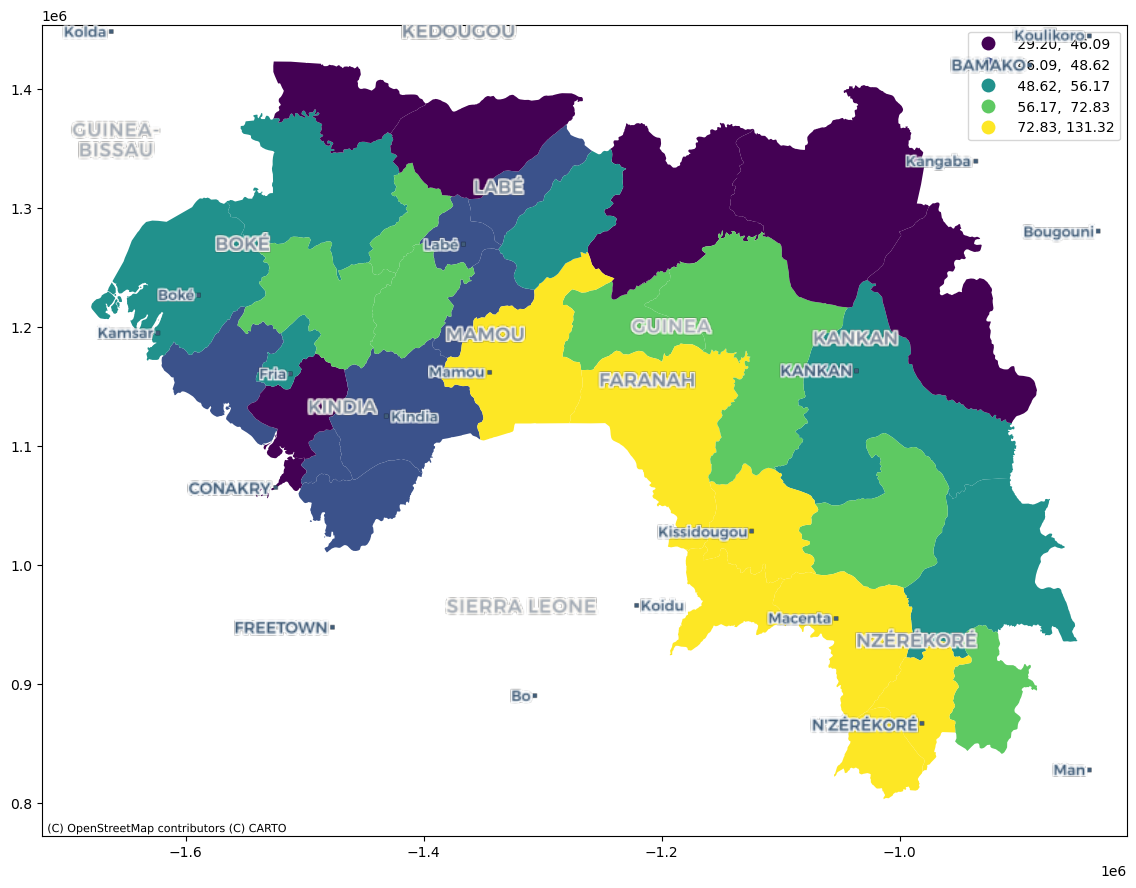

In [112]:
import contextily
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(14, 14))
admin2.to_crs(
    epsg=3857
).join(
    admin2_biomass
).plot(
    "mean", legend=True, scheme="quantiles", ax=ax
)
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.VoyagerOnlyLabels,
    zoom=7
)

#TODO: revise legend
